In [ ]:
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import numpy as np


import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# VAE

In [2]:
import torchvision
import torchvision.transforms as transforms


batch_size = 256
sample = 1


# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


if sample < 1:
    l = int(len(train_dataset)*sample)
    
    indexes = np.arange(len(train_dataset))
    np.random.shuffle(indexes)
    indexes = indexes[:l]
    
    train_sampler = SubsetRandomSampler(indexes)



# Data loader

if sample < 1:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [3]:

len(train_loader)

235

In [4]:
def show_batch(batch,nrow=32):
    im = torchvision.utils.make_grid(batch,nrow)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.axis('off')
    

Labels:  tensor([4, 1, 3, 9, 5, 9, 0, 9, 9, 9, 3, 0, 5, 5, 8, 4, 6, 9, 7, 9, 5, 3, 3, 5,
        6, 6, 5, 7, 3, 3, 0, 0, 1, 8, 7, 8, 1, 2, 2, 9, 0, 1, 8, 6, 4, 8, 8, 6,
        6, 0, 6, 1, 3, 1, 7, 0, 6, 3, 3, 4, 0, 5, 5, 1, 6, 0, 5, 4, 0, 1, 5, 7,
        6, 3, 7, 2, 2, 0, 9, 7, 3, 0, 7, 9, 9, 9, 2, 0, 1, 2, 2, 1, 7, 7, 1, 3,
        9, 4, 7, 1, 3, 3, 5, 4, 4, 9, 7, 3, 7, 6, 1, 3, 7, 7, 8, 7, 7, 4, 4, 0,
        7, 7, 6, 1, 9, 7, 6, 2, 8, 2, 7, 3, 7, 1, 9, 4, 7, 1, 2, 3, 8, 4, 1, 1,
        5, 6, 4, 3, 4, 1, 5, 6, 8, 9, 8, 6, 3, 1, 5, 7, 7, 0, 5, 4, 2, 0, 7, 6,
        0, 5, 1, 7, 2, 7, 6, 5, 1, 1, 9, 4, 3, 7, 2, 0, 9, 1, 9, 8, 1, 9, 0, 6,
        9, 8, 0, 0, 1, 0, 7, 6, 6, 1, 4, 6, 2, 1, 0, 9, 8, 2, 7, 6, 4, 8, 3, 3,
        0, 0, 5, 7, 1, 1, 1, 2, 6, 7, 1, 9, 5, 1, 9, 6, 6, 1, 8, 2, 6, 0, 1, 0,
        2, 2, 3, 4, 3, 2, 4, 3, 3, 5, 3, 4, 9, 0, 8, 6])
Batch shape:  torch.Size([256, 1, 28, 28])


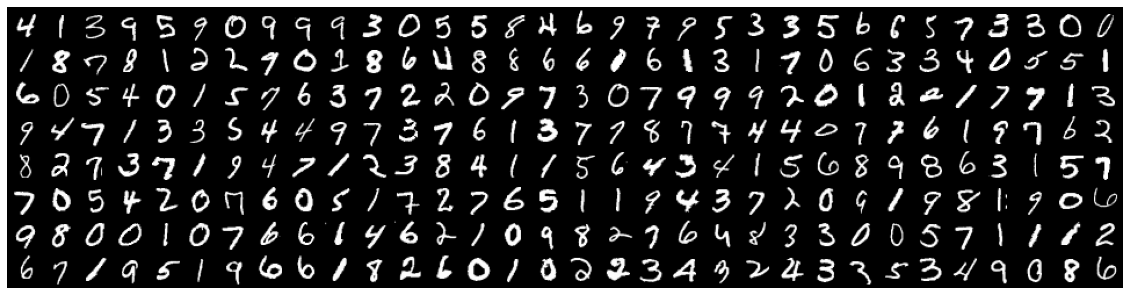

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())

plt.figure(figsize=(20,20))

show_batch(images)

In [6]:
class VAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, ):
        super(VAE, self).__init__()

        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        
        self.init_weights()        
        

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            nn.init.xavier_normal_(layer.weight)

        for layer in self.p_layers:
            nn.init.xavier_normal_(layer.weight)
        
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar
    
    
    def encode(self, input):
        h = input
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.relu(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu)


    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.relu(h)

        return torch.sigmoid(h)

    
    def generate(self,n_samples=1):
        
        device = next(self.parameters()).device
        
        with torch.no_grad():
            z = torch.randn((n_samples,self.p_dims[0])).to(device)
            return self.decode(z)

In [7]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [8]:
learning_rate = 0.0001
log_interval = 10

seed = 12356
torch.manual_seed(seed)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(p_dims=[128,256,784]).to(device) # z_dim = 64
criterion = loss_function

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 


num_epochs = 1000

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

In [9]:
import os


# The number of steps for each epoch, defined by the number of instances divided by the batch size. 
total_step = len(train_loader)

def train(epoch,model,criterion,optimizer,reshape=True):
    for batch_idx, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        if reshape:
            images = images.reshape(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, mu, logvar = model(images)
        loss = criterion(outputs, images, mu, logvar)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % log_interval == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        
        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))

        
def test(model,criterion,reshape=True):
    test_loss = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            if reshape:
                images = images.reshape(-1, 28*28)
                
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, mu, logvar = model(images)
            loss = criterion(outputs, images, mu, logvar) 
            
            test_loss += loss.item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))
    
    
    
def plot_results(model,data,model_name="vae_mnist",reshape=True):

    with torch.no_grad():
        for i,(images, labels) in enumerate(data):
            if reshape:
                images = images.reshape(-1, 28*28)                
            images = images.to(device)
            
            
            mu,logvar = model.encode(images)
            if i == 0:
                z_mean = model.reparameterize(mu,logvar).cpu()
                y_test = labels
            else:
                z_mean = torch.cat([z_mean,
                                    model.reparameterize(mu,logvar).detach().cpu()
                                   ]
                                   ,axis = 0)
                y_test = torch.cat([y_test,labels],axis = 0)

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test.numpy())
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    filename = os.path.join('data/vae/',model_name+'digits_over_latent.png')
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample).detach().cpu().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


In [10]:

for epoch in range(1,num_epochs+1):
    train(epoch,model,criterion,optimizer)
    test(model,criterion)


Epoch [1/1000], Step [10/235], Loss: 139323.6406
Epoch [1/1000], Step [20/235], Loss: 132685.4844
Epoch [1/1000], Step [30/235], Loss: 126250.1016
Epoch [1/1000], Step [40/235], Loss: 119346.4844
Epoch [1/1000], Step [50/235], Loss: 111076.6719
Epoch [1/1000], Step [60/235], Loss: 101124.9219
Epoch [1/1000], Step [70/235], Loss: 92562.2812
Epoch [1/1000], Step [80/235], Loss: 84303.3438
Epoch [1/1000], Step [90/235], Loss: 77213.2188
Epoch [1/1000], Step [100/235], Loss: 73682.7969
Epoch [1/1000], Step [110/235], Loss: 69049.1562
Epoch [1/1000], Step [120/235], Loss: 69368.8203
Epoch [1/1000], Step [130/235], Loss: 65778.6172
Epoch [1/1000], Step [140/235], Loss: 63463.5156
Epoch [1/1000], Step [150/235], Loss: 64005.4258
Epoch [1/1000], Step [160/235], Loss: 63725.8945
Epoch [1/1000], Step [170/235], Loss: 62220.4414
Epoch [1/1000], Step [180/235], Loss: 61766.0898
Epoch [1/1000], Step [190/235], Loss: 61631.7188
Epoch [1/1000], Step [200/235], Loss: 61519.1211
Epoch [1/1000], Step [2

Epoch [8/1000], Step [40/235], Loss: 41467.1484
Epoch [8/1000], Step [50/235], Loss: 39462.2852
Epoch [8/1000], Step [60/235], Loss: 40431.7188
Epoch [8/1000], Step [70/235], Loss: 39507.5820
Epoch [8/1000], Step [80/235], Loss: 39144.1758
Epoch [8/1000], Step [90/235], Loss: 40566.7500
Epoch [8/1000], Step [100/235], Loss: 40620.1289
Epoch [8/1000], Step [110/235], Loss: 39072.5625
Epoch [8/1000], Step [120/235], Loss: 39105.0547
Epoch [8/1000], Step [130/235], Loss: 39024.1719
Epoch [8/1000], Step [140/235], Loss: 40056.5234
Epoch [8/1000], Step [150/235], Loss: 39910.2734
Epoch [8/1000], Step [160/235], Loss: 39739.8359
Epoch [8/1000], Step [170/235], Loss: 38998.0117
Epoch [8/1000], Step [180/235], Loss: 39649.4531
Epoch [8/1000], Step [190/235], Loss: 38787.2422
Epoch [8/1000], Step [200/235], Loss: 39324.2812
Epoch [8/1000], Step [210/235], Loss: 39633.6133
Epoch [8/1000], Step [220/235], Loss: 39976.2930
Epoch [8/1000], Step [230/235], Loss: 40779.4219

Test set: Avg. loss: 152.

Epoch [26/1000], Step [130/235], Loss: 33009.8828
Epoch [26/1000], Step [140/235], Loss: 33823.0117
Epoch [26/1000], Step [150/235], Loss: 33800.7969
Epoch [26/1000], Step [160/235], Loss: 33585.1523
Epoch [26/1000], Step [170/235], Loss: 31986.9395
Epoch [26/1000], Step [180/235], Loss: 33790.3750
Epoch [26/1000], Step [190/235], Loss: 33228.8828
Epoch [26/1000], Step [200/235], Loss: 33368.8125
Epoch [26/1000], Step [210/235], Loss: 34340.0234
Epoch [26/1000], Step [220/235], Loss: 32505.4219
Epoch [26/1000], Step [230/235], Loss: 32752.4609

Test set: Avg. loss: 128.3437

Epoch [27/1000], Step [10/235], Loss: 33410.8672
Epoch [27/1000], Step [20/235], Loss: 32820.2734
Epoch [27/1000], Step [30/235], Loss: 31973.9141
Epoch [27/1000], Step [40/235], Loss: 32741.4336
Epoch [27/1000], Step [50/235], Loss: 33358.6641
Epoch [27/1000], Step [60/235], Loss: 34388.1602
Epoch [27/1000], Step [70/235], Loss: 33550.5234
Epoch [27/1000], Step [80/235], Loss: 33554.4336
Epoch [27/1000], Step [90/

Epoch [33/1000], Step [130/235], Loss: 32447.4629
Epoch [33/1000], Step [140/235], Loss: 32142.4785
Epoch [33/1000], Step [150/235], Loss: 31334.9844
Epoch [33/1000], Step [160/235], Loss: 31648.0898
Epoch [33/1000], Step [170/235], Loss: 31048.4238
Epoch [33/1000], Step [180/235], Loss: 31357.2480
Epoch [33/1000], Step [190/235], Loss: 32314.5039
Epoch [33/1000], Step [200/235], Loss: 31624.4277
Epoch [33/1000], Step [210/235], Loss: 32512.6562
Epoch [33/1000], Step [220/235], Loss: 31880.1562
Epoch [33/1000], Step [230/235], Loss: 32623.4531

Test set: Avg. loss: 123.4701

Epoch [34/1000], Step [10/235], Loss: 32921.5469
Epoch [34/1000], Step [20/235], Loss: 31553.6309
Epoch [34/1000], Step [30/235], Loss: 32182.3789
Epoch [34/1000], Step [40/235], Loss: 31559.4219
Epoch [34/1000], Step [50/235], Loss: 31766.7656
Epoch [34/1000], Step [60/235], Loss: 30694.9805
Epoch [34/1000], Step [70/235], Loss: 30781.2891
Epoch [34/1000], Step [80/235], Loss: 32289.3867
Epoch [34/1000], Step [90/

Epoch [40/1000], Step [150/235], Loss: 29988.9570
Epoch [40/1000], Step [160/235], Loss: 30876.5078
Epoch [40/1000], Step [170/235], Loss: 31053.4355
Epoch [40/1000], Step [180/235], Loss: 31087.5898
Epoch [40/1000], Step [190/235], Loss: 30804.6484
Epoch [40/1000], Step [200/235], Loss: 31341.8398
Epoch [40/1000], Step [210/235], Loss: 30290.2891
Epoch [40/1000], Step [220/235], Loss: 30142.3691
Epoch [40/1000], Step [230/235], Loss: 30379.2637

Test set: Avg. loss: 119.5222

Epoch [41/1000], Step [10/235], Loss: 30626.2012
Epoch [41/1000], Step [20/235], Loss: 30832.3594
Epoch [41/1000], Step [30/235], Loss: 31566.3887
Epoch [41/1000], Step [40/235], Loss: 30023.3730
Epoch [41/1000], Step [50/235], Loss: 30477.9102
Epoch [41/1000], Step [60/235], Loss: 31115.5801
Epoch [41/1000], Step [70/235], Loss: 31069.9102
Epoch [41/1000], Step [80/235], Loss: 30832.2461
Epoch [41/1000], Step [90/235], Loss: 29562.0840
Epoch [41/1000], Step [100/235], Loss: 31248.3691
Epoch [41/1000], Step [110/

Epoch [47/1000], Step [150/235], Loss: 29643.7734
Epoch [47/1000], Step [160/235], Loss: 29726.0137
Epoch [47/1000], Step [170/235], Loss: 30272.1758
Epoch [47/1000], Step [180/235], Loss: 30305.2441
Epoch [47/1000], Step [190/235], Loss: 30163.4766
Epoch [47/1000], Step [200/235], Loss: 29599.1855
Epoch [47/1000], Step [210/235], Loss: 30358.4844
Epoch [47/1000], Step [220/235], Loss: 28822.3789
Epoch [47/1000], Step [230/235], Loss: 30954.7871

Test set: Avg. loss: 116.3029

Epoch [48/1000], Step [10/235], Loss: 30242.1836
Epoch [48/1000], Step [20/235], Loss: 29640.7773
Epoch [48/1000], Step [30/235], Loss: 29959.8203
Epoch [48/1000], Step [40/235], Loss: 29869.3242
Epoch [48/1000], Step [50/235], Loss: 29849.7598
Epoch [48/1000], Step [60/235], Loss: 29745.4375
Epoch [48/1000], Step [70/235], Loss: 30220.2773
Epoch [48/1000], Step [80/235], Loss: 30085.7441
Epoch [48/1000], Step [90/235], Loss: 29662.4609
Epoch [48/1000], Step [100/235], Loss: 29951.9805
Epoch [48/1000], Step [110/

Epoch [54/1000], Step [150/235], Loss: 29477.2988
Epoch [54/1000], Step [160/235], Loss: 29752.6074
Epoch [54/1000], Step [170/235], Loss: 29084.2207
Epoch [54/1000], Step [180/235], Loss: 28007.8047
Epoch [54/1000], Step [190/235], Loss: 29316.6582
Epoch [54/1000], Step [200/235], Loss: 30375.4570
Epoch [54/1000], Step [210/235], Loss: 28863.6152
Epoch [54/1000], Step [220/235], Loss: 29642.0723
Epoch [54/1000], Step [230/235], Loss: 29460.0117

Test set: Avg. loss: 113.8073

Epoch [55/1000], Step [10/235], Loss: 28519.5215
Epoch [55/1000], Step [20/235], Loss: 28590.7695
Epoch [55/1000], Step [30/235], Loss: 28089.0430
Epoch [55/1000], Step [40/235], Loss: 29440.1719
Epoch [55/1000], Step [50/235], Loss: 29355.5664
Epoch [55/1000], Step [60/235], Loss: 29128.0039
Epoch [55/1000], Step [70/235], Loss: 28774.4453
Epoch [55/1000], Step [80/235], Loss: 29413.4727
Epoch [55/1000], Step [90/235], Loss: 29636.3340
Epoch [55/1000], Step [100/235], Loss: 29678.2227
Epoch [55/1000], Step [110/

Epoch [61/1000], Step [150/235], Loss: 29043.3477
Epoch [61/1000], Step [160/235], Loss: 29299.4062
Epoch [61/1000], Step [170/235], Loss: 28575.5234
Epoch [61/1000], Step [180/235], Loss: 28846.3301
Epoch [61/1000], Step [190/235], Loss: 28014.4336
Epoch [61/1000], Step [200/235], Loss: 28124.8926
Epoch [61/1000], Step [210/235], Loss: 29187.3555
Epoch [61/1000], Step [220/235], Loss: 29420.6797
Epoch [61/1000], Step [230/235], Loss: 28819.3125

Test set: Avg. loss: 112.0559

Epoch [62/1000], Step [10/235], Loss: 28921.2891
Epoch [62/1000], Step [20/235], Loss: 28595.0156
Epoch [62/1000], Step [30/235], Loss: 29038.8164
Epoch [62/1000], Step [40/235], Loss: 28749.4844
Epoch [62/1000], Step [50/235], Loss: 29073.2617
Epoch [62/1000], Step [60/235], Loss: 29066.5996
Epoch [62/1000], Step [70/235], Loss: 29084.3633
Epoch [62/1000], Step [80/235], Loss: 29333.3047
Epoch [62/1000], Step [90/235], Loss: 28818.0742
Epoch [62/1000], Step [100/235], Loss: 29108.5605
Epoch [62/1000], Step [110/

Epoch [68/1000], Step [150/235], Loss: 28933.4453
Epoch [68/1000], Step [160/235], Loss: 28326.2500
Epoch [68/1000], Step [170/235], Loss: 28629.3184
Epoch [68/1000], Step [180/235], Loss: 28796.8320
Epoch [68/1000], Step [190/235], Loss: 28405.8984
Epoch [68/1000], Step [200/235], Loss: 27624.4258
Epoch [68/1000], Step [210/235], Loss: 28956.0527
Epoch [68/1000], Step [220/235], Loss: 27835.9707
Epoch [68/1000], Step [230/235], Loss: 28622.0469

Test set: Avg. loss: 110.7776

Epoch [69/1000], Step [10/235], Loss: 28807.0586
Epoch [69/1000], Step [20/235], Loss: 28929.8574
Epoch [69/1000], Step [30/235], Loss: 28786.3105
Epoch [69/1000], Step [40/235], Loss: 28824.1602
Epoch [69/1000], Step [50/235], Loss: 28290.3438
Epoch [69/1000], Step [60/235], Loss: 28812.2793
Epoch [69/1000], Step [70/235], Loss: 27999.8242
Epoch [69/1000], Step [80/235], Loss: 28615.1719
Epoch [69/1000], Step [90/235], Loss: 29234.1172
Epoch [69/1000], Step [100/235], Loss: 27837.0938
Epoch [69/1000], Step [110/

Epoch [75/1000], Step [150/235], Loss: 28507.8086
Epoch [75/1000], Step [160/235], Loss: 28254.3652
Epoch [75/1000], Step [170/235], Loss: 28600.2227
Epoch [75/1000], Step [180/235], Loss: 28193.8750
Epoch [75/1000], Step [190/235], Loss: 28595.4238
Epoch [75/1000], Step [200/235], Loss: 28226.8086
Epoch [75/1000], Step [210/235], Loss: 28947.2031
Epoch [75/1000], Step [220/235], Loss: 28399.7969
Epoch [75/1000], Step [230/235], Loss: 28314.2402

Test set: Avg. loss: 109.7676

Epoch [76/1000], Step [10/235], Loss: 28664.0000
Epoch [76/1000], Step [20/235], Loss: 28937.5215
Epoch [76/1000], Step [30/235], Loss: 27689.7344
Epoch [76/1000], Step [40/235], Loss: 28973.2891
Epoch [76/1000], Step [50/235], Loss: 28657.0000
Epoch [76/1000], Step [60/235], Loss: 28261.0312
Epoch [76/1000], Step [70/235], Loss: 28594.9102
Epoch [76/1000], Step [80/235], Loss: 28684.1582
Epoch [76/1000], Step [90/235], Loss: 28536.8008
Epoch [76/1000], Step [100/235], Loss: 28196.9473
Epoch [76/1000], Step [110/

Epoch [82/1000], Step [150/235], Loss: 27714.7109
Epoch [82/1000], Step [160/235], Loss: 28301.5898
Epoch [82/1000], Step [170/235], Loss: 27702.4062
Epoch [82/1000], Step [180/235], Loss: 27929.4375
Epoch [82/1000], Step [190/235], Loss: 29025.3672
Epoch [82/1000], Step [200/235], Loss: 28169.4883
Epoch [82/1000], Step [210/235], Loss: 28385.3633
Epoch [82/1000], Step [220/235], Loss: 28228.0977
Epoch [82/1000], Step [230/235], Loss: 27678.4043

Test set: Avg. loss: 109.0080

Epoch [83/1000], Step [10/235], Loss: 27819.3672
Epoch [83/1000], Step [20/235], Loss: 27254.4277
Epoch [83/1000], Step [30/235], Loss: 28102.5273
Epoch [83/1000], Step [40/235], Loss: 27854.4688
Epoch [83/1000], Step [50/235], Loss: 27375.0156
Epoch [83/1000], Step [60/235], Loss: 28424.4609
Epoch [83/1000], Step [70/235], Loss: 27729.3906
Epoch [83/1000], Step [80/235], Loss: 28702.3613
Epoch [83/1000], Step [90/235], Loss: 27794.2441
Epoch [83/1000], Step [100/235], Loss: 28308.2188
Epoch [83/1000], Step [110/

Epoch [89/1000], Step [150/235], Loss: 27762.8457
Epoch [89/1000], Step [160/235], Loss: 27042.0137
Epoch [89/1000], Step [170/235], Loss: 27795.8711
Epoch [89/1000], Step [180/235], Loss: 28087.0137
Epoch [89/1000], Step [190/235], Loss: 27497.3906
Epoch [89/1000], Step [200/235], Loss: 27384.9902
Epoch [89/1000], Step [210/235], Loss: 27923.4805
Epoch [89/1000], Step [220/235], Loss: 27666.0703
Epoch [89/1000], Step [230/235], Loss: 28078.7246

Test set: Avg. loss: 108.3592

Epoch [90/1000], Step [10/235], Loss: 27831.5391
Epoch [90/1000], Step [20/235], Loss: 27779.3555
Epoch [90/1000], Step [30/235], Loss: 27319.6855
Epoch [90/1000], Step [40/235], Loss: 28105.7949
Epoch [90/1000], Step [50/235], Loss: 27084.4199
Epoch [90/1000], Step [60/235], Loss: 28304.0254
Epoch [90/1000], Step [70/235], Loss: 27435.0840
Epoch [90/1000], Step [80/235], Loss: 28123.3770
Epoch [90/1000], Step [90/235], Loss: 27355.5742
Epoch [90/1000], Step [100/235], Loss: 28231.1367
Epoch [90/1000], Step [110/

Epoch [96/1000], Step [150/235], Loss: 27690.5742
Epoch [96/1000], Step [160/235], Loss: 27928.0938
Epoch [96/1000], Step [170/235], Loss: 28154.0742
Epoch [96/1000], Step [180/235], Loss: 28010.9902
Epoch [96/1000], Step [190/235], Loss: 27470.3125
Epoch [96/1000], Step [200/235], Loss: 28228.6367
Epoch [96/1000], Step [210/235], Loss: 27378.4707
Epoch [96/1000], Step [220/235], Loss: 27406.4297
Epoch [96/1000], Step [230/235], Loss: 28386.8594

Test set: Avg. loss: 107.9640

Epoch [97/1000], Step [10/235], Loss: 28153.3789
Epoch [97/1000], Step [20/235], Loss: 27792.3262
Epoch [97/1000], Step [30/235], Loss: 26901.2090
Epoch [97/1000], Step [40/235], Loss: 27897.0449
Epoch [97/1000], Step [50/235], Loss: 27071.7461
Epoch [97/1000], Step [60/235], Loss: 28140.3125
Epoch [97/1000], Step [70/235], Loss: 27945.1055
Epoch [97/1000], Step [80/235], Loss: 27713.8203
Epoch [97/1000], Step [90/235], Loss: 27858.8457
Epoch [97/1000], Step [100/235], Loss: 28111.4980
Epoch [97/1000], Step [110/

Epoch [103/1000], Step [140/235], Loss: 27689.9961
Epoch [103/1000], Step [150/235], Loss: 27561.8164
Epoch [103/1000], Step [160/235], Loss: 27094.7109
Epoch [103/1000], Step [170/235], Loss: 27749.3750
Epoch [103/1000], Step [180/235], Loss: 26918.5410
Epoch [103/1000], Step [190/235], Loss: 27837.5156
Epoch [103/1000], Step [200/235], Loss: 28180.0762
Epoch [103/1000], Step [210/235], Loss: 27873.6113
Epoch [103/1000], Step [220/235], Loss: 27671.0801
Epoch [103/1000], Step [230/235], Loss: 28014.9004

Test set: Avg. loss: 107.5800

Epoch [104/1000], Step [10/235], Loss: 27578.0762
Epoch [104/1000], Step [20/235], Loss: 27927.7793
Epoch [104/1000], Step [30/235], Loss: 27033.6621
Epoch [104/1000], Step [40/235], Loss: 28244.1328
Epoch [104/1000], Step [50/235], Loss: 27972.7383
Epoch [104/1000], Step [60/235], Loss: 27613.6641
Epoch [104/1000], Step [70/235], Loss: 28415.2148
Epoch [104/1000], Step [80/235], Loss: 27499.7207
Epoch [104/1000], Step [90/235], Loss: 27539.7070
Epoch [1

Epoch [110/1000], Step [110/235], Loss: 28037.8984
Epoch [110/1000], Step [120/235], Loss: 27540.2539
Epoch [110/1000], Step [130/235], Loss: 27822.2598
Epoch [110/1000], Step [140/235], Loss: 28206.5000
Epoch [110/1000], Step [150/235], Loss: 27769.1680
Epoch [110/1000], Step [160/235], Loss: 27287.3203
Epoch [110/1000], Step [170/235], Loss: 27396.7734
Epoch [110/1000], Step [180/235], Loss: 27366.9980
Epoch [110/1000], Step [190/235], Loss: 27820.8398
Epoch [110/1000], Step [200/235], Loss: 26622.4902
Epoch [110/1000], Step [210/235], Loss: 26631.9023
Epoch [110/1000], Step [220/235], Loss: 27680.8613
Epoch [110/1000], Step [230/235], Loss: 27070.5234

Test set: Avg. loss: 107.1168

Epoch [111/1000], Step [10/235], Loss: 27621.3281
Epoch [111/1000], Step [20/235], Loss: 27815.8008
Epoch [111/1000], Step [30/235], Loss: 27973.7988
Epoch [111/1000], Step [40/235], Loss: 27902.9512
Epoch [111/1000], Step [50/235], Loss: 27496.2246
Epoch [111/1000], Step [60/235], Loss: 27462.8555
Epoch

Epoch [117/1000], Step [80/235], Loss: 27828.2148
Epoch [117/1000], Step [90/235], Loss: 27330.0312
Epoch [117/1000], Step [100/235], Loss: 28385.5977
Epoch [117/1000], Step [110/235], Loss: 27214.0664
Epoch [117/1000], Step [120/235], Loss: 26970.6035
Epoch [117/1000], Step [130/235], Loss: 27453.7188
Epoch [117/1000], Step [140/235], Loss: 28303.1387
Epoch [117/1000], Step [150/235], Loss: 27385.0020
Epoch [117/1000], Step [160/235], Loss: 26759.3711
Epoch [117/1000], Step [170/235], Loss: 27026.6289
Epoch [117/1000], Step [180/235], Loss: 27411.3242
Epoch [117/1000], Step [190/235], Loss: 26922.6602
Epoch [117/1000], Step [200/235], Loss: 26945.5527
Epoch [117/1000], Step [210/235], Loss: 27929.1035
Epoch [117/1000], Step [220/235], Loss: 28093.7266
Epoch [117/1000], Step [230/235], Loss: 26675.4297

Test set: Avg. loss: 106.8149

Epoch [118/1000], Step [10/235], Loss: 27799.8438
Epoch [118/1000], Step [20/235], Loss: 27606.7773
Epoch [118/1000], Step [30/235], Loss: 28266.8848
Epoc

Epoch [124/1000], Step [50/235], Loss: 27310.5156
Epoch [124/1000], Step [60/235], Loss: 27785.2559
Epoch [124/1000], Step [70/235], Loss: 27510.0000
Epoch [124/1000], Step [80/235], Loss: 27659.0508
Epoch [124/1000], Step [90/235], Loss: 27628.4102
Epoch [124/1000], Step [100/235], Loss: 27928.0371
Epoch [124/1000], Step [110/235], Loss: 27122.7070
Epoch [124/1000], Step [120/235], Loss: 27331.6797
Epoch [124/1000], Step [130/235], Loss: 27061.0664
Epoch [124/1000], Step [140/235], Loss: 27677.3027
Epoch [124/1000], Step [150/235], Loss: 27555.5195
Epoch [124/1000], Step [160/235], Loss: 28093.0117
Epoch [124/1000], Step [170/235], Loss: 26707.4824
Epoch [124/1000], Step [180/235], Loss: 27321.2852
Epoch [124/1000], Step [190/235], Loss: 26960.0723
Epoch [124/1000], Step [200/235], Loss: 27670.5625
Epoch [124/1000], Step [210/235], Loss: 27952.9727
Epoch [124/1000], Step [220/235], Loss: 26830.8984
Epoch [124/1000], Step [230/235], Loss: 27967.9336

Test set: Avg. loss: 106.5470

Epoc

Epoch [131/1000], Step [20/235], Loss: 27552.2754
Epoch [131/1000], Step [30/235], Loss: 26703.1094
Epoch [131/1000], Step [40/235], Loss: 27337.2402
Epoch [131/1000], Step [50/235], Loss: 27521.7520
Epoch [131/1000], Step [60/235], Loss: 28187.2266
Epoch [131/1000], Step [70/235], Loss: 27285.5684
Epoch [131/1000], Step [80/235], Loss: 27456.6895
Epoch [131/1000], Step [90/235], Loss: 27642.7852
Epoch [131/1000], Step [100/235], Loss: 27144.9453
Epoch [131/1000], Step [110/235], Loss: 27706.8965
Epoch [131/1000], Step [120/235], Loss: 27303.6406
Epoch [131/1000], Step [130/235], Loss: 27024.5664
Epoch [131/1000], Step [140/235], Loss: 26439.0703
Epoch [131/1000], Step [150/235], Loss: 27289.4570
Epoch [131/1000], Step [160/235], Loss: 27234.3457
Epoch [131/1000], Step [170/235], Loss: 27433.7090
Epoch [131/1000], Step [180/235], Loss: 27836.0488
Epoch [131/1000], Step [190/235], Loss: 26400.6758
Epoch [131/1000], Step [200/235], Loss: 27277.8613
Epoch [131/1000], Step [210/235], Loss:

Epoch [137/1000], Step [230/235], Loss: 27400.1777

Test set: Avg. loss: 106.1523

Epoch [138/1000], Step [10/235], Loss: 28283.5352
Epoch [138/1000], Step [20/235], Loss: 27211.8145
Epoch [138/1000], Step [30/235], Loss: 27575.3496
Epoch [138/1000], Step [40/235], Loss: 27366.9941
Epoch [138/1000], Step [50/235], Loss: 27664.5430
Epoch [138/1000], Step [60/235], Loss: 27136.6973
Epoch [138/1000], Step [70/235], Loss: 27549.2461
Epoch [138/1000], Step [80/235], Loss: 26736.4434
Epoch [138/1000], Step [90/235], Loss: 27168.3086
Epoch [138/1000], Step [100/235], Loss: 27103.8828
Epoch [138/1000], Step [110/235], Loss: 27690.9863
Epoch [138/1000], Step [120/235], Loss: 27552.0488
Epoch [138/1000], Step [130/235], Loss: 27092.0742
Epoch [138/1000], Step [140/235], Loss: 27109.3594
Epoch [138/1000], Step [150/235], Loss: 27345.0859
Epoch [138/1000], Step [160/235], Loss: 26418.7422
Epoch [138/1000], Step [170/235], Loss: 27798.6719
Epoch [138/1000], Step [180/235], Loss: 27204.3594
Epoch [1

Epoch [144/1000], Step [200/235], Loss: 26709.6055
Epoch [144/1000], Step [210/235], Loss: 27693.6953
Epoch [144/1000], Step [220/235], Loss: 27120.4902
Epoch [144/1000], Step [230/235], Loss: 26611.0430

Test set: Avg. loss: 105.9579

Epoch [145/1000], Step [10/235], Loss: 27963.4277
Epoch [145/1000], Step [20/235], Loss: 26780.9980
Epoch [145/1000], Step [30/235], Loss: 27640.2461
Epoch [145/1000], Step [40/235], Loss: 26831.8340
Epoch [145/1000], Step [50/235], Loss: 27111.1680
Epoch [145/1000], Step [60/235], Loss: 27763.2676
Epoch [145/1000], Step [70/235], Loss: 27553.6758
Epoch [145/1000], Step [80/235], Loss: 27651.6055
Epoch [145/1000], Step [90/235], Loss: 27916.2988
Epoch [145/1000], Step [100/235], Loss: 26884.4219
Epoch [145/1000], Step [110/235], Loss: 26937.5312
Epoch [145/1000], Step [120/235], Loss: 26764.2832
Epoch [145/1000], Step [130/235], Loss: 26781.4102
Epoch [145/1000], Step [140/235], Loss: 27539.9023
Epoch [145/1000], Step [150/235], Loss: 27442.7871
Epoch [1

Epoch [151/1000], Step [170/235], Loss: 26865.6738
Epoch [151/1000], Step [180/235], Loss: 27629.9922
Epoch [151/1000], Step [190/235], Loss: 27891.4590
Epoch [151/1000], Step [200/235], Loss: 27265.8574
Epoch [151/1000], Step [210/235], Loss: 27338.6641
Epoch [151/1000], Step [220/235], Loss: 27447.4844
Epoch [151/1000], Step [230/235], Loss: 27265.1855

Test set: Avg. loss: 105.7085

Epoch [152/1000], Step [10/235], Loss: 27715.4609
Epoch [152/1000], Step [20/235], Loss: 27284.9395
Epoch [152/1000], Step [30/235], Loss: 27528.9316
Epoch [152/1000], Step [40/235], Loss: 26868.6621
Epoch [152/1000], Step [50/235], Loss: 27442.3945
Epoch [152/1000], Step [60/235], Loss: 27313.4258
Epoch [152/1000], Step [70/235], Loss: 26630.4336
Epoch [152/1000], Step [80/235], Loss: 27507.1250
Epoch [152/1000], Step [90/235], Loss: 26723.1641
Epoch [152/1000], Step [100/235], Loss: 27226.3438
Epoch [152/1000], Step [110/235], Loss: 26970.0859
Epoch [152/1000], Step [120/235], Loss: 27811.4180
Epoch [1

Epoch [158/1000], Step [140/235], Loss: 27558.4336
Epoch [158/1000], Step [150/235], Loss: 27395.3672
Epoch [158/1000], Step [160/235], Loss: 26936.9688
Epoch [158/1000], Step [170/235], Loss: 27178.2148
Epoch [158/1000], Step [180/235], Loss: 27054.7832
Epoch [158/1000], Step [190/235], Loss: 27062.3906
Epoch [158/1000], Step [200/235], Loss: 26911.9258
Epoch [158/1000], Step [210/235], Loss: 27194.0527
Epoch [158/1000], Step [220/235], Loss: 26135.3281
Epoch [158/1000], Step [230/235], Loss: 26820.2070

Test set: Avg. loss: 105.5858

Epoch [159/1000], Step [10/235], Loss: 27411.4219
Epoch [159/1000], Step [20/235], Loss: 27578.0840
Epoch [159/1000], Step [30/235], Loss: 27365.9102
Epoch [159/1000], Step [40/235], Loss: 27252.7246
Epoch [159/1000], Step [50/235], Loss: 27616.0586
Epoch [159/1000], Step [60/235], Loss: 27244.7051
Epoch [159/1000], Step [70/235], Loss: 27441.9883
Epoch [159/1000], Step [80/235], Loss: 28358.8555
Epoch [159/1000], Step [90/235], Loss: 27096.3672
Epoch [1

Epoch [165/1000], Step [110/235], Loss: 27245.7148
Epoch [165/1000], Step [120/235], Loss: 27379.7461
Epoch [165/1000], Step [130/235], Loss: 26735.2520
Epoch [165/1000], Step [140/235], Loss: 26475.5801
Epoch [165/1000], Step [150/235], Loss: 26369.1074
Epoch [165/1000], Step [160/235], Loss: 27569.1797
Epoch [165/1000], Step [170/235], Loss: 26763.9395
Epoch [165/1000], Step [180/235], Loss: 27150.5332
Epoch [165/1000], Step [190/235], Loss: 27207.3398
Epoch [165/1000], Step [200/235], Loss: 27383.9062
Epoch [165/1000], Step [210/235], Loss: 27903.2344
Epoch [165/1000], Step [220/235], Loss: 27323.4375
Epoch [165/1000], Step [230/235], Loss: 26721.8008

Test set: Avg. loss: 105.4138

Epoch [166/1000], Step [10/235], Loss: 26509.9980
Epoch [166/1000], Step [20/235], Loss: 27452.6172
Epoch [166/1000], Step [30/235], Loss: 27848.6289
Epoch [166/1000], Step [40/235], Loss: 27453.6758
Epoch [166/1000], Step [50/235], Loss: 26949.8770
Epoch [166/1000], Step [60/235], Loss: 26150.4863
Epoch

Epoch [172/1000], Step [80/235], Loss: 26972.3027
Epoch [172/1000], Step [90/235], Loss: 27432.4082
Epoch [172/1000], Step [100/235], Loss: 27212.6328
Epoch [172/1000], Step [110/235], Loss: 27544.3398
Epoch [172/1000], Step [120/235], Loss: 27232.1367
Epoch [172/1000], Step [130/235], Loss: 26419.4609
Epoch [172/1000], Step [140/235], Loss: 26469.1816
Epoch [172/1000], Step [150/235], Loss: 27380.2578
Epoch [172/1000], Step [160/235], Loss: 26946.4121
Epoch [172/1000], Step [170/235], Loss: 27414.9961
Epoch [172/1000], Step [180/235], Loss: 26440.8125
Epoch [172/1000], Step [190/235], Loss: 26858.0391
Epoch [172/1000], Step [200/235], Loss: 27269.6211
Epoch [172/1000], Step [210/235], Loss: 26684.7637
Epoch [172/1000], Step [220/235], Loss: 26915.7227
Epoch [172/1000], Step [230/235], Loss: 27229.5234

Test set: Avg. loss: 105.2677

Epoch [173/1000], Step [10/235], Loss: 27315.2344
Epoch [173/1000], Step [20/235], Loss: 26771.1758
Epoch [173/1000], Step [30/235], Loss: 27113.6445
Epoc

Epoch [179/1000], Step [50/235], Loss: 26791.1094
Epoch [179/1000], Step [60/235], Loss: 27586.4570
Epoch [179/1000], Step [70/235], Loss: 26191.5703
Epoch [179/1000], Step [80/235], Loss: 27858.7148
Epoch [179/1000], Step [90/235], Loss: 27903.6641
Epoch [179/1000], Step [100/235], Loss: 26461.8555
Epoch [179/1000], Step [110/235], Loss: 27940.1289
Epoch [179/1000], Step [120/235], Loss: 26523.9922
Epoch [179/1000], Step [130/235], Loss: 26666.5195
Epoch [179/1000], Step [140/235], Loss: 27137.6445
Epoch [179/1000], Step [150/235], Loss: 27180.0508
Epoch [179/1000], Step [160/235], Loss: 27204.5527
Epoch [179/1000], Step [170/235], Loss: 27141.2578
Epoch [179/1000], Step [180/235], Loss: 27413.6562
Epoch [179/1000], Step [190/235], Loss: 26310.2910
Epoch [179/1000], Step [200/235], Loss: 27562.2832
Epoch [179/1000], Step [210/235], Loss: 26862.6484
Epoch [179/1000], Step [220/235], Loss: 26875.3555
Epoch [179/1000], Step [230/235], Loss: 27652.4512

Test set: Avg. loss: 105.0553

Epoc

Epoch [186/1000], Step [20/235], Loss: 26807.2793
Epoch [186/1000], Step [30/235], Loss: 27345.4766
Epoch [186/1000], Step [40/235], Loss: 26443.9707
Epoch [186/1000], Step [50/235], Loss: 27024.1172
Epoch [186/1000], Step [60/235], Loss: 26695.0781
Epoch [186/1000], Step [70/235], Loss: 27076.9648
Epoch [186/1000], Step [80/235], Loss: 26949.7617
Epoch [186/1000], Step [90/235], Loss: 27854.6504
Epoch [186/1000], Step [100/235], Loss: 26490.4766
Epoch [186/1000], Step [110/235], Loss: 27225.3145
Epoch [186/1000], Step [120/235], Loss: 27482.1777
Epoch [186/1000], Step [130/235], Loss: 27143.8242
Epoch [186/1000], Step [140/235], Loss: 28031.3438
Epoch [186/1000], Step [150/235], Loss: 26988.4648
Epoch [186/1000], Step [160/235], Loss: 26404.4102
Epoch [186/1000], Step [170/235], Loss: 26953.1602
Epoch [186/1000], Step [180/235], Loss: 26770.1777
Epoch [186/1000], Step [190/235], Loss: 26821.0938
Epoch [186/1000], Step [200/235], Loss: 26330.4727
Epoch [186/1000], Step [210/235], Loss:

Epoch [192/1000], Step [230/235], Loss: 27234.7891

Test set: Avg. loss: 104.8558

Epoch [193/1000], Step [10/235], Loss: 27109.3770
Epoch [193/1000], Step [20/235], Loss: 27012.6875
Epoch [193/1000], Step [30/235], Loss: 26734.3398
Epoch [193/1000], Step [40/235], Loss: 27258.0273
Epoch [193/1000], Step [50/235], Loss: 26761.0625
Epoch [193/1000], Step [60/235], Loss: 26961.7891
Epoch [193/1000], Step [70/235], Loss: 27476.7793
Epoch [193/1000], Step [80/235], Loss: 26676.4902
Epoch [193/1000], Step [90/235], Loss: 27140.4238
Epoch [193/1000], Step [100/235], Loss: 26849.5488
Epoch [193/1000], Step [110/235], Loss: 26833.1992
Epoch [193/1000], Step [120/235], Loss: 27069.4883
Epoch [193/1000], Step [130/235], Loss: 26460.1133
Epoch [193/1000], Step [140/235], Loss: 26529.4551
Epoch [193/1000], Step [150/235], Loss: 27136.6465
Epoch [193/1000], Step [160/235], Loss: 26645.1680
Epoch [193/1000], Step [170/235], Loss: 26612.4492
Epoch [193/1000], Step [180/235], Loss: 26952.6855
Epoch [1

Epoch [199/1000], Step [200/235], Loss: 26651.8535
Epoch [199/1000], Step [210/235], Loss: 26700.4727
Epoch [199/1000], Step [220/235], Loss: 27656.2480
Epoch [199/1000], Step [230/235], Loss: 27731.4375

Test set: Avg. loss: 104.7912

Epoch [200/1000], Step [10/235], Loss: 26747.5098
Epoch [200/1000], Step [20/235], Loss: 26757.0547
Epoch [200/1000], Step [30/235], Loss: 26928.7383
Epoch [200/1000], Step [40/235], Loss: 27239.6758
Epoch [200/1000], Step [50/235], Loss: 26677.6719
Epoch [200/1000], Step [60/235], Loss: 26637.2617
Epoch [200/1000], Step [70/235], Loss: 26822.4160
Epoch [200/1000], Step [80/235], Loss: 27217.6270
Epoch [200/1000], Step [90/235], Loss: 26720.1680
Epoch [200/1000], Step [100/235], Loss: 26634.1543
Epoch [200/1000], Step [110/235], Loss: 26855.9453
Epoch [200/1000], Step [120/235], Loss: 26107.1250
Epoch [200/1000], Step [130/235], Loss: 26639.6738
Epoch [200/1000], Step [140/235], Loss: 27260.0547
Epoch [200/1000], Step [150/235], Loss: 26397.1094
Epoch [2

Epoch [206/1000], Step [170/235], Loss: 27034.6719
Epoch [206/1000], Step [180/235], Loss: 27179.2266
Epoch [206/1000], Step [190/235], Loss: 26471.8691
Epoch [206/1000], Step [200/235], Loss: 26667.2910
Epoch [206/1000], Step [210/235], Loss: 27049.1289
Epoch [206/1000], Step [220/235], Loss: 26478.5000
Epoch [206/1000], Step [230/235], Loss: 27586.7227

Test set: Avg. loss: 104.7265

Epoch [207/1000], Step [10/235], Loss: 27110.0371
Epoch [207/1000], Step [20/235], Loss: 26607.2695
Epoch [207/1000], Step [30/235], Loss: 26342.5508
Epoch [207/1000], Step [40/235], Loss: 26341.4492
Epoch [207/1000], Step [50/235], Loss: 26756.4688
Epoch [207/1000], Step [60/235], Loss: 26751.3477
Epoch [207/1000], Step [70/235], Loss: 26898.5918
Epoch [207/1000], Step [80/235], Loss: 27067.1719
Epoch [207/1000], Step [90/235], Loss: 26811.4668
Epoch [207/1000], Step [100/235], Loss: 27160.8047
Epoch [207/1000], Step [110/235], Loss: 26862.6211
Epoch [207/1000], Step [120/235], Loss: 26923.8711
Epoch [2

Epoch [213/1000], Step [140/235], Loss: 27016.9336
Epoch [213/1000], Step [150/235], Loss: 26367.8789
Epoch [213/1000], Step [160/235], Loss: 27325.3438
Epoch [213/1000], Step [170/235], Loss: 26942.9766
Epoch [213/1000], Step [180/235], Loss: 27686.7168
Epoch [213/1000], Step [190/235], Loss: 27216.2266
Epoch [213/1000], Step [200/235], Loss: 26880.6875
Epoch [213/1000], Step [210/235], Loss: 26752.2070
Epoch [213/1000], Step [220/235], Loss: 27101.3359
Epoch [213/1000], Step [230/235], Loss: 26582.2812

Test set: Avg. loss: 104.5869

Epoch [214/1000], Step [10/235], Loss: 26935.8594
Epoch [214/1000], Step [20/235], Loss: 26642.6035
Epoch [214/1000], Step [30/235], Loss: 27582.7461
Epoch [214/1000], Step [40/235], Loss: 26840.4688
Epoch [214/1000], Step [50/235], Loss: 26662.1270
Epoch [214/1000], Step [60/235], Loss: 26660.0078
Epoch [214/1000], Step [70/235], Loss: 26181.0820
Epoch [214/1000], Step [80/235], Loss: 26904.1992
Epoch [214/1000], Step [90/235], Loss: 26961.2988
Epoch [2

Epoch [220/1000], Step [110/235], Loss: 27010.4141
Epoch [220/1000], Step [120/235], Loss: 26770.4492
Epoch [220/1000], Step [130/235], Loss: 25894.7578
Epoch [220/1000], Step [140/235], Loss: 27233.4219
Epoch [220/1000], Step [150/235], Loss: 27010.8828
Epoch [220/1000], Step [160/235], Loss: 27155.2578
Epoch [220/1000], Step [170/235], Loss: 25794.8105
Epoch [220/1000], Step [180/235], Loss: 26309.2109
Epoch [220/1000], Step [190/235], Loss: 27150.0664
Epoch [220/1000], Step [200/235], Loss: 26395.1641
Epoch [220/1000], Step [210/235], Loss: 25876.1133
Epoch [220/1000], Step [220/235], Loss: 26144.4512
Epoch [220/1000], Step [230/235], Loss: 26728.5039

Test set: Avg. loss: 104.4358

Epoch [221/1000], Step [10/235], Loss: 26482.6211
Epoch [221/1000], Step [20/235], Loss: 27103.1211
Epoch [221/1000], Step [30/235], Loss: 27643.0898
Epoch [221/1000], Step [40/235], Loss: 26558.5762
Epoch [221/1000], Step [50/235], Loss: 27855.8340
Epoch [221/1000], Step [60/235], Loss: 26544.6973
Epoch

Epoch [227/1000], Step [80/235], Loss: 26849.1270
Epoch [227/1000], Step [90/235], Loss: 27167.0371
Epoch [227/1000], Step [100/235], Loss: 26600.9922
Epoch [227/1000], Step [110/235], Loss: 26452.9941
Epoch [227/1000], Step [120/235], Loss: 26985.6504
Epoch [227/1000], Step [130/235], Loss: 27023.8867
Epoch [227/1000], Step [140/235], Loss: 27117.0312
Epoch [227/1000], Step [150/235], Loss: 26587.1953
Epoch [227/1000], Step [160/235], Loss: 26234.2949
Epoch [227/1000], Step [170/235], Loss: 26434.0996
Epoch [227/1000], Step [180/235], Loss: 26672.9883
Epoch [227/1000], Step [190/235], Loss: 26781.3301
Epoch [227/1000], Step [200/235], Loss: 26644.5625
Epoch [227/1000], Step [210/235], Loss: 27429.7695
Epoch [227/1000], Step [220/235], Loss: 27209.2617
Epoch [227/1000], Step [230/235], Loss: 26495.8438

Test set: Avg. loss: 104.4415

Epoch [228/1000], Step [10/235], Loss: 27614.7754
Epoch [228/1000], Step [20/235], Loss: 27433.9805
Epoch [228/1000], Step [30/235], Loss: 27229.2930
Epoc

Epoch [234/1000], Step [50/235], Loss: 27045.2266
Epoch [234/1000], Step [60/235], Loss: 27450.9844
Epoch [234/1000], Step [70/235], Loss: 26730.3008
Epoch [234/1000], Step [80/235], Loss: 27433.8535
Epoch [234/1000], Step [90/235], Loss: 26909.4336
Epoch [234/1000], Step [100/235], Loss: 26220.1211
Epoch [234/1000], Step [110/235], Loss: 26351.7578
Epoch [234/1000], Step [120/235], Loss: 26861.6172
Epoch [234/1000], Step [130/235], Loss: 26020.0723
Epoch [234/1000], Step [140/235], Loss: 26575.1367
Epoch [234/1000], Step [150/235], Loss: 26924.3672
Epoch [234/1000], Step [160/235], Loss: 27166.4922
Epoch [234/1000], Step [170/235], Loss: 26766.8633
Epoch [234/1000], Step [180/235], Loss: 26739.8770
Epoch [234/1000], Step [190/235], Loss: 27297.3281
Epoch [234/1000], Step [200/235], Loss: 26812.2793
Epoch [234/1000], Step [210/235], Loss: 27235.0801
Epoch [234/1000], Step [220/235], Loss: 26516.5352
Epoch [234/1000], Step [230/235], Loss: 26828.9766

Test set: Avg. loss: 104.3350

Epoc

Epoch [241/1000], Step [20/235], Loss: 27103.0098
Epoch [241/1000], Step [30/235], Loss: 26702.2988
Epoch [241/1000], Step [40/235], Loss: 26182.0996
Epoch [241/1000], Step [50/235], Loss: 26461.0859
Epoch [241/1000], Step [60/235], Loss: 27388.9551
Epoch [241/1000], Step [70/235], Loss: 26869.5469
Epoch [241/1000], Step [80/235], Loss: 26559.3672
Epoch [241/1000], Step [90/235], Loss: 26675.4609
Epoch [241/1000], Step [100/235], Loss: 26789.0273
Epoch [241/1000], Step [110/235], Loss: 26253.3008
Epoch [241/1000], Step [120/235], Loss: 26495.6094
Epoch [241/1000], Step [130/235], Loss: 26389.3125
Epoch [241/1000], Step [140/235], Loss: 26852.5156
Epoch [241/1000], Step [150/235], Loss: 27035.1406
Epoch [241/1000], Step [160/235], Loss: 25727.4688
Epoch [241/1000], Step [170/235], Loss: 27119.9551
Epoch [241/1000], Step [180/235], Loss: 26996.8945
Epoch [241/1000], Step [190/235], Loss: 26364.6348
Epoch [241/1000], Step [200/235], Loss: 26897.9531
Epoch [241/1000], Step [210/235], Loss:

Epoch [247/1000], Step [230/235], Loss: 26806.4902

Test set: Avg. loss: 104.1102

Epoch [248/1000], Step [10/235], Loss: 26891.1113
Epoch [248/1000], Step [20/235], Loss: 25761.5508
Epoch [248/1000], Step [30/235], Loss: 26543.5859
Epoch [248/1000], Step [40/235], Loss: 27264.0840
Epoch [248/1000], Step [50/235], Loss: 27070.4082
Epoch [248/1000], Step [60/235], Loss: 27047.0020
Epoch [248/1000], Step [70/235], Loss: 26994.3477
Epoch [248/1000], Step [80/235], Loss: 27053.5586
Epoch [248/1000], Step [90/235], Loss: 26822.6445
Epoch [248/1000], Step [100/235], Loss: 26804.9883
Epoch [248/1000], Step [110/235], Loss: 26895.6367
Epoch [248/1000], Step [120/235], Loss: 26363.3086
Epoch [248/1000], Step [130/235], Loss: 26778.5117
Epoch [248/1000], Step [140/235], Loss: 26978.6953
Epoch [248/1000], Step [150/235], Loss: 26654.8574
Epoch [248/1000], Step [160/235], Loss: 26923.7891
Epoch [248/1000], Step [170/235], Loss: 27203.3340
Epoch [248/1000], Step [180/235], Loss: 25868.6113
Epoch [2

Epoch [254/1000], Step [200/235], Loss: 26966.5840
Epoch [254/1000], Step [210/235], Loss: 26627.1895
Epoch [254/1000], Step [220/235], Loss: 26094.7891
Epoch [254/1000], Step [230/235], Loss: 26912.8184

Test set: Avg. loss: 104.2155

Epoch [255/1000], Step [10/235], Loss: 27039.4570
Epoch [255/1000], Step [20/235], Loss: 26740.4219
Epoch [255/1000], Step [30/235], Loss: 26850.6445
Epoch [255/1000], Step [40/235], Loss: 26679.1855
Epoch [255/1000], Step [50/235], Loss: 26009.1211
Epoch [255/1000], Step [60/235], Loss: 26476.6094
Epoch [255/1000], Step [70/235], Loss: 27396.5859
Epoch [255/1000], Step [80/235], Loss: 27165.3594
Epoch [255/1000], Step [90/235], Loss: 26976.4023
Epoch [255/1000], Step [100/235], Loss: 26429.4922
Epoch [255/1000], Step [110/235], Loss: 26570.6680
Epoch [255/1000], Step [120/235], Loss: 27305.3027
Epoch [255/1000], Step [130/235], Loss: 27160.7578
Epoch [255/1000], Step [140/235], Loss: 26433.3281
Epoch [255/1000], Step [150/235], Loss: 26254.7891
Epoch [2

Epoch [261/1000], Step [170/235], Loss: 26846.0742
Epoch [261/1000], Step [180/235], Loss: 27283.5195
Epoch [261/1000], Step [190/235], Loss: 27065.1426
Epoch [261/1000], Step [200/235], Loss: 26958.7227
Epoch [261/1000], Step [210/235], Loss: 27369.6836
Epoch [261/1000], Step [220/235], Loss: 27400.6543
Epoch [261/1000], Step [230/235], Loss: 26569.2422

Test set: Avg. loss: 104.2655

Epoch [262/1000], Step [10/235], Loss: 27315.9629
Epoch [262/1000], Step [20/235], Loss: 26786.3242
Epoch [262/1000], Step [30/235], Loss: 27017.7070
Epoch [262/1000], Step [40/235], Loss: 27012.0098
Epoch [262/1000], Step [50/235], Loss: 26709.0293
Epoch [262/1000], Step [60/235], Loss: 26238.0352
Epoch [262/1000], Step [70/235], Loss: 27754.5176
Epoch [262/1000], Step [80/235], Loss: 25573.5449
Epoch [262/1000], Step [90/235], Loss: 26609.6641
Epoch [262/1000], Step [100/235], Loss: 27107.1348
Epoch [262/1000], Step [110/235], Loss: 27128.5332
Epoch [262/1000], Step [120/235], Loss: 26149.7598
Epoch [2

Epoch [268/1000], Step [140/235], Loss: 26112.1094
Epoch [268/1000], Step [150/235], Loss: 26530.9590
Epoch [268/1000], Step [160/235], Loss: 26192.7109
Epoch [268/1000], Step [170/235], Loss: 27075.0566
Epoch [268/1000], Step [180/235], Loss: 26919.5684
Epoch [268/1000], Step [190/235], Loss: 27057.3320
Epoch [268/1000], Step [200/235], Loss: 26859.7383
Epoch [268/1000], Step [210/235], Loss: 26739.1406
Epoch [268/1000], Step [220/235], Loss: 27152.8672
Epoch [268/1000], Step [230/235], Loss: 26948.3945

Test set: Avg. loss: 103.9968

Epoch [269/1000], Step [10/235], Loss: 26677.1328
Epoch [269/1000], Step [20/235], Loss: 27081.7324
Epoch [269/1000], Step [30/235], Loss: 26822.3398
Epoch [269/1000], Step [40/235], Loss: 26771.5664
Epoch [269/1000], Step [50/235], Loss: 26914.0000
Epoch [269/1000], Step [60/235], Loss: 26353.0781
Epoch [269/1000], Step [70/235], Loss: 26903.9668
Epoch [269/1000], Step [80/235], Loss: 26648.2891
Epoch [269/1000], Step [90/235], Loss: 26583.0039
Epoch [2

Epoch [275/1000], Step [110/235], Loss: 26588.6602
Epoch [275/1000], Step [120/235], Loss: 27276.0742
Epoch [275/1000], Step [130/235], Loss: 26928.1738
Epoch [275/1000], Step [140/235], Loss: 26225.6426
Epoch [275/1000], Step [150/235], Loss: 26275.3047
Epoch [275/1000], Step [160/235], Loss: 26630.0703
Epoch [275/1000], Step [170/235], Loss: 26574.7383
Epoch [275/1000], Step [180/235], Loss: 26900.2070
Epoch [275/1000], Step [190/235], Loss: 26953.7539
Epoch [275/1000], Step [200/235], Loss: 26622.8301
Epoch [275/1000], Step [210/235], Loss: 26241.4727
Epoch [275/1000], Step [220/235], Loss: 27514.4180
Epoch [275/1000], Step [230/235], Loss: 26999.1641

Test set: Avg. loss: 103.9551

Epoch [276/1000], Step [10/235], Loss: 27042.2656
Epoch [276/1000], Step [20/235], Loss: 26244.9824
Epoch [276/1000], Step [30/235], Loss: 27210.0645
Epoch [276/1000], Step [40/235], Loss: 26535.5195
Epoch [276/1000], Step [50/235], Loss: 26779.8262
Epoch [276/1000], Step [60/235], Loss: 26608.1797
Epoch

Epoch [282/1000], Step [80/235], Loss: 26842.0898
Epoch [282/1000], Step [90/235], Loss: 26213.5078
Epoch [282/1000], Step [100/235], Loss: 26229.5176
Epoch [282/1000], Step [110/235], Loss: 26441.6953
Epoch [282/1000], Step [120/235], Loss: 27352.3398
Epoch [282/1000], Step [130/235], Loss: 26789.8926
Epoch [282/1000], Step [140/235], Loss: 26358.3281
Epoch [282/1000], Step [150/235], Loss: 26533.9121
Epoch [282/1000], Step [160/235], Loss: 27034.5020
Epoch [282/1000], Step [170/235], Loss: 26618.4258
Epoch [282/1000], Step [180/235], Loss: 26151.8438
Epoch [282/1000], Step [190/235], Loss: 26666.4492
Epoch [282/1000], Step [200/235], Loss: 26618.6445
Epoch [282/1000], Step [210/235], Loss: 27092.2949
Epoch [282/1000], Step [220/235], Loss: 27188.2812
Epoch [282/1000], Step [230/235], Loss: 27067.6719

Test set: Avg. loss: 103.8822

Epoch [283/1000], Step [10/235], Loss: 27525.4395
Epoch [283/1000], Step [20/235], Loss: 26603.7520
Epoch [283/1000], Step [30/235], Loss: 26133.6055
Epoc

Epoch [289/1000], Step [50/235], Loss: 27018.2969
Epoch [289/1000], Step [60/235], Loss: 26402.9258
Epoch [289/1000], Step [70/235], Loss: 26591.8125
Epoch [289/1000], Step [80/235], Loss: 26210.0078
Epoch [289/1000], Step [90/235], Loss: 25755.8750
Epoch [289/1000], Step [100/235], Loss: 26555.7500
Epoch [289/1000], Step [110/235], Loss: 26290.4512
Epoch [289/1000], Step [120/235], Loss: 26677.7578
Epoch [289/1000], Step [130/235], Loss: 26489.3242
Epoch [289/1000], Step [140/235], Loss: 27031.4609
Epoch [289/1000], Step [150/235], Loss: 26603.5137
Epoch [289/1000], Step [160/235], Loss: 27825.3359
Epoch [289/1000], Step [170/235], Loss: 26526.8555
Epoch [289/1000], Step [180/235], Loss: 25896.8848
Epoch [289/1000], Step [190/235], Loss: 26621.6855
Epoch [289/1000], Step [200/235], Loss: 26673.4453
Epoch [289/1000], Step [210/235], Loss: 26588.2109
Epoch [289/1000], Step [220/235], Loss: 27189.5293
Epoch [289/1000], Step [230/235], Loss: 26694.9434

Test set: Avg. loss: 103.8561

Epoc

Epoch [296/1000], Step [20/235], Loss: 26124.4531
Epoch [296/1000], Step [30/235], Loss: 25946.7734
Epoch [296/1000], Step [40/235], Loss: 26644.1133
Epoch [296/1000], Step [50/235], Loss: 26994.6992
Epoch [296/1000], Step [60/235], Loss: 26800.2461
Epoch [296/1000], Step [70/235], Loss: 25814.9805
Epoch [296/1000], Step [80/235], Loss: 27737.1582
Epoch [296/1000], Step [90/235], Loss: 26640.8086
Epoch [296/1000], Step [100/235], Loss: 26047.6406
Epoch [296/1000], Step [110/235], Loss: 26509.0352
Epoch [296/1000], Step [120/235], Loss: 27449.4609
Epoch [296/1000], Step [130/235], Loss: 26370.0859
Epoch [296/1000], Step [140/235], Loss: 26255.3887
Epoch [296/1000], Step [150/235], Loss: 26597.0430
Epoch [296/1000], Step [160/235], Loss: 26764.4766
Epoch [296/1000], Step [170/235], Loss: 26332.1992
Epoch [296/1000], Step [180/235], Loss: 26433.3848
Epoch [296/1000], Step [190/235], Loss: 27570.0410
Epoch [296/1000], Step [200/235], Loss: 27456.4785
Epoch [296/1000], Step [210/235], Loss:

Epoch [302/1000], Step [230/235], Loss: 26072.8516

Test set: Avg. loss: 103.8188

Epoch [303/1000], Step [10/235], Loss: 27093.5469
Epoch [303/1000], Step [20/235], Loss: 26046.7402
Epoch [303/1000], Step [30/235], Loss: 26742.9492
Epoch [303/1000], Step [40/235], Loss: 27184.2598
Epoch [303/1000], Step [50/235], Loss: 27096.4355
Epoch [303/1000], Step [60/235], Loss: 26724.3789
Epoch [303/1000], Step [70/235], Loss: 26863.6582
Epoch [303/1000], Step [80/235], Loss: 26690.6113
Epoch [303/1000], Step [90/235], Loss: 27287.2754
Epoch [303/1000], Step [100/235], Loss: 26559.8359
Epoch [303/1000], Step [110/235], Loss: 26713.6484
Epoch [303/1000], Step [120/235], Loss: 26793.6016
Epoch [303/1000], Step [130/235], Loss: 26310.5684
Epoch [303/1000], Step [140/235], Loss: 26638.2773
Epoch [303/1000], Step [150/235], Loss: 27105.6855
Epoch [303/1000], Step [160/235], Loss: 26478.1133
Epoch [303/1000], Step [170/235], Loss: 26681.3359
Epoch [303/1000], Step [180/235], Loss: 25945.8145
Epoch [3

Epoch [309/1000], Step [200/235], Loss: 25758.7598
Epoch [309/1000], Step [210/235], Loss: 26562.4219
Epoch [309/1000], Step [220/235], Loss: 26625.0547
Epoch [309/1000], Step [230/235], Loss: 26244.5859

Test set: Avg. loss: 103.6981

Epoch [310/1000], Step [10/235], Loss: 26939.1973
Epoch [310/1000], Step [20/235], Loss: 25639.6289
Epoch [310/1000], Step [30/235], Loss: 26205.2227
Epoch [310/1000], Step [40/235], Loss: 26560.0781
Epoch [310/1000], Step [50/235], Loss: 26044.7715
Epoch [310/1000], Step [60/235], Loss: 27063.6328
Epoch [310/1000], Step [70/235], Loss: 26632.6523
Epoch [310/1000], Step [80/235], Loss: 26402.5410
Epoch [310/1000], Step [90/235], Loss: 26815.9727
Epoch [310/1000], Step [100/235], Loss: 26398.2324
Epoch [310/1000], Step [110/235], Loss: 27253.4805
Epoch [310/1000], Step [120/235], Loss: 26324.3438
Epoch [310/1000], Step [130/235], Loss: 27042.5254
Epoch [310/1000], Step [140/235], Loss: 26519.3477
Epoch [310/1000], Step [150/235], Loss: 26118.8789
Epoch [3

Epoch [316/1000], Step [170/235], Loss: 26677.9648
Epoch [316/1000], Step [180/235], Loss: 26434.5742
Epoch [316/1000], Step [190/235], Loss: 26542.8398
Epoch [316/1000], Step [200/235], Loss: 26511.0352
Epoch [316/1000], Step [210/235], Loss: 26460.9492
Epoch [316/1000], Step [220/235], Loss: 26913.6641
Epoch [316/1000], Step [230/235], Loss: 26040.0820

Test set: Avg. loss: 103.6488

Epoch [317/1000], Step [10/235], Loss: 26983.3906
Epoch [317/1000], Step [20/235], Loss: 25889.9258
Epoch [317/1000], Step [30/235], Loss: 25981.5938
Epoch [317/1000], Step [40/235], Loss: 26386.2109
Epoch [317/1000], Step [50/235], Loss: 26531.7344
Epoch [317/1000], Step [60/235], Loss: 26190.9512
Epoch [317/1000], Step [70/235], Loss: 26470.5664
Epoch [317/1000], Step [80/235], Loss: 27478.1582
Epoch [317/1000], Step [90/235], Loss: 26682.7246
Epoch [317/1000], Step [100/235], Loss: 26719.1172
Epoch [317/1000], Step [110/235], Loss: 26186.6875
Epoch [317/1000], Step [120/235], Loss: 26645.9219
Epoch [3

Epoch [323/1000], Step [140/235], Loss: 26131.0000
Epoch [323/1000], Step [150/235], Loss: 26464.7070
Epoch [323/1000], Step [160/235], Loss: 26664.2070
Epoch [323/1000], Step [170/235], Loss: 26539.7617
Epoch [323/1000], Step [180/235], Loss: 26823.6660
Epoch [323/1000], Step [190/235], Loss: 27243.4961
Epoch [323/1000], Step [200/235], Loss: 26082.2168
Epoch [323/1000], Step [210/235], Loss: 26843.9023
Epoch [323/1000], Step [220/235], Loss: 26019.1367
Epoch [323/1000], Step [230/235], Loss: 26879.4922

Test set: Avg. loss: 103.6365

Epoch [324/1000], Step [10/235], Loss: 25684.9277
Epoch [324/1000], Step [20/235], Loss: 26745.4434
Epoch [324/1000], Step [30/235], Loss: 26460.2461
Epoch [324/1000], Step [40/235], Loss: 26365.3594
Epoch [324/1000], Step [50/235], Loss: 26153.0801
Epoch [324/1000], Step [60/235], Loss: 26397.1211
Epoch [324/1000], Step [70/235], Loss: 26945.2773
Epoch [324/1000], Step [80/235], Loss: 26878.6719
Epoch [324/1000], Step [90/235], Loss: 25614.3613
Epoch [3

Epoch [330/1000], Step [110/235], Loss: 25513.1523
Epoch [330/1000], Step [120/235], Loss: 26823.9883
Epoch [330/1000], Step [130/235], Loss: 26547.3945
Epoch [330/1000], Step [140/235], Loss: 26571.8086
Epoch [330/1000], Step [150/235], Loss: 27423.4766
Epoch [330/1000], Step [160/235], Loss: 26223.2715
Epoch [330/1000], Step [170/235], Loss: 26615.0176
Epoch [330/1000], Step [180/235], Loss: 26895.3828
Epoch [330/1000], Step [190/235], Loss: 26800.2773
Epoch [330/1000], Step [200/235], Loss: 26936.7266
Epoch [330/1000], Step [210/235], Loss: 26177.6406
Epoch [330/1000], Step [220/235], Loss: 26596.1543
Epoch [330/1000], Step [230/235], Loss: 26208.3574

Test set: Avg. loss: 103.4755

Epoch [331/1000], Step [10/235], Loss: 26388.5625
Epoch [331/1000], Step [20/235], Loss: 26246.4922
Epoch [331/1000], Step [30/235], Loss: 26522.4648
Epoch [331/1000], Step [40/235], Loss: 26230.1543
Epoch [331/1000], Step [50/235], Loss: 26131.7090
Epoch [331/1000], Step [60/235], Loss: 25908.5430
Epoch

Epoch [337/1000], Step [80/235], Loss: 26685.2188
Epoch [337/1000], Step [90/235], Loss: 26556.7715
Epoch [337/1000], Step [100/235], Loss: 26486.0977
Epoch [337/1000], Step [110/235], Loss: 26505.3789
Epoch [337/1000], Step [120/235], Loss: 26824.1816
Epoch [337/1000], Step [130/235], Loss: 26462.4375
Epoch [337/1000], Step [140/235], Loss: 25763.7539
Epoch [337/1000], Step [150/235], Loss: 26985.1836
Epoch [337/1000], Step [160/235], Loss: 26369.7617
Epoch [337/1000], Step [170/235], Loss: 26404.5352
Epoch [337/1000], Step [180/235], Loss: 26408.6758
Epoch [337/1000], Step [190/235], Loss: 27188.1660
Epoch [337/1000], Step [200/235], Loss: 26670.7422
Epoch [337/1000], Step [210/235], Loss: 27425.9941
Epoch [337/1000], Step [220/235], Loss: 26510.9102
Epoch [337/1000], Step [230/235], Loss: 26633.0527

Test set: Avg. loss: 103.5438

Epoch [338/1000], Step [10/235], Loss: 26726.9395
Epoch [338/1000], Step [20/235], Loss: 26843.0625
Epoch [338/1000], Step [30/235], Loss: 26735.6797
Epoc

Epoch [344/1000], Step [50/235], Loss: 26226.8105
Epoch [344/1000], Step [60/235], Loss: 26987.3398
Epoch [344/1000], Step [70/235], Loss: 26714.4648
Epoch [344/1000], Step [80/235], Loss: 27108.3984
Epoch [344/1000], Step [90/235], Loss: 25818.6133
Epoch [344/1000], Step [100/235], Loss: 27180.6250
Epoch [344/1000], Step [110/235], Loss: 26274.8906
Epoch [344/1000], Step [120/235], Loss: 26215.2500
Epoch [344/1000], Step [130/235], Loss: 26055.2852
Epoch [344/1000], Step [140/235], Loss: 26413.2500
Epoch [344/1000], Step [150/235], Loss: 26698.0234
Epoch [344/1000], Step [160/235], Loss: 26971.5547
Epoch [344/1000], Step [170/235], Loss: 26129.3594
Epoch [344/1000], Step [180/235], Loss: 27203.1406
Epoch [344/1000], Step [190/235], Loss: 26931.4531
Epoch [344/1000], Step [200/235], Loss: 26310.4336
Epoch [344/1000], Step [210/235], Loss: 26210.5898
Epoch [344/1000], Step [220/235], Loss: 26277.5273
Epoch [344/1000], Step [230/235], Loss: 27334.5664

Test set: Avg. loss: 103.4092

Epoc

Epoch [351/1000], Step [20/235], Loss: 26393.9316
Epoch [351/1000], Step [30/235], Loss: 26369.4102
Epoch [351/1000], Step [40/235], Loss: 27086.8730
Epoch [351/1000], Step [50/235], Loss: 26264.3906
Epoch [351/1000], Step [60/235], Loss: 26109.6777
Epoch [351/1000], Step [70/235], Loss: 25913.2578
Epoch [351/1000], Step [80/235], Loss: 26497.2734
Epoch [351/1000], Step [90/235], Loss: 26601.8027
Epoch [351/1000], Step [100/235], Loss: 26617.8730
Epoch [351/1000], Step [110/235], Loss: 26241.1055
Epoch [351/1000], Step [120/235], Loss: 25992.8008
Epoch [351/1000], Step [130/235], Loss: 27346.6035
Epoch [351/1000], Step [140/235], Loss: 26135.4746
Epoch [351/1000], Step [150/235], Loss: 26020.2617
Epoch [351/1000], Step [160/235], Loss: 26657.6445
Epoch [351/1000], Step [170/235], Loss: 26529.0918
Epoch [351/1000], Step [180/235], Loss: 26270.5195
Epoch [351/1000], Step [190/235], Loss: 26831.3809
Epoch [351/1000], Step [200/235], Loss: 27207.4863
Epoch [351/1000], Step [210/235], Loss:

Epoch [357/1000], Step [230/235], Loss: 26766.6758

Test set: Avg. loss: 103.4292

Epoch [358/1000], Step [10/235], Loss: 25899.2773
Epoch [358/1000], Step [20/235], Loss: 26361.4023
Epoch [358/1000], Step [30/235], Loss: 26664.2109
Epoch [358/1000], Step [40/235], Loss: 25693.7109
Epoch [358/1000], Step [50/235], Loss: 26958.5703
Epoch [358/1000], Step [60/235], Loss: 26007.8965
Epoch [358/1000], Step [70/235], Loss: 26073.9414
Epoch [358/1000], Step [80/235], Loss: 25989.3945
Epoch [358/1000], Step [90/235], Loss: 27261.8730
Epoch [358/1000], Step [100/235], Loss: 26360.2910
Epoch [358/1000], Step [110/235], Loss: 27185.0020
Epoch [358/1000], Step [120/235], Loss: 26429.1289
Epoch [358/1000], Step [130/235], Loss: 26911.0625
Epoch [358/1000], Step [140/235], Loss: 27056.8242
Epoch [358/1000], Step [150/235], Loss: 26847.4609
Epoch [358/1000], Step [160/235], Loss: 26981.0957
Epoch [358/1000], Step [170/235], Loss: 27112.8730
Epoch [358/1000], Step [180/235], Loss: 26783.9492
Epoch [3

Epoch [364/1000], Step [200/235], Loss: 26631.8320
Epoch [364/1000], Step [210/235], Loss: 25600.7031
Epoch [364/1000], Step [220/235], Loss: 27074.0605
Epoch [364/1000], Step [230/235], Loss: 25675.7422

Test set: Avg. loss: 103.3904

Epoch [365/1000], Step [10/235], Loss: 25776.6719
Epoch [365/1000], Step [20/235], Loss: 25920.3359
Epoch [365/1000], Step [30/235], Loss: 26099.3008
Epoch [365/1000], Step [40/235], Loss: 26189.4844
Epoch [365/1000], Step [50/235], Loss: 26631.0625
Epoch [365/1000], Step [60/235], Loss: 26124.8555
Epoch [365/1000], Step [70/235], Loss: 25747.0371
Epoch [365/1000], Step [80/235], Loss: 26842.8359
Epoch [365/1000], Step [90/235], Loss: 26492.1992
Epoch [365/1000], Step [100/235], Loss: 26260.0371
Epoch [365/1000], Step [110/235], Loss: 26769.5156
Epoch [365/1000], Step [120/235], Loss: 26885.9336
Epoch [365/1000], Step [130/235], Loss: 26568.1230
Epoch [365/1000], Step [140/235], Loss: 26694.0332
Epoch [365/1000], Step [150/235], Loss: 25979.3789
Epoch [3

Epoch [371/1000], Step [170/235], Loss: 26491.5000
Epoch [371/1000], Step [180/235], Loss: 26276.6836
Epoch [371/1000], Step [190/235], Loss: 27231.8438
Epoch [371/1000], Step [200/235], Loss: 26565.4688
Epoch [371/1000], Step [210/235], Loss: 26797.3438
Epoch [371/1000], Step [220/235], Loss: 26136.7637
Epoch [371/1000], Step [230/235], Loss: 26753.2480

Test set: Avg. loss: 103.1801

Epoch [372/1000], Step [10/235], Loss: 26408.6836
Epoch [372/1000], Step [20/235], Loss: 26538.3359
Epoch [372/1000], Step [30/235], Loss: 26273.8438
Epoch [372/1000], Step [40/235], Loss: 26447.9219
Epoch [372/1000], Step [50/235], Loss: 26446.9180
Epoch [372/1000], Step [60/235], Loss: 27139.5547
Epoch [372/1000], Step [70/235], Loss: 26701.7285
Epoch [372/1000], Step [80/235], Loss: 26697.2031
Epoch [372/1000], Step [90/235], Loss: 26938.3809
Epoch [372/1000], Step [100/235], Loss: 26396.7246
Epoch [372/1000], Step [110/235], Loss: 26209.6602
Epoch [372/1000], Step [120/235], Loss: 26619.6855
Epoch [3

Epoch [378/1000], Step [140/235], Loss: 26099.8438
Epoch [378/1000], Step [150/235], Loss: 25900.6797
Epoch [378/1000], Step [160/235], Loss: 26224.2383
Epoch [378/1000], Step [170/235], Loss: 26978.9609
Epoch [378/1000], Step [180/235], Loss: 26251.1035
Epoch [378/1000], Step [190/235], Loss: 26378.9551
Epoch [378/1000], Step [200/235], Loss: 26084.3555
Epoch [378/1000], Step [210/235], Loss: 26395.0898
Epoch [378/1000], Step [220/235], Loss: 26009.3535
Epoch [378/1000], Step [230/235], Loss: 25816.8281

Test set: Avg. loss: 103.2721

Epoch [379/1000], Step [10/235], Loss: 26186.9414
Epoch [379/1000], Step [20/235], Loss: 26165.8867
Epoch [379/1000], Step [30/235], Loss: 26225.8594
Epoch [379/1000], Step [40/235], Loss: 26098.1445
Epoch [379/1000], Step [50/235], Loss: 27022.6562
Epoch [379/1000], Step [60/235], Loss: 26269.5234
Epoch [379/1000], Step [70/235], Loss: 26006.3555
Epoch [379/1000], Step [80/235], Loss: 26913.5586
Epoch [379/1000], Step [90/235], Loss: 26092.0332
Epoch [3

Epoch [385/1000], Step [110/235], Loss: 26851.1152
Epoch [385/1000], Step [120/235], Loss: 26875.5762
Epoch [385/1000], Step [130/235], Loss: 26896.0430
Epoch [385/1000], Step [140/235], Loss: 26028.1777
Epoch [385/1000], Step [150/235], Loss: 26073.9570
Epoch [385/1000], Step [160/235], Loss: 26644.3574
Epoch [385/1000], Step [170/235], Loss: 26755.2930
Epoch [385/1000], Step [180/235], Loss: 26659.4375
Epoch [385/1000], Step [190/235], Loss: 25614.3887
Epoch [385/1000], Step [200/235], Loss: 26058.2305
Epoch [385/1000], Step [210/235], Loss: 27049.5391
Epoch [385/1000], Step [220/235], Loss: 26858.5293
Epoch [385/1000], Step [230/235], Loss: 27298.1172

Test set: Avg. loss: 103.2388

Epoch [386/1000], Step [10/235], Loss: 26272.5391
Epoch [386/1000], Step [20/235], Loss: 26597.7188
Epoch [386/1000], Step [30/235], Loss: 26644.5742
Epoch [386/1000], Step [40/235], Loss: 26610.8320
Epoch [386/1000], Step [50/235], Loss: 26377.2324
Epoch [386/1000], Step [60/235], Loss: 26470.0312
Epoch

Epoch [392/1000], Step [80/235], Loss: 26416.3379
Epoch [392/1000], Step [90/235], Loss: 26425.4688
Epoch [392/1000], Step [100/235], Loss: 26605.5312
Epoch [392/1000], Step [110/235], Loss: 25887.1328
Epoch [392/1000], Step [120/235], Loss: 26244.5098
Epoch [392/1000], Step [130/235], Loss: 26838.8926
Epoch [392/1000], Step [140/235], Loss: 26503.3008
Epoch [392/1000], Step [150/235], Loss: 26609.5547
Epoch [392/1000], Step [160/235], Loss: 27263.3867
Epoch [392/1000], Step [170/235], Loss: 26138.2891
Epoch [392/1000], Step [180/235], Loss: 26598.3320
Epoch [392/1000], Step [190/235], Loss: 27098.0645
Epoch [392/1000], Step [200/235], Loss: 26940.9395
Epoch [392/1000], Step [210/235], Loss: 26699.8789
Epoch [392/1000], Step [220/235], Loss: 26071.2109
Epoch [392/1000], Step [230/235], Loss: 26468.9375

Test set: Avg. loss: 103.1842

Epoch [393/1000], Step [10/235], Loss: 27005.9395
Epoch [393/1000], Step [20/235], Loss: 26500.8965
Epoch [393/1000], Step [30/235], Loss: 26919.9609
Epoc

Epoch [399/1000], Step [50/235], Loss: 26070.3789
Epoch [399/1000], Step [60/235], Loss: 25516.2695
Epoch [399/1000], Step [70/235], Loss: 26044.2266
Epoch [399/1000], Step [80/235], Loss: 26788.2734
Epoch [399/1000], Step [90/235], Loss: 26335.9766
Epoch [399/1000], Step [100/235], Loss: 26340.3750
Epoch [399/1000], Step [110/235], Loss: 26875.9219
Epoch [399/1000], Step [120/235], Loss: 26061.1562
Epoch [399/1000], Step [130/235], Loss: 26237.4375
Epoch [399/1000], Step [140/235], Loss: 26942.8984
Epoch [399/1000], Step [150/235], Loss: 26425.8496
Epoch [399/1000], Step [160/235], Loss: 26478.9805
Epoch [399/1000], Step [170/235], Loss: 26252.7539
Epoch [399/1000], Step [180/235], Loss: 26071.6719
Epoch [399/1000], Step [190/235], Loss: 26523.1211
Epoch [399/1000], Step [200/235], Loss: 26608.8242
Epoch [399/1000], Step [210/235], Loss: 26207.0625
Epoch [399/1000], Step [220/235], Loss: 26222.2305
Epoch [399/1000], Step [230/235], Loss: 26201.4414

Test set: Avg. loss: 103.1654

Epoc

Epoch [406/1000], Step [20/235], Loss: 26501.4004
Epoch [406/1000], Step [30/235], Loss: 26464.2578
Epoch [406/1000], Step [40/235], Loss: 26695.4102
Epoch [406/1000], Step [50/235], Loss: 25786.0664
Epoch [406/1000], Step [60/235], Loss: 26835.7949
Epoch [406/1000], Step [70/235], Loss: 26625.8301
Epoch [406/1000], Step [80/235], Loss: 26434.5820
Epoch [406/1000], Step [90/235], Loss: 26060.5098
Epoch [406/1000], Step [100/235], Loss: 25901.1738
Epoch [406/1000], Step [110/235], Loss: 26881.1777
Epoch [406/1000], Step [120/235], Loss: 26378.7188
Epoch [406/1000], Step [130/235], Loss: 26387.0664
Epoch [406/1000], Step [140/235], Loss: 26127.6016
Epoch [406/1000], Step [150/235], Loss: 26399.9668
Epoch [406/1000], Step [160/235], Loss: 25645.5137
Epoch [406/1000], Step [170/235], Loss: 26182.1816
Epoch [406/1000], Step [180/235], Loss: 25915.3203
Epoch [406/1000], Step [190/235], Loss: 26541.6230
Epoch [406/1000], Step [200/235], Loss: 26803.2148
Epoch [406/1000], Step [210/235], Loss:

Epoch [412/1000], Step [230/235], Loss: 26659.3965

Test set: Avg. loss: 103.1093

Epoch [413/1000], Step [10/235], Loss: 26353.5469
Epoch [413/1000], Step [20/235], Loss: 26923.8164
Epoch [413/1000], Step [30/235], Loss: 25832.2246
Epoch [413/1000], Step [40/235], Loss: 26390.2539
Epoch [413/1000], Step [50/235], Loss: 25807.5449
Epoch [413/1000], Step [60/235], Loss: 26775.3340
Epoch [413/1000], Step [70/235], Loss: 26126.4121
Epoch [413/1000], Step [80/235], Loss: 25609.7207
Epoch [413/1000], Step [90/235], Loss: 26416.7285
Epoch [413/1000], Step [100/235], Loss: 27012.8301
Epoch [413/1000], Step [110/235], Loss: 26091.7031
Epoch [413/1000], Step [120/235], Loss: 26063.0215
Epoch [413/1000], Step [130/235], Loss: 26037.4805
Epoch [413/1000], Step [140/235], Loss: 27261.0762
Epoch [413/1000], Step [150/235], Loss: 26390.1172
Epoch [413/1000], Step [160/235], Loss: 26336.9297
Epoch [413/1000], Step [170/235], Loss: 26278.8145
Epoch [413/1000], Step [180/235], Loss: 26172.2324
Epoch [4

Epoch [419/1000], Step [200/235], Loss: 26462.2266
Epoch [419/1000], Step [210/235], Loss: 26255.1328
Epoch [419/1000], Step [220/235], Loss: 26146.4961
Epoch [419/1000], Step [230/235], Loss: 25969.3672

Test set: Avg. loss: 103.0499

Epoch [420/1000], Step [10/235], Loss: 26224.3691
Epoch [420/1000], Step [20/235], Loss: 26731.9570
Epoch [420/1000], Step [30/235], Loss: 26346.2324
Epoch [420/1000], Step [40/235], Loss: 26027.3633
Epoch [420/1000], Step [50/235], Loss: 26612.5195
Epoch [420/1000], Step [60/235], Loss: 26491.1270
Epoch [420/1000], Step [70/235], Loss: 26408.0684
Epoch [420/1000], Step [80/235], Loss: 26065.0273
Epoch [420/1000], Step [90/235], Loss: 26323.6367
Epoch [420/1000], Step [100/235], Loss: 25946.7852
Epoch [420/1000], Step [110/235], Loss: 26048.6914
Epoch [420/1000], Step [120/235], Loss: 26659.6289
Epoch [420/1000], Step [130/235], Loss: 26305.8418
Epoch [420/1000], Step [140/235], Loss: 26161.7500
Epoch [420/1000], Step [150/235], Loss: 26418.0039
Epoch [4

Epoch [426/1000], Step [170/235], Loss: 26560.7070
Epoch [426/1000], Step [180/235], Loss: 26362.1992
Epoch [426/1000], Step [190/235], Loss: 26407.4512
Epoch [426/1000], Step [200/235], Loss: 26024.7910
Epoch [426/1000], Step [210/235], Loss: 26333.6445
Epoch [426/1000], Step [220/235], Loss: 26774.2656
Epoch [426/1000], Step [230/235], Loss: 26593.2871

Test set: Avg. loss: 103.0296

Epoch [427/1000], Step [10/235], Loss: 26554.3262
Epoch [427/1000], Step [20/235], Loss: 26195.6074
Epoch [427/1000], Step [30/235], Loss: 26006.9570
Epoch [427/1000], Step [40/235], Loss: 26152.0488
Epoch [427/1000], Step [50/235], Loss: 27034.7402
Epoch [427/1000], Step [60/235], Loss: 26562.4219
Epoch [427/1000], Step [70/235], Loss: 26651.5762
Epoch [427/1000], Step [80/235], Loss: 26602.4844
Epoch [427/1000], Step [90/235], Loss: 26837.8164
Epoch [427/1000], Step [100/235], Loss: 25962.6055
Epoch [427/1000], Step [110/235], Loss: 26337.4062
Epoch [427/1000], Step [120/235], Loss: 26807.6641
Epoch [4

Epoch [433/1000], Step [140/235], Loss: 26070.6992
Epoch [433/1000], Step [150/235], Loss: 26580.4785
Epoch [433/1000], Step [160/235], Loss: 25691.9648
Epoch [433/1000], Step [170/235], Loss: 26844.8457
Epoch [433/1000], Step [180/235], Loss: 25927.3398
Epoch [433/1000], Step [190/235], Loss: 26579.4668
Epoch [433/1000], Step [200/235], Loss: 26721.0977
Epoch [433/1000], Step [210/235], Loss: 27084.6426
Epoch [433/1000], Step [220/235], Loss: 25828.2930
Epoch [433/1000], Step [230/235], Loss: 27007.7793

Test set: Avg. loss: 103.0568

Epoch [434/1000], Step [10/235], Loss: 26482.7461
Epoch [434/1000], Step [20/235], Loss: 26327.9062
Epoch [434/1000], Step [30/235], Loss: 26001.9688
Epoch [434/1000], Step [40/235], Loss: 26306.7246
Epoch [434/1000], Step [50/235], Loss: 27536.9648
Epoch [434/1000], Step [60/235], Loss: 26121.1992
Epoch [434/1000], Step [70/235], Loss: 26134.8770
Epoch [434/1000], Step [80/235], Loss: 26819.8672
Epoch [434/1000], Step [90/235], Loss: 26382.9551
Epoch [4

Epoch [440/1000], Step [110/235], Loss: 26986.3418
Epoch [440/1000], Step [120/235], Loss: 25993.7695
Epoch [440/1000], Step [130/235], Loss: 26380.7090
Epoch [440/1000], Step [140/235], Loss: 26175.2090
Epoch [440/1000], Step [150/235], Loss: 26015.7422
Epoch [440/1000], Step [160/235], Loss: 26563.8066
Epoch [440/1000], Step [170/235], Loss: 26440.7930
Epoch [440/1000], Step [180/235], Loss: 26145.3828
Epoch [440/1000], Step [190/235], Loss: 27035.3145
Epoch [440/1000], Step [200/235], Loss: 26252.4199
Epoch [440/1000], Step [210/235], Loss: 26267.9102
Epoch [440/1000], Step [220/235], Loss: 26091.2539
Epoch [440/1000], Step [230/235], Loss: 26365.1426

Test set: Avg. loss: 102.8605

Epoch [441/1000], Step [10/235], Loss: 25799.5801
Epoch [441/1000], Step [20/235], Loss: 26301.2676
Epoch [441/1000], Step [30/235], Loss: 26230.2383
Epoch [441/1000], Step [40/235], Loss: 26813.8945
Epoch [441/1000], Step [50/235], Loss: 26853.0352
Epoch [441/1000], Step [60/235], Loss: 26321.3555
Epoch

Epoch [447/1000], Step [80/235], Loss: 26726.4336
Epoch [447/1000], Step [90/235], Loss: 25898.8438
Epoch [447/1000], Step [100/235], Loss: 27022.6211
Epoch [447/1000], Step [110/235], Loss: 26022.7227
Epoch [447/1000], Step [120/235], Loss: 26523.1543
Epoch [447/1000], Step [130/235], Loss: 26107.7969
Epoch [447/1000], Step [140/235], Loss: 26266.9785
Epoch [447/1000], Step [150/235], Loss: 27159.2969
Epoch [447/1000], Step [160/235], Loss: 26459.7363
Epoch [447/1000], Step [170/235], Loss: 26371.4922
Epoch [447/1000], Step [180/235], Loss: 26476.9766
Epoch [447/1000], Step [190/235], Loss: 26196.8691
Epoch [447/1000], Step [200/235], Loss: 27035.7656
Epoch [447/1000], Step [210/235], Loss: 26333.8516
Epoch [447/1000], Step [220/235], Loss: 25979.6914
Epoch [447/1000], Step [230/235], Loss: 26540.2930

Test set: Avg. loss: 102.9681

Epoch [448/1000], Step [10/235], Loss: 26066.8340
Epoch [448/1000], Step [20/235], Loss: 26377.0215
Epoch [448/1000], Step [30/235], Loss: 26496.0039
Epoc

Epoch [454/1000], Step [50/235], Loss: 26025.7617
Epoch [454/1000], Step [60/235], Loss: 26378.2188
Epoch [454/1000], Step [70/235], Loss: 27033.8867
Epoch [454/1000], Step [80/235], Loss: 25822.9512
Epoch [454/1000], Step [90/235], Loss: 26331.1133
Epoch [454/1000], Step [100/235], Loss: 26185.0137
Epoch [454/1000], Step [110/235], Loss: 26179.0234
Epoch [454/1000], Step [120/235], Loss: 26194.5957
Epoch [454/1000], Step [130/235], Loss: 26656.6914
Epoch [454/1000], Step [140/235], Loss: 26468.9785
Epoch [454/1000], Step [150/235], Loss: 26311.8789
Epoch [454/1000], Step [160/235], Loss: 26045.2598
Epoch [454/1000], Step [170/235], Loss: 26646.5742
Epoch [454/1000], Step [180/235], Loss: 25522.4668
Epoch [454/1000], Step [190/235], Loss: 26501.5312
Epoch [454/1000], Step [200/235], Loss: 26406.0156
Epoch [454/1000], Step [210/235], Loss: 26292.0801
Epoch [454/1000], Step [220/235], Loss: 26673.6309
Epoch [454/1000], Step [230/235], Loss: 26456.2656

Test set: Avg. loss: 102.9177

Epoc

Epoch [461/1000], Step [20/235], Loss: 26243.5430
Epoch [461/1000], Step [30/235], Loss: 25653.4375
Epoch [461/1000], Step [40/235], Loss: 25845.4609
Epoch [461/1000], Step [50/235], Loss: 26351.6211
Epoch [461/1000], Step [60/235], Loss: 26924.4141
Epoch [461/1000], Step [70/235], Loss: 25837.3730
Epoch [461/1000], Step [80/235], Loss: 26727.4238
Epoch [461/1000], Step [90/235], Loss: 26597.2559
Epoch [461/1000], Step [100/235], Loss: 25781.2656
Epoch [461/1000], Step [110/235], Loss: 26522.0820
Epoch [461/1000], Step [120/235], Loss: 25916.7324
Epoch [461/1000], Step [130/235], Loss: 26802.0293
Epoch [461/1000], Step [140/235], Loss: 26993.7695
Epoch [461/1000], Step [150/235], Loss: 27031.7695
Epoch [461/1000], Step [160/235], Loss: 25976.4668
Epoch [461/1000], Step [170/235], Loss: 25698.8730
Epoch [461/1000], Step [180/235], Loss: 26093.8457
Epoch [461/1000], Step [190/235], Loss: 27024.2266
Epoch [461/1000], Step [200/235], Loss: 26120.2949
Epoch [461/1000], Step [210/235], Loss:

Epoch [467/1000], Step [230/235], Loss: 26508.0000

Test set: Avg. loss: 102.8311

Epoch [468/1000], Step [10/235], Loss: 25791.6992
Epoch [468/1000], Step [20/235], Loss: 26020.6855
Epoch [468/1000], Step [30/235], Loss: 26746.6777
Epoch [468/1000], Step [40/235], Loss: 25811.5332
Epoch [468/1000], Step [50/235], Loss: 26574.0605
Epoch [468/1000], Step [60/235], Loss: 26924.9238
Epoch [468/1000], Step [70/235], Loss: 26060.9766
Epoch [468/1000], Step [80/235], Loss: 26453.4492
Epoch [468/1000], Step [90/235], Loss: 26402.1113
Epoch [468/1000], Step [100/235], Loss: 26557.8945
Epoch [468/1000], Step [110/235], Loss: 26452.6055
Epoch [468/1000], Step [120/235], Loss: 26004.7773
Epoch [468/1000], Step [130/235], Loss: 26431.2754
Epoch [468/1000], Step [140/235], Loss: 26390.6211
Epoch [468/1000], Step [150/235], Loss: 26241.9590
Epoch [468/1000], Step [160/235], Loss: 26896.6484
Epoch [468/1000], Step [170/235], Loss: 26385.4531
Epoch [468/1000], Step [180/235], Loss: 26220.7832
Epoch [4

Epoch [474/1000], Step [200/235], Loss: 25880.7676
Epoch [474/1000], Step [210/235], Loss: 26319.5273
Epoch [474/1000], Step [220/235], Loss: 26798.5684
Epoch [474/1000], Step [230/235], Loss: 26147.6484

Test set: Avg. loss: 102.8452

Epoch [475/1000], Step [10/235], Loss: 25661.3516
Epoch [475/1000], Step [20/235], Loss: 26450.9375
Epoch [475/1000], Step [30/235], Loss: 26023.8066
Epoch [475/1000], Step [40/235], Loss: 26331.7070
Epoch [475/1000], Step [50/235], Loss: 26302.4688
Epoch [475/1000], Step [60/235], Loss: 26119.9141
Epoch [475/1000], Step [70/235], Loss: 25254.1484
Epoch [475/1000], Step [80/235], Loss: 26413.2344
Epoch [475/1000], Step [90/235], Loss: 26469.5742
Epoch [475/1000], Step [100/235], Loss: 26018.2129
Epoch [475/1000], Step [110/235], Loss: 26045.8867
Epoch [475/1000], Step [120/235], Loss: 26837.2246
Epoch [475/1000], Step [130/235], Loss: 26358.9492
Epoch [475/1000], Step [140/235], Loss: 26564.5625
Epoch [475/1000], Step [150/235], Loss: 25910.2480
Epoch [4

Epoch [481/1000], Step [170/235], Loss: 26590.1289
Epoch [481/1000], Step [180/235], Loss: 26216.6777
Epoch [481/1000], Step [190/235], Loss: 25753.1680
Epoch [481/1000], Step [200/235], Loss: 26263.6445
Epoch [481/1000], Step [210/235], Loss: 25985.3164
Epoch [481/1000], Step [220/235], Loss: 26233.5820
Epoch [481/1000], Step [230/235], Loss: 26008.7695

Test set: Avg. loss: 102.7893

Epoch [482/1000], Step [10/235], Loss: 26351.9590
Epoch [482/1000], Step [20/235], Loss: 26644.9141
Epoch [482/1000], Step [30/235], Loss: 26291.7227
Epoch [482/1000], Step [40/235], Loss: 25972.5176
Epoch [482/1000], Step [50/235], Loss: 27007.1992
Epoch [482/1000], Step [60/235], Loss: 25965.4863
Epoch [482/1000], Step [70/235], Loss: 26352.6152
Epoch [482/1000], Step [80/235], Loss: 26110.8047
Epoch [482/1000], Step [90/235], Loss: 25780.9492
Epoch [482/1000], Step [100/235], Loss: 26331.8301
Epoch [482/1000], Step [110/235], Loss: 25945.6523
Epoch [482/1000], Step [120/235], Loss: 25794.2129
Epoch [4

Epoch [488/1000], Step [140/235], Loss: 26359.8301
Epoch [488/1000], Step [150/235], Loss: 26135.0625
Epoch [488/1000], Step [160/235], Loss: 25944.1191
Epoch [488/1000], Step [170/235], Loss: 26286.5547
Epoch [488/1000], Step [180/235], Loss: 25558.9512
Epoch [488/1000], Step [190/235], Loss: 25763.3008
Epoch [488/1000], Step [200/235], Loss: 26430.5254
Epoch [488/1000], Step [210/235], Loss: 26023.9219
Epoch [488/1000], Step [220/235], Loss: 26600.9609
Epoch [488/1000], Step [230/235], Loss: 25630.2031

Test set: Avg. loss: 102.8362

Epoch [489/1000], Step [10/235], Loss: 26129.0566
Epoch [489/1000], Step [20/235], Loss: 25718.6719
Epoch [489/1000], Step [30/235], Loss: 26118.0742
Epoch [489/1000], Step [40/235], Loss: 26624.4414
Epoch [489/1000], Step [50/235], Loss: 25389.2207
Epoch [489/1000], Step [60/235], Loss: 25939.1250
Epoch [489/1000], Step [70/235], Loss: 25962.6719
Epoch [489/1000], Step [80/235], Loss: 25895.5156
Epoch [489/1000], Step [90/235], Loss: 26399.4805
Epoch [4

Epoch [495/1000], Step [110/235], Loss: 26021.6934
Epoch [495/1000], Step [120/235], Loss: 26501.9043
Epoch [495/1000], Step [130/235], Loss: 26471.0898
Epoch [495/1000], Step [140/235], Loss: 26443.1445
Epoch [495/1000], Step [150/235], Loss: 26461.0039
Epoch [495/1000], Step [160/235], Loss: 26180.5352
Epoch [495/1000], Step [170/235], Loss: 26267.5312
Epoch [495/1000], Step [180/235], Loss: 26713.7227
Epoch [495/1000], Step [190/235], Loss: 26525.3750
Epoch [495/1000], Step [200/235], Loss: 26173.4922
Epoch [495/1000], Step [210/235], Loss: 26919.2988
Epoch [495/1000], Step [220/235], Loss: 26506.9648
Epoch [495/1000], Step [230/235], Loss: 25905.3887

Test set: Avg. loss: 102.7510

Epoch [496/1000], Step [10/235], Loss: 26497.1641
Epoch [496/1000], Step [20/235], Loss: 25946.4199
Epoch [496/1000], Step [30/235], Loss: 26210.2617
Epoch [496/1000], Step [40/235], Loss: 26620.0957
Epoch [496/1000], Step [50/235], Loss: 26026.9551
Epoch [496/1000], Step [60/235], Loss: 26504.0078
Epoch

Epoch [502/1000], Step [80/235], Loss: 26074.7891
Epoch [502/1000], Step [90/235], Loss: 26893.4414
Epoch [502/1000], Step [100/235], Loss: 25305.1250
Epoch [502/1000], Step [110/235], Loss: 26549.1836
Epoch [502/1000], Step [120/235], Loss: 25593.9707
Epoch [502/1000], Step [130/235], Loss: 25692.5547
Epoch [502/1000], Step [140/235], Loss: 26198.2148
Epoch [502/1000], Step [150/235], Loss: 26433.6113
Epoch [502/1000], Step [160/235], Loss: 26155.9375
Epoch [502/1000], Step [170/235], Loss: 27086.1719
Epoch [502/1000], Step [180/235], Loss: 26221.2109
Epoch [502/1000], Step [190/235], Loss: 27347.9551
Epoch [502/1000], Step [200/235], Loss: 26631.4746
Epoch [502/1000], Step [210/235], Loss: 26076.8320
Epoch [502/1000], Step [220/235], Loss: 26618.1055
Epoch [502/1000], Step [230/235], Loss: 26282.8555

Test set: Avg. loss: 102.6499

Epoch [503/1000], Step [10/235], Loss: 26771.5273
Epoch [503/1000], Step [20/235], Loss: 26853.9648
Epoch [503/1000], Step [30/235], Loss: 26275.9707
Epoc

Epoch [509/1000], Step [50/235], Loss: 26416.6914
Epoch [509/1000], Step [60/235], Loss: 26653.2578
Epoch [509/1000], Step [70/235], Loss: 26520.4609
Epoch [509/1000], Step [80/235], Loss: 26312.3281
Epoch [509/1000], Step [90/235], Loss: 26498.3828
Epoch [509/1000], Step [100/235], Loss: 25703.8418
Epoch [509/1000], Step [110/235], Loss: 26269.8828
Epoch [509/1000], Step [120/235], Loss: 25756.5527
Epoch [509/1000], Step [130/235], Loss: 25873.5293
Epoch [509/1000], Step [140/235], Loss: 26571.1738
Epoch [509/1000], Step [150/235], Loss: 25524.1094
Epoch [509/1000], Step [160/235], Loss: 26327.4688
Epoch [509/1000], Step [170/235], Loss: 26322.4922
Epoch [509/1000], Step [180/235], Loss: 26057.2773
Epoch [509/1000], Step [190/235], Loss: 25443.9863
Epoch [509/1000], Step [200/235], Loss: 25858.5703
Epoch [509/1000], Step [210/235], Loss: 25911.7461
Epoch [509/1000], Step [220/235], Loss: 26621.1055
Epoch [509/1000], Step [230/235], Loss: 26447.5625

Test set: Avg. loss: 102.6961

Epoc

Epoch [516/1000], Step [20/235], Loss: 26479.8398
Epoch [516/1000], Step [30/235], Loss: 26380.4062
Epoch [516/1000], Step [40/235], Loss: 26367.8008
Epoch [516/1000], Step [50/235], Loss: 26312.7012
Epoch [516/1000], Step [60/235], Loss: 25353.2734
Epoch [516/1000], Step [70/235], Loss: 26582.0762
Epoch [516/1000], Step [80/235], Loss: 26889.0703
Epoch [516/1000], Step [90/235], Loss: 25826.4707
Epoch [516/1000], Step [100/235], Loss: 26209.9434
Epoch [516/1000], Step [110/235], Loss: 26905.1133
Epoch [516/1000], Step [120/235], Loss: 26488.5195
Epoch [516/1000], Step [130/235], Loss: 26663.2070
Epoch [516/1000], Step [140/235], Loss: 26032.6094
Epoch [516/1000], Step [150/235], Loss: 26078.5664
Epoch [516/1000], Step [160/235], Loss: 26113.5254
Epoch [516/1000], Step [170/235], Loss: 26774.4492
Epoch [516/1000], Step [180/235], Loss: 26521.1406
Epoch [516/1000], Step [190/235], Loss: 26015.9141
Epoch [516/1000], Step [200/235], Loss: 26065.9961
Epoch [516/1000], Step [210/235], Loss:

Epoch [522/1000], Step [230/235], Loss: 26713.9102

Test set: Avg. loss: 102.6558

Epoch [523/1000], Step [10/235], Loss: 25909.3301
Epoch [523/1000], Step [20/235], Loss: 26370.3906
Epoch [523/1000], Step [30/235], Loss: 26184.7305
Epoch [523/1000], Step [40/235], Loss: 26290.8828
Epoch [523/1000], Step [50/235], Loss: 26399.7949
Epoch [523/1000], Step [60/235], Loss: 25724.1602
Epoch [523/1000], Step [70/235], Loss: 26232.7520
Epoch [523/1000], Step [80/235], Loss: 25598.9688
Epoch [523/1000], Step [90/235], Loss: 26716.4375
Epoch [523/1000], Step [100/235], Loss: 26208.3438
Epoch [523/1000], Step [110/235], Loss: 25454.3828
Epoch [523/1000], Step [120/235], Loss: 26175.2090
Epoch [523/1000], Step [130/235], Loss: 26417.3750
Epoch [523/1000], Step [140/235], Loss: 25907.1836
Epoch [523/1000], Step [150/235], Loss: 26204.8438
Epoch [523/1000], Step [160/235], Loss: 26082.1367
Epoch [523/1000], Step [170/235], Loss: 26510.0469
Epoch [523/1000], Step [180/235], Loss: 25851.0312
Epoch [5

Epoch [529/1000], Step [200/235], Loss: 26644.6914
Epoch [529/1000], Step [210/235], Loss: 25871.7578
Epoch [529/1000], Step [220/235], Loss: 26135.6719
Epoch [529/1000], Step [230/235], Loss: 26519.0762

Test set: Avg. loss: 102.5727

Epoch [530/1000], Step [10/235], Loss: 26703.8418
Epoch [530/1000], Step [20/235], Loss: 26370.3535
Epoch [530/1000], Step [30/235], Loss: 26239.6953
Epoch [530/1000], Step [40/235], Loss: 25963.5078
Epoch [530/1000], Step [50/235], Loss: 26844.1406
Epoch [530/1000], Step [60/235], Loss: 26680.5977
Epoch [530/1000], Step [70/235], Loss: 26568.9297
Epoch [530/1000], Step [80/235], Loss: 25929.6855
Epoch [530/1000], Step [90/235], Loss: 25904.1914
Epoch [530/1000], Step [100/235], Loss: 27106.0098
Epoch [530/1000], Step [110/235], Loss: 25896.9004
Epoch [530/1000], Step [120/235], Loss: 26260.1641
Epoch [530/1000], Step [130/235], Loss: 25730.1914
Epoch [530/1000], Step [140/235], Loss: 26127.6992
Epoch [530/1000], Step [150/235], Loss: 26162.2656
Epoch [5

Epoch [536/1000], Step [170/235], Loss: 26719.9941
Epoch [536/1000], Step [180/235], Loss: 26109.7383
Epoch [536/1000], Step [190/235], Loss: 26784.2422
Epoch [536/1000], Step [200/235], Loss: 26403.7109
Epoch [536/1000], Step [210/235], Loss: 25953.7227
Epoch [536/1000], Step [220/235], Loss: 27074.3594
Epoch [536/1000], Step [230/235], Loss: 26380.3574

Test set: Avg. loss: 102.5766

Epoch [537/1000], Step [10/235], Loss: 26232.0508
Epoch [537/1000], Step [20/235], Loss: 26064.8125
Epoch [537/1000], Step [30/235], Loss: 26534.8438
Epoch [537/1000], Step [40/235], Loss: 26000.8984
Epoch [537/1000], Step [50/235], Loss: 26124.9043
Epoch [537/1000], Step [60/235], Loss: 26246.1797
Epoch [537/1000], Step [70/235], Loss: 26124.9727
Epoch [537/1000], Step [80/235], Loss: 26371.6758
Epoch [537/1000], Step [90/235], Loss: 26325.3066
Epoch [537/1000], Step [100/235], Loss: 25904.5195
Epoch [537/1000], Step [110/235], Loss: 25999.4258
Epoch [537/1000], Step [120/235], Loss: 26509.3281
Epoch [5

Epoch [543/1000], Step [140/235], Loss: 26162.9785
Epoch [543/1000], Step [150/235], Loss: 26267.0742
Epoch [543/1000], Step [160/235], Loss: 25913.7363
Epoch [543/1000], Step [170/235], Loss: 26192.8828
Epoch [543/1000], Step [180/235], Loss: 26538.6484
Epoch [543/1000], Step [190/235], Loss: 26619.9590
Epoch [543/1000], Step [200/235], Loss: 26754.6641
Epoch [543/1000], Step [210/235], Loss: 26265.1836
Epoch [543/1000], Step [220/235], Loss: 26912.8340
Epoch [543/1000], Step [230/235], Loss: 26959.5684

Test set: Avg. loss: 102.5160

Epoch [544/1000], Step [10/235], Loss: 26239.1484
Epoch [544/1000], Step [20/235], Loss: 26515.1211
Epoch [544/1000], Step [30/235], Loss: 25933.4219
Epoch [544/1000], Step [40/235], Loss: 26025.5547
Epoch [544/1000], Step [50/235], Loss: 25615.8672
Epoch [544/1000], Step [60/235], Loss: 25876.5176
Epoch [544/1000], Step [70/235], Loss: 26651.6113
Epoch [544/1000], Step [80/235], Loss: 26425.6309
Epoch [544/1000], Step [90/235], Loss: 26447.2168
Epoch [5

Epoch [550/1000], Step [110/235], Loss: 26405.6074
Epoch [550/1000], Step [120/235], Loss: 26530.1504
Epoch [550/1000], Step [130/235], Loss: 25382.0234
Epoch [550/1000], Step [140/235], Loss: 26208.9414
Epoch [550/1000], Step [150/235], Loss: 26179.2715
Epoch [550/1000], Step [160/235], Loss: 25730.6504
Epoch [550/1000], Step [170/235], Loss: 25664.4277
Epoch [550/1000], Step [180/235], Loss: 26183.5430
Epoch [550/1000], Step [190/235], Loss: 26467.2461
Epoch [550/1000], Step [200/235], Loss: 25998.4590
Epoch [550/1000], Step [210/235], Loss: 26542.5410
Epoch [550/1000], Step [220/235], Loss: 25511.4805
Epoch [550/1000], Step [230/235], Loss: 25585.9707

Test set: Avg. loss: 102.5655

Epoch [551/1000], Step [10/235], Loss: 26270.9883
Epoch [551/1000], Step [20/235], Loss: 26828.8984
Epoch [551/1000], Step [30/235], Loss: 26362.9316
Epoch [551/1000], Step [40/235], Loss: 25833.2773
Epoch [551/1000], Step [50/235], Loss: 26428.7910
Epoch [551/1000], Step [60/235], Loss: 26856.0078
Epoch

Epoch [557/1000], Step [80/235], Loss: 26097.0410
Epoch [557/1000], Step [90/235], Loss: 25957.5293
Epoch [557/1000], Step [100/235], Loss: 26250.9551
Epoch [557/1000], Step [110/235], Loss: 25985.6641
Epoch [557/1000], Step [120/235], Loss: 26281.8242
Epoch [557/1000], Step [130/235], Loss: 25525.9512
Epoch [557/1000], Step [140/235], Loss: 26666.4727
Epoch [557/1000], Step [150/235], Loss: 26302.5703
Epoch [557/1000], Step [160/235], Loss: 26079.6602
Epoch [557/1000], Step [170/235], Loss: 26212.5000
Epoch [557/1000], Step [180/235], Loss: 26790.6953
Epoch [557/1000], Step [190/235], Loss: 26649.2949
Epoch [557/1000], Step [200/235], Loss: 26245.0293
Epoch [557/1000], Step [210/235], Loss: 26556.5000
Epoch [557/1000], Step [220/235], Loss: 26886.6914
Epoch [557/1000], Step [230/235], Loss: 26568.0020

Test set: Avg. loss: 102.4208

Epoch [558/1000], Step [10/235], Loss: 26338.5195
Epoch [558/1000], Step [20/235], Loss: 26469.8438
Epoch [558/1000], Step [30/235], Loss: 26815.7715
Epoc

Epoch [564/1000], Step [50/235], Loss: 26474.8711
Epoch [564/1000], Step [60/235], Loss: 26338.4902
Epoch [564/1000], Step [70/235], Loss: 26298.3008
Epoch [564/1000], Step [80/235], Loss: 26350.5215
Epoch [564/1000], Step [90/235], Loss: 27136.6543
Epoch [564/1000], Step [100/235], Loss: 26529.7754
Epoch [564/1000], Step [110/235], Loss: 25819.6992
Epoch [564/1000], Step [120/235], Loss: 26714.7207
Epoch [564/1000], Step [130/235], Loss: 26037.7891
Epoch [564/1000], Step [140/235], Loss: 26008.8008
Epoch [564/1000], Step [150/235], Loss: 25666.3281
Epoch [564/1000], Step [160/235], Loss: 25770.0781
Epoch [564/1000], Step [170/235], Loss: 25697.3320
Epoch [564/1000], Step [180/235], Loss: 26580.0723
Epoch [564/1000], Step [190/235], Loss: 26817.4785
Epoch [564/1000], Step [200/235], Loss: 26048.5332
Epoch [564/1000], Step [210/235], Loss: 26431.0938
Epoch [564/1000], Step [220/235], Loss: 26530.8457
Epoch [564/1000], Step [230/235], Loss: 26080.7793

Test set: Avg. loss: 102.4872

Epoc

Epoch [571/1000], Step [20/235], Loss: 25740.8770
Epoch [571/1000], Step [30/235], Loss: 26458.8516
Epoch [571/1000], Step [40/235], Loss: 26223.3125
Epoch [571/1000], Step [50/235], Loss: 26117.7969
Epoch [571/1000], Step [60/235], Loss: 25429.5664
Epoch [571/1000], Step [70/235], Loss: 26585.4629
Epoch [571/1000], Step [80/235], Loss: 26374.0430
Epoch [571/1000], Step [90/235], Loss: 25718.6758
Epoch [571/1000], Step [100/235], Loss: 26720.4609
Epoch [571/1000], Step [110/235], Loss: 26349.5469
Epoch [571/1000], Step [120/235], Loss: 26167.0918
Epoch [571/1000], Step [130/235], Loss: 26552.7207
Epoch [571/1000], Step [140/235], Loss: 26675.1758
Epoch [571/1000], Step [150/235], Loss: 26218.1328
Epoch [571/1000], Step [160/235], Loss: 25875.4707
Epoch [571/1000], Step [170/235], Loss: 25753.7227
Epoch [571/1000], Step [180/235], Loss: 26612.0332
Epoch [571/1000], Step [190/235], Loss: 25449.4258
Epoch [571/1000], Step [200/235], Loss: 25959.6582
Epoch [571/1000], Step [210/235], Loss:

Epoch [577/1000], Step [230/235], Loss: 26202.0957

Test set: Avg. loss: 102.3699

Epoch [578/1000], Step [10/235], Loss: 26240.0957
Epoch [578/1000], Step [20/235], Loss: 26456.5234
Epoch [578/1000], Step [30/235], Loss: 26130.9336
Epoch [578/1000], Step [40/235], Loss: 26793.0430
Epoch [578/1000], Step [50/235], Loss: 26210.0723
Epoch [578/1000], Step [60/235], Loss: 26456.7480
Epoch [578/1000], Step [70/235], Loss: 26550.0547
Epoch [578/1000], Step [80/235], Loss: 26170.6367
Epoch [578/1000], Step [90/235], Loss: 25987.6719
Epoch [578/1000], Step [100/235], Loss: 26523.9199
Epoch [578/1000], Step [110/235], Loss: 26479.4258
Epoch [578/1000], Step [120/235], Loss: 26363.1660
Epoch [578/1000], Step [130/235], Loss: 26380.1250
Epoch [578/1000], Step [140/235], Loss: 26388.9492
Epoch [578/1000], Step [150/235], Loss: 26028.9219
Epoch [578/1000], Step [160/235], Loss: 26598.6289
Epoch [578/1000], Step [170/235], Loss: 26004.6250
Epoch [578/1000], Step [180/235], Loss: 26113.9785
Epoch [5

Epoch [584/1000], Step [200/235], Loss: 26268.7480
Epoch [584/1000], Step [210/235], Loss: 26017.5195
Epoch [584/1000], Step [220/235], Loss: 25769.7383
Epoch [584/1000], Step [230/235], Loss: 25958.9414

Test set: Avg. loss: 102.5341

Epoch [585/1000], Step [10/235], Loss: 26909.2031
Epoch [585/1000], Step [20/235], Loss: 26508.0059
Epoch [585/1000], Step [30/235], Loss: 25778.7852
Epoch [585/1000], Step [40/235], Loss: 26102.3438
Epoch [585/1000], Step [50/235], Loss: 26756.3223
Epoch [585/1000], Step [60/235], Loss: 26144.0918
Epoch [585/1000], Step [70/235], Loss: 25847.6504
Epoch [585/1000], Step [80/235], Loss: 26143.4824
Epoch [585/1000], Step [90/235], Loss: 25683.7324
Epoch [585/1000], Step [100/235], Loss: 26564.5859
Epoch [585/1000], Step [110/235], Loss: 26097.5820
Epoch [585/1000], Step [120/235], Loss: 26557.2695
Epoch [585/1000], Step [130/235], Loss: 26323.7930
Epoch [585/1000], Step [140/235], Loss: 26250.0039
Epoch [585/1000], Step [150/235], Loss: 26106.8555
Epoch [5

Epoch [591/1000], Step [170/235], Loss: 26328.8320
Epoch [591/1000], Step [180/235], Loss: 25990.4570
Epoch [591/1000], Step [190/235], Loss: 26702.3379
Epoch [591/1000], Step [200/235], Loss: 26649.9258
Epoch [591/1000], Step [210/235], Loss: 26187.4688
Epoch [591/1000], Step [220/235], Loss: 25768.3613
Epoch [591/1000], Step [230/235], Loss: 25530.1250

Test set: Avg. loss: 102.4116

Epoch [592/1000], Step [10/235], Loss: 25651.0078
Epoch [592/1000], Step [20/235], Loss: 26187.1641
Epoch [592/1000], Step [30/235], Loss: 26390.7969
Epoch [592/1000], Step [40/235], Loss: 25662.1016
Epoch [592/1000], Step [50/235], Loss: 26576.4453
Epoch [592/1000], Step [60/235], Loss: 25774.5586
Epoch [592/1000], Step [70/235], Loss: 25109.4629
Epoch [592/1000], Step [80/235], Loss: 25883.9609
Epoch [592/1000], Step [90/235], Loss: 26347.5078
Epoch [592/1000], Step [100/235], Loss: 26176.2500
Epoch [592/1000], Step [110/235], Loss: 26748.4434
Epoch [592/1000], Step [120/235], Loss: 26106.7637
Epoch [5

Epoch [598/1000], Step [140/235], Loss: 25593.5391
Epoch [598/1000], Step [150/235], Loss: 26139.3242
Epoch [598/1000], Step [160/235], Loss: 26239.2773
Epoch [598/1000], Step [170/235], Loss: 25987.9570
Epoch [598/1000], Step [180/235], Loss: 25457.2578
Epoch [598/1000], Step [190/235], Loss: 25921.1934
Epoch [598/1000], Step [200/235], Loss: 25365.8164
Epoch [598/1000], Step [210/235], Loss: 26595.9551
Epoch [598/1000], Step [220/235], Loss: 26227.7422
Epoch [598/1000], Step [230/235], Loss: 26427.5820

Test set: Avg. loss: 102.4394

Epoch [599/1000], Step [10/235], Loss: 26504.1230
Epoch [599/1000], Step [20/235], Loss: 25633.0625
Epoch [599/1000], Step [30/235], Loss: 25765.2500
Epoch [599/1000], Step [40/235], Loss: 26379.4727
Epoch [599/1000], Step [50/235], Loss: 26212.6641
Epoch [599/1000], Step [60/235], Loss: 26317.8145
Epoch [599/1000], Step [70/235], Loss: 26675.5312
Epoch [599/1000], Step [80/235], Loss: 26170.9141
Epoch [599/1000], Step [90/235], Loss: 26727.1211
Epoch [5

Epoch [605/1000], Step [110/235], Loss: 26638.5566
Epoch [605/1000], Step [120/235], Loss: 26463.4414
Epoch [605/1000], Step [130/235], Loss: 25984.0137
Epoch [605/1000], Step [140/235], Loss: 25755.5234
Epoch [605/1000], Step [150/235], Loss: 26022.7090
Epoch [605/1000], Step [160/235], Loss: 25552.6309
Epoch [605/1000], Step [170/235], Loss: 26783.3984
Epoch [605/1000], Step [180/235], Loss: 25918.5898
Epoch [605/1000], Step [190/235], Loss: 26311.7344
Epoch [605/1000], Step [200/235], Loss: 26312.2266
Epoch [605/1000], Step [210/235], Loss: 26185.3066
Epoch [605/1000], Step [220/235], Loss: 25541.1133
Epoch [605/1000], Step [230/235], Loss: 26181.1934

Test set: Avg. loss: 102.3899

Epoch [606/1000], Step [10/235], Loss: 26076.5898
Epoch [606/1000], Step [20/235], Loss: 26788.7324
Epoch [606/1000], Step [30/235], Loss: 25830.9043
Epoch [606/1000], Step [40/235], Loss: 25975.3027
Epoch [606/1000], Step [50/235], Loss: 26558.1680
Epoch [606/1000], Step [60/235], Loss: 26175.0625
Epoch

Epoch [612/1000], Step [80/235], Loss: 25755.8320
Epoch [612/1000], Step [90/235], Loss: 25843.3340
Epoch [612/1000], Step [100/235], Loss: 25596.7617
Epoch [612/1000], Step [110/235], Loss: 25990.7793
Epoch [612/1000], Step [120/235], Loss: 26145.1328
Epoch [612/1000], Step [130/235], Loss: 26192.6602
Epoch [612/1000], Step [140/235], Loss: 25919.5566
Epoch [612/1000], Step [150/235], Loss: 25916.9805
Epoch [612/1000], Step [160/235], Loss: 26034.8828
Epoch [612/1000], Step [170/235], Loss: 26204.8750
Epoch [612/1000], Step [180/235], Loss: 26329.5508
Epoch [612/1000], Step [190/235], Loss: 26571.8750
Epoch [612/1000], Step [200/235], Loss: 26131.9746
Epoch [612/1000], Step [210/235], Loss: 26454.5273
Epoch [612/1000], Step [220/235], Loss: 25569.8203
Epoch [612/1000], Step [230/235], Loss: 26694.4258

Test set: Avg. loss: 102.3137

Epoch [613/1000], Step [10/235], Loss: 26860.3125
Epoch [613/1000], Step [20/235], Loss: 25870.1582
Epoch [613/1000], Step [30/235], Loss: 26315.3516
Epoc

Epoch [619/1000], Step [50/235], Loss: 27061.9492
Epoch [619/1000], Step [60/235], Loss: 26123.7402
Epoch [619/1000], Step [70/235], Loss: 26038.7656
Epoch [619/1000], Step [80/235], Loss: 26463.0762
Epoch [619/1000], Step [90/235], Loss: 25883.4531
Epoch [619/1000], Step [100/235], Loss: 26862.1992
Epoch [619/1000], Step [110/235], Loss: 26746.6309
Epoch [619/1000], Step [120/235], Loss: 25983.7070
Epoch [619/1000], Step [130/235], Loss: 26688.3906
Epoch [619/1000], Step [140/235], Loss: 26300.9277
Epoch [619/1000], Step [150/235], Loss: 26266.1172
Epoch [619/1000], Step [160/235], Loss: 25920.1953
Epoch [619/1000], Step [170/235], Loss: 25816.4121
Epoch [619/1000], Step [180/235], Loss: 26335.0566
Epoch [619/1000], Step [190/235], Loss: 26674.0625
Epoch [619/1000], Step [200/235], Loss: 26055.3086
Epoch [619/1000], Step [210/235], Loss: 26638.1289
Epoch [619/1000], Step [220/235], Loss: 26018.2129
Epoch [619/1000], Step [230/235], Loss: 25870.6543

Test set: Avg. loss: 102.3302

Epoc

Epoch [626/1000], Step [20/235], Loss: 26308.4102
Epoch [626/1000], Step [30/235], Loss: 26349.9922
Epoch [626/1000], Step [40/235], Loss: 26490.4688
Epoch [626/1000], Step [50/235], Loss: 26623.4570
Epoch [626/1000], Step [60/235], Loss: 25947.5645
Epoch [626/1000], Step [70/235], Loss: 25923.9883
Epoch [626/1000], Step [80/235], Loss: 25939.6797
Epoch [626/1000], Step [90/235], Loss: 26459.9883
Epoch [626/1000], Step [100/235], Loss: 26690.5742
Epoch [626/1000], Step [110/235], Loss: 26269.5117
Epoch [626/1000], Step [120/235], Loss: 25778.8672
Epoch [626/1000], Step [130/235], Loss: 26820.5234
Epoch [626/1000], Step [140/235], Loss: 26176.3711
Epoch [626/1000], Step [150/235], Loss: 26481.1465
Epoch [626/1000], Step [160/235], Loss: 26422.4941
Epoch [626/1000], Step [170/235], Loss: 25531.4844
Epoch [626/1000], Step [180/235], Loss: 26515.6895
Epoch [626/1000], Step [190/235], Loss: 26569.2422
Epoch [626/1000], Step [200/235], Loss: 25659.5859
Epoch [626/1000], Step [210/235], Loss:

Epoch [632/1000], Step [230/235], Loss: 26431.0449

Test set: Avg. loss: 102.3450

Epoch [633/1000], Step [10/235], Loss: 26861.3535
Epoch [633/1000], Step [20/235], Loss: 25871.6777
Epoch [633/1000], Step [30/235], Loss: 26011.1406
Epoch [633/1000], Step [40/235], Loss: 26254.5957
Epoch [633/1000], Step [50/235], Loss: 26514.3965
Epoch [633/1000], Step [60/235], Loss: 26154.7949
Epoch [633/1000], Step [70/235], Loss: 26058.4277
Epoch [633/1000], Step [80/235], Loss: 25822.6484
Epoch [633/1000], Step [90/235], Loss: 26166.8613
Epoch [633/1000], Step [100/235], Loss: 26738.7383
Epoch [633/1000], Step [110/235], Loss: 26300.1699
Epoch [633/1000], Step [120/235], Loss: 26819.7207
Epoch [633/1000], Step [130/235], Loss: 26334.7852
Epoch [633/1000], Step [140/235], Loss: 26113.4199
Epoch [633/1000], Step [150/235], Loss: 26331.2070
Epoch [633/1000], Step [160/235], Loss: 26201.2383
Epoch [633/1000], Step [170/235], Loss: 26546.7109
Epoch [633/1000], Step [180/235], Loss: 25374.5859
Epoch [6

Epoch [639/1000], Step [200/235], Loss: 25762.8926
Epoch [639/1000], Step [210/235], Loss: 26240.2500
Epoch [639/1000], Step [220/235], Loss: 25511.5547
Epoch [639/1000], Step [230/235], Loss: 25729.1914

Test set: Avg. loss: 102.3239

Epoch [640/1000], Step [10/235], Loss: 25839.7871
Epoch [640/1000], Step [20/235], Loss: 25892.2617
Epoch [640/1000], Step [30/235], Loss: 26333.8105
Epoch [640/1000], Step [40/235], Loss: 26285.3770
Epoch [640/1000], Step [50/235], Loss: 26796.9043
Epoch [640/1000], Step [60/235], Loss: 25757.6816
Epoch [640/1000], Step [70/235], Loss: 25543.1875
Epoch [640/1000], Step [80/235], Loss: 25634.6367
Epoch [640/1000], Step [90/235], Loss: 26230.8359
Epoch [640/1000], Step [100/235], Loss: 26496.2969
Epoch [640/1000], Step [110/235], Loss: 26128.5879
Epoch [640/1000], Step [120/235], Loss: 26311.4766
Epoch [640/1000], Step [130/235], Loss: 26336.3789
Epoch [640/1000], Step [140/235], Loss: 26403.1172
Epoch [640/1000], Step [150/235], Loss: 26129.3516
Epoch [6

Epoch [646/1000], Step [170/235], Loss: 26030.6484
Epoch [646/1000], Step [180/235], Loss: 25978.0586
Epoch [646/1000], Step [190/235], Loss: 25920.5957
Epoch [646/1000], Step [200/235], Loss: 26175.9375
Epoch [646/1000], Step [210/235], Loss: 26221.8574
Epoch [646/1000], Step [220/235], Loss: 26236.9180
Epoch [646/1000], Step [230/235], Loss: 25636.3320

Test set: Avg. loss: 102.2706

Epoch [647/1000], Step [10/235], Loss: 25619.2715
Epoch [647/1000], Step [20/235], Loss: 26441.2070
Epoch [647/1000], Step [30/235], Loss: 26436.0000
Epoch [647/1000], Step [40/235], Loss: 25833.3301
Epoch [647/1000], Step [50/235], Loss: 25814.0566
Epoch [647/1000], Step [60/235], Loss: 25699.1270
Epoch [647/1000], Step [70/235], Loss: 26502.7012
Epoch [647/1000], Step [80/235], Loss: 25934.8555
Epoch [647/1000], Step [90/235], Loss: 25965.6641
Epoch [647/1000], Step [100/235], Loss: 26641.1211
Epoch [647/1000], Step [110/235], Loss: 26410.3262
Epoch [647/1000], Step [120/235], Loss: 26854.2109
Epoch [6

Epoch [653/1000], Step [140/235], Loss: 26030.5273
Epoch [653/1000], Step [150/235], Loss: 26824.1484
Epoch [653/1000], Step [160/235], Loss: 26458.2812
Epoch [653/1000], Step [170/235], Loss: 26369.4023
Epoch [653/1000], Step [180/235], Loss: 26765.2773
Epoch [653/1000], Step [190/235], Loss: 25971.3906
Epoch [653/1000], Step [200/235], Loss: 26375.8281
Epoch [653/1000], Step [210/235], Loss: 26212.5820
Epoch [653/1000], Step [220/235], Loss: 26575.4141
Epoch [653/1000], Step [230/235], Loss: 25859.5000

Test set: Avg. loss: 102.2474

Epoch [654/1000], Step [10/235], Loss: 26239.5391
Epoch [654/1000], Step [20/235], Loss: 25692.8711
Epoch [654/1000], Step [30/235], Loss: 25523.9004
Epoch [654/1000], Step [40/235], Loss: 25993.1465
Epoch [654/1000], Step [50/235], Loss: 26017.8652
Epoch [654/1000], Step [60/235], Loss: 26287.2070
Epoch [654/1000], Step [70/235], Loss: 25565.3066
Epoch [654/1000], Step [80/235], Loss: 27098.3105
Epoch [654/1000], Step [90/235], Loss: 26958.3281
Epoch [6

Epoch [660/1000], Step [110/235], Loss: 25557.0098
Epoch [660/1000], Step [120/235], Loss: 25674.6582
Epoch [660/1000], Step [130/235], Loss: 25833.7891
Epoch [660/1000], Step [140/235], Loss: 25849.5156
Epoch [660/1000], Step [150/235], Loss: 25665.0586
Epoch [660/1000], Step [160/235], Loss: 25564.4961
Epoch [660/1000], Step [170/235], Loss: 25635.9531
Epoch [660/1000], Step [180/235], Loss: 26115.4297
Epoch [660/1000], Step [190/235], Loss: 25736.2344
Epoch [660/1000], Step [200/235], Loss: 26128.8145
Epoch [660/1000], Step [210/235], Loss: 26077.6875
Epoch [660/1000], Step [220/235], Loss: 26600.8164
Epoch [660/1000], Step [230/235], Loss: 25614.0723

Test set: Avg. loss: 102.2310

Epoch [661/1000], Step [10/235], Loss: 26781.4102
Epoch [661/1000], Step [20/235], Loss: 26867.2852
Epoch [661/1000], Step [30/235], Loss: 26491.5527
Epoch [661/1000], Step [40/235], Loss: 26512.8984
Epoch [661/1000], Step [50/235], Loss: 25606.8418
Epoch [661/1000], Step [60/235], Loss: 26654.6484
Epoch

Epoch [667/1000], Step [80/235], Loss: 26318.4258
Epoch [667/1000], Step [90/235], Loss: 25867.9531
Epoch [667/1000], Step [100/235], Loss: 26163.3613
Epoch [667/1000], Step [110/235], Loss: 26584.5625
Epoch [667/1000], Step [120/235], Loss: 26263.6953
Epoch [667/1000], Step [130/235], Loss: 26741.1426
Epoch [667/1000], Step [140/235], Loss: 25485.7070
Epoch [667/1000], Step [150/235], Loss: 26022.7090
Epoch [667/1000], Step [160/235], Loss: 25770.0781
Epoch [667/1000], Step [170/235], Loss: 26423.9395
Epoch [667/1000], Step [180/235], Loss: 26141.6992
Epoch [667/1000], Step [190/235], Loss: 26190.3828
Epoch [667/1000], Step [200/235], Loss: 25780.1934
Epoch [667/1000], Step [210/235], Loss: 25720.3379
Epoch [667/1000], Step [220/235], Loss: 26828.3047
Epoch [667/1000], Step [230/235], Loss: 26079.6992

Test set: Avg. loss: 102.3013

Epoch [668/1000], Step [10/235], Loss: 26443.3887
Epoch [668/1000], Step [20/235], Loss: 26173.0938
Epoch [668/1000], Step [30/235], Loss: 26149.5000
Epoc

Epoch [674/1000], Step [50/235], Loss: 26283.3945
Epoch [674/1000], Step [60/235], Loss: 26280.5020
Epoch [674/1000], Step [70/235], Loss: 26919.5508
Epoch [674/1000], Step [80/235], Loss: 25818.8945
Epoch [674/1000], Step [90/235], Loss: 25186.2637
Epoch [674/1000], Step [100/235], Loss: 25420.2070
Epoch [674/1000], Step [110/235], Loss: 26412.4883
Epoch [674/1000], Step [120/235], Loss: 26073.2344
Epoch [674/1000], Step [130/235], Loss: 26644.4473
Epoch [674/1000], Step [140/235], Loss: 26108.2363
Epoch [674/1000], Step [150/235], Loss: 26183.2930
Epoch [674/1000], Step [160/235], Loss: 26123.5762
Epoch [674/1000], Step [170/235], Loss: 25722.8613
Epoch [674/1000], Step [180/235], Loss: 26313.6367
Epoch [674/1000], Step [190/235], Loss: 26511.0684
Epoch [674/1000], Step [200/235], Loss: 26713.9121
Epoch [674/1000], Step [210/235], Loss: 26431.9785
Epoch [674/1000], Step [220/235], Loss: 25743.0469
Epoch [674/1000], Step [230/235], Loss: 26224.0586

Test set: Avg. loss: 102.2420

Epoc

Epoch [681/1000], Step [20/235], Loss: 26102.4062
Epoch [681/1000], Step [30/235], Loss: 26713.9980
Epoch [681/1000], Step [40/235], Loss: 25884.5938
Epoch [681/1000], Step [50/235], Loss: 25980.0312
Epoch [681/1000], Step [60/235], Loss: 25717.2324
Epoch [681/1000], Step [70/235], Loss: 26749.3086
Epoch [681/1000], Step [80/235], Loss: 26096.4180
Epoch [681/1000], Step [90/235], Loss: 26459.4570
Epoch [681/1000], Step [100/235], Loss: 26466.9297
Epoch [681/1000], Step [110/235], Loss: 26167.7656
Epoch [681/1000], Step [120/235], Loss: 25717.8086
Epoch [681/1000], Step [130/235], Loss: 25884.5469
Epoch [681/1000], Step [140/235], Loss: 26201.8906
Epoch [681/1000], Step [150/235], Loss: 25858.1133
Epoch [681/1000], Step [160/235], Loss: 26252.2363
Epoch [681/1000], Step [170/235], Loss: 26192.6523
Epoch [681/1000], Step [180/235], Loss: 26215.7402
Epoch [681/1000], Step [190/235], Loss: 26312.6250
Epoch [681/1000], Step [200/235], Loss: 26361.3184
Epoch [681/1000], Step [210/235], Loss:

Epoch [687/1000], Step [230/235], Loss: 26290.7305

Test set: Avg. loss: 102.2153

Epoch [688/1000], Step [10/235], Loss: 26363.2598
Epoch [688/1000], Step [20/235], Loss: 25503.0820
Epoch [688/1000], Step [30/235], Loss: 25928.6133
Epoch [688/1000], Step [40/235], Loss: 26103.7695
Epoch [688/1000], Step [50/235], Loss: 26515.7109
Epoch [688/1000], Step [60/235], Loss: 26614.5312
Epoch [688/1000], Step [70/235], Loss: 26348.3711
Epoch [688/1000], Step [80/235], Loss: 25572.6758
Epoch [688/1000], Step [90/235], Loss: 26249.4023
Epoch [688/1000], Step [100/235], Loss: 25907.3398
Epoch [688/1000], Step [110/235], Loss: 26147.9141
Epoch [688/1000], Step [120/235], Loss: 25063.9336
Epoch [688/1000], Step [130/235], Loss: 26357.3574
Epoch [688/1000], Step [140/235], Loss: 26409.4531
Epoch [688/1000], Step [150/235], Loss: 26156.4961
Epoch [688/1000], Step [160/235], Loss: 26657.2773
Epoch [688/1000], Step [170/235], Loss: 25652.6211
Epoch [688/1000], Step [180/235], Loss: 26667.8418
Epoch [6

Epoch [694/1000], Step [200/235], Loss: 26476.1953
Epoch [694/1000], Step [210/235], Loss: 26501.0430
Epoch [694/1000], Step [220/235], Loss: 25604.7617
Epoch [694/1000], Step [230/235], Loss: 26153.8633

Test set: Avg. loss: 102.1207

Epoch [695/1000], Step [10/235], Loss: 25704.2949
Epoch [695/1000], Step [20/235], Loss: 26033.3457
Epoch [695/1000], Step [30/235], Loss: 26314.1230
Epoch [695/1000], Step [40/235], Loss: 26496.0547
Epoch [695/1000], Step [50/235], Loss: 26397.4141
Epoch [695/1000], Step [60/235], Loss: 26113.9844
Epoch [695/1000], Step [70/235], Loss: 26957.0312
Epoch [695/1000], Step [80/235], Loss: 26067.8867
Epoch [695/1000], Step [90/235], Loss: 26187.4453
Epoch [695/1000], Step [100/235], Loss: 26130.3379
Epoch [695/1000], Step [110/235], Loss: 25979.5352
Epoch [695/1000], Step [120/235], Loss: 25747.2090
Epoch [695/1000], Step [130/235], Loss: 26260.4062
Epoch [695/1000], Step [140/235], Loss: 26102.5293
Epoch [695/1000], Step [150/235], Loss: 25595.1328
Epoch [6

Epoch [701/1000], Step [170/235], Loss: 26123.7441
Epoch [701/1000], Step [180/235], Loss: 26232.3633
Epoch [701/1000], Step [190/235], Loss: 25711.8223
Epoch [701/1000], Step [200/235], Loss: 26564.9551
Epoch [701/1000], Step [210/235], Loss: 25976.1309
Epoch [701/1000], Step [220/235], Loss: 27084.8594
Epoch [701/1000], Step [230/235], Loss: 26469.1504

Test set: Avg. loss: 102.0643

Epoch [702/1000], Step [10/235], Loss: 26063.9355
Epoch [702/1000], Step [20/235], Loss: 26180.3516
Epoch [702/1000], Step [30/235], Loss: 26280.4609
Epoch [702/1000], Step [40/235], Loss: 25954.9922
Epoch [702/1000], Step [50/235], Loss: 26407.8086
Epoch [702/1000], Step [60/235], Loss: 26126.9688
Epoch [702/1000], Step [70/235], Loss: 26154.7324
Epoch [702/1000], Step [80/235], Loss: 26334.0469
Epoch [702/1000], Step [90/235], Loss: 26355.7812
Epoch [702/1000], Step [100/235], Loss: 26550.3926
Epoch [702/1000], Step [110/235], Loss: 26018.5625
Epoch [702/1000], Step [120/235], Loss: 26461.6191
Epoch [7

Epoch [708/1000], Step [140/235], Loss: 25816.9727
Epoch [708/1000], Step [150/235], Loss: 26170.2773
Epoch [708/1000], Step [160/235], Loss: 25472.5820
Epoch [708/1000], Step [170/235], Loss: 26470.8438
Epoch [708/1000], Step [180/235], Loss: 25578.0508
Epoch [708/1000], Step [190/235], Loss: 25988.4570
Epoch [708/1000], Step [200/235], Loss: 25853.9727
Epoch [708/1000], Step [210/235], Loss: 25869.7832
Epoch [708/1000], Step [220/235], Loss: 26438.9180
Epoch [708/1000], Step [230/235], Loss: 25792.3320

Test set: Avg. loss: 102.1616

Epoch [709/1000], Step [10/235], Loss: 26210.2988
Epoch [709/1000], Step [20/235], Loss: 25885.5137
Epoch [709/1000], Step [30/235], Loss: 26544.9766
Epoch [709/1000], Step [40/235], Loss: 25710.2832
Epoch [709/1000], Step [50/235], Loss: 26964.9375
Epoch [709/1000], Step [60/235], Loss: 26414.2227
Epoch [709/1000], Step [70/235], Loss: 25794.2305
Epoch [709/1000], Step [80/235], Loss: 25706.6953
Epoch [709/1000], Step [90/235], Loss: 26235.1816
Epoch [7

Epoch [715/1000], Step [110/235], Loss: 26546.5977
Epoch [715/1000], Step [120/235], Loss: 25649.9492
Epoch [715/1000], Step [130/235], Loss: 25865.1113
Epoch [715/1000], Step [140/235], Loss: 25852.3281
Epoch [715/1000], Step [150/235], Loss: 26468.2852
Epoch [715/1000], Step [160/235], Loss: 26030.1523
Epoch [715/1000], Step [170/235], Loss: 25571.8594
Epoch [715/1000], Step [180/235], Loss: 26065.1055
Epoch [715/1000], Step [190/235], Loss: 26431.6523
Epoch [715/1000], Step [200/235], Loss: 26735.6816
Epoch [715/1000], Step [210/235], Loss: 25499.7148
Epoch [715/1000], Step [220/235], Loss: 26085.4668
Epoch [715/1000], Step [230/235], Loss: 26815.3340

Test set: Avg. loss: 102.0339

Epoch [716/1000], Step [10/235], Loss: 25263.5195
Epoch [716/1000], Step [20/235], Loss: 26314.8340
Epoch [716/1000], Step [30/235], Loss: 27180.4961
Epoch [716/1000], Step [40/235], Loss: 25643.4219
Epoch [716/1000], Step [50/235], Loss: 25686.3086
Epoch [716/1000], Step [60/235], Loss: 26532.5625
Epoch

Epoch [722/1000], Step [80/235], Loss: 25963.3828
Epoch [722/1000], Step [90/235], Loss: 25920.7637
Epoch [722/1000], Step [100/235], Loss: 26035.8047
Epoch [722/1000], Step [110/235], Loss: 26878.5703
Epoch [722/1000], Step [120/235], Loss: 25919.0293
Epoch [722/1000], Step [130/235], Loss: 26341.3789
Epoch [722/1000], Step [140/235], Loss: 25898.9922
Epoch [722/1000], Step [150/235], Loss: 26443.2090
Epoch [722/1000], Step [160/235], Loss: 25581.2422
Epoch [722/1000], Step [170/235], Loss: 26880.0391
Epoch [722/1000], Step [180/235], Loss: 26097.2070
Epoch [722/1000], Step [190/235], Loss: 26409.1328
Epoch [722/1000], Step [200/235], Loss: 26310.9141
Epoch [722/1000], Step [210/235], Loss: 26356.4805
Epoch [722/1000], Step [220/235], Loss: 26369.9004
Epoch [722/1000], Step [230/235], Loss: 26313.7891

Test set: Avg. loss: 102.1368

Epoch [723/1000], Step [10/235], Loss: 26161.1582
Epoch [723/1000], Step [20/235], Loss: 26695.9043
Epoch [723/1000], Step [30/235], Loss: 26397.2266
Epoc

Epoch [729/1000], Step [50/235], Loss: 26129.6133
Epoch [729/1000], Step [60/235], Loss: 25742.3809
Epoch [729/1000], Step [70/235], Loss: 26463.6484
Epoch [729/1000], Step [80/235], Loss: 26036.0078
Epoch [729/1000], Step [90/235], Loss: 26558.7617
Epoch [729/1000], Step [100/235], Loss: 26436.0293
Epoch [729/1000], Step [110/235], Loss: 25739.4082
Epoch [729/1000], Step [120/235], Loss: 25787.6172
Epoch [729/1000], Step [130/235], Loss: 26544.1777
Epoch [729/1000], Step [140/235], Loss: 25933.0605
Epoch [729/1000], Step [150/235], Loss: 26452.3516
Epoch [729/1000], Step [160/235], Loss: 26059.0684
Epoch [729/1000], Step [170/235], Loss: 26807.7637
Epoch [729/1000], Step [180/235], Loss: 26303.9512
Epoch [729/1000], Step [190/235], Loss: 26519.9297
Epoch [729/1000], Step [200/235], Loss: 27077.1992
Epoch [729/1000], Step [210/235], Loss: 25961.0781
Epoch [729/1000], Step [220/235], Loss: 25281.7344
Epoch [729/1000], Step [230/235], Loss: 25914.1152

Test set: Avg. loss: 101.9591

Epoc

Epoch [736/1000], Step [20/235], Loss: 26495.5273
Epoch [736/1000], Step [30/235], Loss: 26033.1309
Epoch [736/1000], Step [40/235], Loss: 26152.8516
Epoch [736/1000], Step [50/235], Loss: 26093.4766
Epoch [736/1000], Step [60/235], Loss: 26259.2773
Epoch [736/1000], Step [70/235], Loss: 25399.4629
Epoch [736/1000], Step [80/235], Loss: 25982.1797
Epoch [736/1000], Step [90/235], Loss: 26503.8867
Epoch [736/1000], Step [100/235], Loss: 26569.9102
Epoch [736/1000], Step [110/235], Loss: 25210.5664
Epoch [736/1000], Step [120/235], Loss: 25923.6367
Epoch [736/1000], Step [130/235], Loss: 26015.1133
Epoch [736/1000], Step [140/235], Loss: 26626.2148
Epoch [736/1000], Step [150/235], Loss: 26578.0059
Epoch [736/1000], Step [160/235], Loss: 26210.3984
Epoch [736/1000], Step [170/235], Loss: 26438.6328
Epoch [736/1000], Step [180/235], Loss: 26098.9805
Epoch [736/1000], Step [190/235], Loss: 25904.3145
Epoch [736/1000], Step [200/235], Loss: 26236.5977
Epoch [736/1000], Step [210/235], Loss:

Epoch [742/1000], Step [230/235], Loss: 25791.1836

Test set: Avg. loss: 102.0178

Epoch [743/1000], Step [10/235], Loss: 26979.2227
Epoch [743/1000], Step [20/235], Loss: 25838.6758
Epoch [743/1000], Step [30/235], Loss: 25316.8008
Epoch [743/1000], Step [40/235], Loss: 25753.5352
Epoch [743/1000], Step [50/235], Loss: 26381.2754
Epoch [743/1000], Step [60/235], Loss: 25984.2148
Epoch [743/1000], Step [70/235], Loss: 25706.6035
Epoch [743/1000], Step [80/235], Loss: 25306.9062
Epoch [743/1000], Step [90/235], Loss: 26283.9609
Epoch [743/1000], Step [100/235], Loss: 25683.7344
Epoch [743/1000], Step [110/235], Loss: 26091.7734
Epoch [743/1000], Step [120/235], Loss: 26053.3789
Epoch [743/1000], Step [130/235], Loss: 26093.0117
Epoch [743/1000], Step [140/235], Loss: 25595.1113
Epoch [743/1000], Step [150/235], Loss: 25511.4922
Epoch [743/1000], Step [160/235], Loss: 26162.8203
Epoch [743/1000], Step [170/235], Loss: 26038.2363
Epoch [743/1000], Step [180/235], Loss: 26553.5625
Epoch [7

Epoch [749/1000], Step [200/235], Loss: 26163.8770
Epoch [749/1000], Step [210/235], Loss: 25672.9727
Epoch [749/1000], Step [220/235], Loss: 25765.0195
Epoch [749/1000], Step [230/235], Loss: 26139.1816

Test set: Avg. loss: 102.1400

Epoch [750/1000], Step [10/235], Loss: 25470.7969
Epoch [750/1000], Step [20/235], Loss: 25754.8789
Epoch [750/1000], Step [30/235], Loss: 26588.6230
Epoch [750/1000], Step [40/235], Loss: 26020.5742
Epoch [750/1000], Step [50/235], Loss: 26334.6602
Epoch [750/1000], Step [60/235], Loss: 25792.8418
Epoch [750/1000], Step [70/235], Loss: 26551.5156
Epoch [750/1000], Step [80/235], Loss: 25568.8926
Epoch [750/1000], Step [90/235], Loss: 26531.3418
Epoch [750/1000], Step [100/235], Loss: 26176.5078
Epoch [750/1000], Step [110/235], Loss: 26026.8984
Epoch [750/1000], Step [120/235], Loss: 26278.0430
Epoch [750/1000], Step [130/235], Loss: 26224.0586
Epoch [750/1000], Step [140/235], Loss: 25668.7344
Epoch [750/1000], Step [150/235], Loss: 25837.0703
Epoch [7

Epoch [756/1000], Step [170/235], Loss: 26147.7305
Epoch [756/1000], Step [180/235], Loss: 26565.3320
Epoch [756/1000], Step [190/235], Loss: 25667.8672
Epoch [756/1000], Step [200/235], Loss: 25988.9453
Epoch [756/1000], Step [210/235], Loss: 25568.4883
Epoch [756/1000], Step [220/235], Loss: 26357.4258
Epoch [756/1000], Step [230/235], Loss: 26038.8184

Test set: Avg. loss: 102.1230

Epoch [757/1000], Step [10/235], Loss: 26208.6934
Epoch [757/1000], Step [20/235], Loss: 26186.8945
Epoch [757/1000], Step [30/235], Loss: 25994.4766
Epoch [757/1000], Step [40/235], Loss: 26322.9668
Epoch [757/1000], Step [50/235], Loss: 26424.4668
Epoch [757/1000], Step [60/235], Loss: 25658.2773
Epoch [757/1000], Step [70/235], Loss: 25681.6719
Epoch [757/1000], Step [80/235], Loss: 25779.1348
Epoch [757/1000], Step [90/235], Loss: 26630.8906
Epoch [757/1000], Step [100/235], Loss: 26220.6680
Epoch [757/1000], Step [110/235], Loss: 26773.7930
Epoch [757/1000], Step [120/235], Loss: 26150.8418
Epoch [7

Epoch [763/1000], Step [140/235], Loss: 25462.5508
Epoch [763/1000], Step [150/235], Loss: 26246.3535
Epoch [763/1000], Step [160/235], Loss: 26252.6836
Epoch [763/1000], Step [170/235], Loss: 25976.7324
Epoch [763/1000], Step [180/235], Loss: 26601.3027
Epoch [763/1000], Step [190/235], Loss: 25809.0938
Epoch [763/1000], Step [200/235], Loss: 25286.2559
Epoch [763/1000], Step [210/235], Loss: 26479.1309
Epoch [763/1000], Step [220/235], Loss: 26503.6836
Epoch [763/1000], Step [230/235], Loss: 26515.6641

Test set: Avg. loss: 102.0898

Epoch [764/1000], Step [10/235], Loss: 26231.0527
Epoch [764/1000], Step [20/235], Loss: 25693.9766
Epoch [764/1000], Step [30/235], Loss: 26267.8164
Epoch [764/1000], Step [40/235], Loss: 26318.6426
Epoch [764/1000], Step [50/235], Loss: 25806.9238
Epoch [764/1000], Step [60/235], Loss: 26514.0996
Epoch [764/1000], Step [70/235], Loss: 26007.1621
Epoch [764/1000], Step [80/235], Loss: 25617.5020
Epoch [764/1000], Step [90/235], Loss: 25601.2305
Epoch [7

Epoch [770/1000], Step [110/235], Loss: 26322.6699
Epoch [770/1000], Step [120/235], Loss: 26531.4414
Epoch [770/1000], Step [130/235], Loss: 25585.0703
Epoch [770/1000], Step [140/235], Loss: 25612.4883
Epoch [770/1000], Step [150/235], Loss: 26747.9434
Epoch [770/1000], Step [160/235], Loss: 25970.6934
Epoch [770/1000], Step [170/235], Loss: 26166.2285
Epoch [770/1000], Step [180/235], Loss: 26646.1621
Epoch [770/1000], Step [190/235], Loss: 25575.4355
Epoch [770/1000], Step [200/235], Loss: 26312.8301
Epoch [770/1000], Step [210/235], Loss: 26220.4512
Epoch [770/1000], Step [220/235], Loss: 25985.6035
Epoch [770/1000], Step [230/235], Loss: 26032.8652

Test set: Avg. loss: 102.0573

Epoch [771/1000], Step [10/235], Loss: 25982.9219
Epoch [771/1000], Step [20/235], Loss: 25840.4023
Epoch [771/1000], Step [30/235], Loss: 26111.9727
Epoch [771/1000], Step [40/235], Loss: 25777.9453
Epoch [771/1000], Step [50/235], Loss: 27033.9707
Epoch [771/1000], Step [60/235], Loss: 25762.6777
Epoch

Epoch [777/1000], Step [80/235], Loss: 26088.0117
Epoch [777/1000], Step [90/235], Loss: 26006.0117
Epoch [777/1000], Step [100/235], Loss: 26779.0195
Epoch [777/1000], Step [110/235], Loss: 26135.2188
Epoch [777/1000], Step [120/235], Loss: 25211.8867
Epoch [777/1000], Step [130/235], Loss: 26969.5684
Epoch [777/1000], Step [140/235], Loss: 25259.9805
Epoch [777/1000], Step [150/235], Loss: 25856.0430
Epoch [777/1000], Step [160/235], Loss: 25427.5742
Epoch [777/1000], Step [170/235], Loss: 25956.4922
Epoch [777/1000], Step [180/235], Loss: 26299.4707
Epoch [777/1000], Step [190/235], Loss: 26016.7578
Epoch [777/1000], Step [200/235], Loss: 25971.0898
Epoch [777/1000], Step [210/235], Loss: 25586.5020
Epoch [777/1000], Step [220/235], Loss: 26364.3906
Epoch [777/1000], Step [230/235], Loss: 25686.3281

Test set: Avg. loss: 102.0384

Epoch [778/1000], Step [10/235], Loss: 25459.8516
Epoch [778/1000], Step [20/235], Loss: 25674.2773
Epoch [778/1000], Step [30/235], Loss: 26832.2617
Epoc

Epoch [784/1000], Step [50/235], Loss: 25866.4023
Epoch [784/1000], Step [60/235], Loss: 25572.4688
Epoch [784/1000], Step [70/235], Loss: 25895.6016
Epoch [784/1000], Step [80/235], Loss: 26111.1152
Epoch [784/1000], Step [90/235], Loss: 26246.3711
Epoch [784/1000], Step [100/235], Loss: 26098.2695
Epoch [784/1000], Step [110/235], Loss: 25806.0625
Epoch [784/1000], Step [120/235], Loss: 26323.5859
Epoch [784/1000], Step [130/235], Loss: 25941.6719
Epoch [784/1000], Step [140/235], Loss: 26852.7539
Epoch [784/1000], Step [150/235], Loss: 26022.4004
Epoch [784/1000], Step [160/235], Loss: 26639.7305
Epoch [784/1000], Step [170/235], Loss: 25760.4766
Epoch [784/1000], Step [180/235], Loss: 26513.3184
Epoch [784/1000], Step [190/235], Loss: 25743.6133
Epoch [784/1000], Step [200/235], Loss: 25910.4570
Epoch [784/1000], Step [210/235], Loss: 26169.4453
Epoch [784/1000], Step [220/235], Loss: 26136.0742
Epoch [784/1000], Step [230/235], Loss: 26057.1484

Test set: Avg. loss: 101.9328

Epoc

Epoch [791/1000], Step [20/235], Loss: 25972.2266
Epoch [791/1000], Step [30/235], Loss: 26501.0977
Epoch [791/1000], Step [40/235], Loss: 27208.1348
Epoch [791/1000], Step [50/235], Loss: 26316.8145
Epoch [791/1000], Step [60/235], Loss: 26667.7383
Epoch [791/1000], Step [70/235], Loss: 26009.5312
Epoch [791/1000], Step [80/235], Loss: 26212.8086
Epoch [791/1000], Step [90/235], Loss: 26591.1797
Epoch [791/1000], Step [100/235], Loss: 26309.0234
Epoch [791/1000], Step [110/235], Loss: 25696.6230
Epoch [791/1000], Step [120/235], Loss: 26482.1445
Epoch [791/1000], Step [130/235], Loss: 26012.1934
Epoch [791/1000], Step [140/235], Loss: 26560.5703
Epoch [791/1000], Step [150/235], Loss: 25948.4922
Epoch [791/1000], Step [160/235], Loss: 24938.7305
Epoch [791/1000], Step [170/235], Loss: 26156.5820
Epoch [791/1000], Step [180/235], Loss: 26207.6484
Epoch [791/1000], Step [190/235], Loss: 25446.2051
Epoch [791/1000], Step [200/235], Loss: 26421.2012
Epoch [791/1000], Step [210/235], Loss:

Epoch [797/1000], Step [230/235], Loss: 25536.2578

Test set: Avg. loss: 101.9451

Epoch [798/1000], Step [10/235], Loss: 25794.2617
Epoch [798/1000], Step [20/235], Loss: 26178.3789
Epoch [798/1000], Step [30/235], Loss: 26119.5566
Epoch [798/1000], Step [40/235], Loss: 26179.7266
Epoch [798/1000], Step [50/235], Loss: 26445.5781
Epoch [798/1000], Step [60/235], Loss: 25991.8398
Epoch [798/1000], Step [70/235], Loss: 25770.8379
Epoch [798/1000], Step [80/235], Loss: 25687.8418
Epoch [798/1000], Step [90/235], Loss: 26160.9160
Epoch [798/1000], Step [100/235], Loss: 26386.9297
Epoch [798/1000], Step [110/235], Loss: 26009.1797
Epoch [798/1000], Step [120/235], Loss: 26223.6699
Epoch [798/1000], Step [130/235], Loss: 26522.2695
Epoch [798/1000], Step [140/235], Loss: 26044.0879
Epoch [798/1000], Step [150/235], Loss: 25477.7988
Epoch [798/1000], Step [160/235], Loss: 26162.4336
Epoch [798/1000], Step [170/235], Loss: 25285.7109
Epoch [798/1000], Step [180/235], Loss: 26063.0059
Epoch [7

Epoch [804/1000], Step [200/235], Loss: 26319.2871
Epoch [804/1000], Step [210/235], Loss: 26069.8965
Epoch [804/1000], Step [220/235], Loss: 26498.3867
Epoch [804/1000], Step [230/235], Loss: 25981.3477

Test set: Avg. loss: 101.8586

Epoch [805/1000], Step [10/235], Loss: 25795.3223
Epoch [805/1000], Step [20/235], Loss: 26695.0469
Epoch [805/1000], Step [30/235], Loss: 26570.5918
Epoch [805/1000], Step [40/235], Loss: 25584.5820
Epoch [805/1000], Step [50/235], Loss: 25543.0273
Epoch [805/1000], Step [60/235], Loss: 26361.5508
Epoch [805/1000], Step [70/235], Loss: 26198.1055
Epoch [805/1000], Step [80/235], Loss: 25883.0352
Epoch [805/1000], Step [90/235], Loss: 25665.0781
Epoch [805/1000], Step [100/235], Loss: 25867.2988
Epoch [805/1000], Step [110/235], Loss: 26004.5352
Epoch [805/1000], Step [120/235], Loss: 26351.8594
Epoch [805/1000], Step [130/235], Loss: 26791.2148
Epoch [805/1000], Step [140/235], Loss: 25946.5410
Epoch [805/1000], Step [150/235], Loss: 26509.2559
Epoch [8

Epoch [811/1000], Step [170/235], Loss: 26421.8984
Epoch [811/1000], Step [180/235], Loss: 26122.6074
Epoch [811/1000], Step [190/235], Loss: 26197.0977
Epoch [811/1000], Step [200/235], Loss: 25884.1328
Epoch [811/1000], Step [210/235], Loss: 26532.3848
Epoch [811/1000], Step [220/235], Loss: 26478.6816
Epoch [811/1000], Step [230/235], Loss: 26101.0117

Test set: Avg. loss: 101.9072

Epoch [812/1000], Step [10/235], Loss: 25661.6055
Epoch [812/1000], Step [20/235], Loss: 26019.3086
Epoch [812/1000], Step [30/235], Loss: 25585.5762
Epoch [812/1000], Step [40/235], Loss: 25813.2793
Epoch [812/1000], Step [50/235], Loss: 26048.4688
Epoch [812/1000], Step [60/235], Loss: 25928.1406
Epoch [812/1000], Step [70/235], Loss: 25105.6445
Epoch [812/1000], Step [80/235], Loss: 26067.7480
Epoch [812/1000], Step [90/235], Loss: 26056.6816
Epoch [812/1000], Step [100/235], Loss: 26306.8711
Epoch [812/1000], Step [110/235], Loss: 26246.2402
Epoch [812/1000], Step [120/235], Loss: 26101.1562
Epoch [8

Epoch [818/1000], Step [140/235], Loss: 25983.5488
Epoch [818/1000], Step [150/235], Loss: 26054.0938
Epoch [818/1000], Step [160/235], Loss: 25957.4355
Epoch [818/1000], Step [170/235], Loss: 26405.5234
Epoch [818/1000], Step [180/235], Loss: 25338.6016
Epoch [818/1000], Step [190/235], Loss: 26044.4531
Epoch [818/1000], Step [200/235], Loss: 25676.3027
Epoch [818/1000], Step [210/235], Loss: 26094.6055
Epoch [818/1000], Step [220/235], Loss: 26477.4980
Epoch [818/1000], Step [230/235], Loss: 25705.6602

Test set: Avg. loss: 101.9481

Epoch [819/1000], Step [10/235], Loss: 26181.2539
Epoch [819/1000], Step [20/235], Loss: 25677.5801
Epoch [819/1000], Step [30/235], Loss: 25914.9766
Epoch [819/1000], Step [40/235], Loss: 26083.4863
Epoch [819/1000], Step [50/235], Loss: 26609.9570
Epoch [819/1000], Step [60/235], Loss: 26095.4141
Epoch [819/1000], Step [70/235], Loss: 26299.0449
Epoch [819/1000], Step [80/235], Loss: 26300.9453
Epoch [819/1000], Step [90/235], Loss: 26178.5469
Epoch [8

Epoch [825/1000], Step [110/235], Loss: 25699.0156
Epoch [825/1000], Step [120/235], Loss: 26361.4551
Epoch [825/1000], Step [130/235], Loss: 26227.6094
Epoch [825/1000], Step [140/235], Loss: 26178.0332
Epoch [825/1000], Step [150/235], Loss: 26224.6699
Epoch [825/1000], Step [160/235], Loss: 25644.3574
Epoch [825/1000], Step [170/235], Loss: 26243.5000
Epoch [825/1000], Step [180/235], Loss: 25688.2793
Epoch [825/1000], Step [190/235], Loss: 26036.7188
Epoch [825/1000], Step [200/235], Loss: 25068.1602
Epoch [825/1000], Step [210/235], Loss: 26149.8594
Epoch [825/1000], Step [220/235], Loss: 26711.5547
Epoch [825/1000], Step [230/235], Loss: 26051.2891

Test set: Avg. loss: 101.9088

Epoch [826/1000], Step [10/235], Loss: 26240.3848
Epoch [826/1000], Step [20/235], Loss: 25785.6973
Epoch [826/1000], Step [30/235], Loss: 25583.1621
Epoch [826/1000], Step [40/235], Loss: 26039.1621
Epoch [826/1000], Step [50/235], Loss: 25668.6914
Epoch [826/1000], Step [60/235], Loss: 26070.4355
Epoch

Epoch [832/1000], Step [80/235], Loss: 26744.8867
Epoch [832/1000], Step [90/235], Loss: 25695.6094
Epoch [832/1000], Step [100/235], Loss: 26321.8730
Epoch [832/1000], Step [110/235], Loss: 26243.0234
Epoch [832/1000], Step [120/235], Loss: 26148.6953
Epoch [832/1000], Step [130/235], Loss: 26067.2383
Epoch [832/1000], Step [140/235], Loss: 25531.6074
Epoch [832/1000], Step [150/235], Loss: 26236.6270
Epoch [832/1000], Step [160/235], Loss: 26418.0898
Epoch [832/1000], Step [170/235], Loss: 25925.9414
Epoch [832/1000], Step [180/235], Loss: 26210.2598
Epoch [832/1000], Step [190/235], Loss: 26032.7598
Epoch [832/1000], Step [200/235], Loss: 26223.8438
Epoch [832/1000], Step [210/235], Loss: 25550.5723
Epoch [832/1000], Step [220/235], Loss: 25814.4844
Epoch [832/1000], Step [230/235], Loss: 25866.3672

Test set: Avg. loss: 101.9056

Epoch [833/1000], Step [10/235], Loss: 26330.7676
Epoch [833/1000], Step [20/235], Loss: 26265.2656
Epoch [833/1000], Step [30/235], Loss: 26732.5664
Epoc

Epoch [839/1000], Step [50/235], Loss: 26648.2715
Epoch [839/1000], Step [60/235], Loss: 26214.5469
Epoch [839/1000], Step [70/235], Loss: 26240.2051
Epoch [839/1000], Step [80/235], Loss: 25295.8516
Epoch [839/1000], Step [90/235], Loss: 26310.3828
Epoch [839/1000], Step [100/235], Loss: 26157.0371
Epoch [839/1000], Step [110/235], Loss: 26049.2891
Epoch [839/1000], Step [120/235], Loss: 26156.5020
Epoch [839/1000], Step [130/235], Loss: 26454.5508
Epoch [839/1000], Step [140/235], Loss: 25771.3379
Epoch [839/1000], Step [150/235], Loss: 26232.4883
Epoch [839/1000], Step [160/235], Loss: 26119.1602
Epoch [839/1000], Step [170/235], Loss: 26156.2188
Epoch [839/1000], Step [180/235], Loss: 25550.6797
Epoch [839/1000], Step [190/235], Loss: 26240.8242
Epoch [839/1000], Step [200/235], Loss: 25525.4023
Epoch [839/1000], Step [210/235], Loss: 25324.0645
Epoch [839/1000], Step [220/235], Loss: 25905.2031
Epoch [839/1000], Step [230/235], Loss: 25306.3613

Test set: Avg. loss: 101.8992

Epoc

Epoch [846/1000], Step [20/235], Loss: 25356.7344
Epoch [846/1000], Step [30/235], Loss: 26463.5977
Epoch [846/1000], Step [40/235], Loss: 25848.1758
Epoch [846/1000], Step [50/235], Loss: 26274.6738
Epoch [846/1000], Step [60/235], Loss: 25647.7578
Epoch [846/1000], Step [70/235], Loss: 26307.8594
Epoch [846/1000], Step [80/235], Loss: 25812.1641
Epoch [846/1000], Step [90/235], Loss: 25098.8750
Epoch [846/1000], Step [100/235], Loss: 26487.4609
Epoch [846/1000], Step [110/235], Loss: 26004.6777
Epoch [846/1000], Step [120/235], Loss: 25715.8828
Epoch [846/1000], Step [130/235], Loss: 26634.4062
Epoch [846/1000], Step [140/235], Loss: 25594.4863
Epoch [846/1000], Step [150/235], Loss: 25666.7891
Epoch [846/1000], Step [160/235], Loss: 25547.2285
Epoch [846/1000], Step [170/235], Loss: 26509.6113
Epoch [846/1000], Step [180/235], Loss: 26735.4570
Epoch [846/1000], Step [190/235], Loss: 26251.8457
Epoch [846/1000], Step [200/235], Loss: 26032.7129
Epoch [846/1000], Step [210/235], Loss:

Epoch [852/1000], Step [230/235], Loss: 26007.0859

Test set: Avg. loss: 101.8323

Epoch [853/1000], Step [10/235], Loss: 26340.1152
Epoch [853/1000], Step [20/235], Loss: 25898.4805
Epoch [853/1000], Step [30/235], Loss: 25909.7754
Epoch [853/1000], Step [40/235], Loss: 26157.9160
Epoch [853/1000], Step [50/235], Loss: 26207.9766
Epoch [853/1000], Step [60/235], Loss: 26072.4375
Epoch [853/1000], Step [70/235], Loss: 25790.1055
Epoch [853/1000], Step [80/235], Loss: 26235.0977
Epoch [853/1000], Step [90/235], Loss: 25869.7988
Epoch [853/1000], Step [100/235], Loss: 25850.6035
Epoch [853/1000], Step [110/235], Loss: 26276.7910
Epoch [853/1000], Step [120/235], Loss: 26305.7715
Epoch [853/1000], Step [130/235], Loss: 25881.5684
Epoch [853/1000], Step [140/235], Loss: 25293.9277
Epoch [853/1000], Step [150/235], Loss: 26228.8848
Epoch [853/1000], Step [160/235], Loss: 24836.1445
Epoch [853/1000], Step [170/235], Loss: 25821.6406
Epoch [853/1000], Step [180/235], Loss: 26051.5117
Epoch [8

Epoch [859/1000], Step [200/235], Loss: 26538.6055
Epoch [859/1000], Step [210/235], Loss: 26012.9297
Epoch [859/1000], Step [220/235], Loss: 25840.2852
Epoch [859/1000], Step [230/235], Loss: 26040.5977

Test set: Avg. loss: 101.8536

Epoch [860/1000], Step [10/235], Loss: 26085.3867
Epoch [860/1000], Step [20/235], Loss: 26316.4805
Epoch [860/1000], Step [30/235], Loss: 25954.8945
Epoch [860/1000], Step [40/235], Loss: 26323.7324
Epoch [860/1000], Step [50/235], Loss: 26238.0938
Epoch [860/1000], Step [60/235], Loss: 26277.6152
Epoch [860/1000], Step [70/235], Loss: 25665.5762
Epoch [860/1000], Step [80/235], Loss: 25595.0430
Epoch [860/1000], Step [90/235], Loss: 25777.8594
Epoch [860/1000], Step [100/235], Loss: 26749.4648
Epoch [860/1000], Step [110/235], Loss: 26109.5117
Epoch [860/1000], Step [120/235], Loss: 25586.7422
Epoch [860/1000], Step [130/235], Loss: 25389.7109
Epoch [860/1000], Step [140/235], Loss: 25370.7109
Epoch [860/1000], Step [150/235], Loss: 26187.8359
Epoch [8

Epoch [866/1000], Step [170/235], Loss: 26279.8633
Epoch [866/1000], Step [180/235], Loss: 25477.3594
Epoch [866/1000], Step [190/235], Loss: 26498.4141
Epoch [866/1000], Step [200/235], Loss: 25461.5684
Epoch [866/1000], Step [210/235], Loss: 25962.9199
Epoch [866/1000], Step [220/235], Loss: 26011.7578
Epoch [866/1000], Step [230/235], Loss: 25933.7363

Test set: Avg. loss: 101.8502

Epoch [867/1000], Step [10/235], Loss: 26201.4141
Epoch [867/1000], Step [20/235], Loss: 25936.6211
Epoch [867/1000], Step [30/235], Loss: 26338.7500
Epoch [867/1000], Step [40/235], Loss: 26097.3867
Epoch [867/1000], Step [50/235], Loss: 26063.2617
Epoch [867/1000], Step [60/235], Loss: 26353.1973
Epoch [867/1000], Step [70/235], Loss: 25798.9160
Epoch [867/1000], Step [80/235], Loss: 26427.2051
Epoch [867/1000], Step [90/235], Loss: 26442.0977
Epoch [867/1000], Step [100/235], Loss: 26478.3398
Epoch [867/1000], Step [110/235], Loss: 26245.2383
Epoch [867/1000], Step [120/235], Loss: 25993.3496
Epoch [8

Epoch [873/1000], Step [140/235], Loss: 26818.0391
Epoch [873/1000], Step [150/235], Loss: 26529.5469
Epoch [873/1000], Step [160/235], Loss: 26155.8066
Epoch [873/1000], Step [170/235], Loss: 25861.0723
Epoch [873/1000], Step [180/235], Loss: 26582.9082
Epoch [873/1000], Step [190/235], Loss: 26397.1914
Epoch [873/1000], Step [200/235], Loss: 25771.9141
Epoch [873/1000], Step [210/235], Loss: 26020.6660
Epoch [873/1000], Step [220/235], Loss: 25685.7754
Epoch [873/1000], Step [230/235], Loss: 25375.0176

Test set: Avg. loss: 101.6911

Epoch [874/1000], Step [10/235], Loss: 26636.0078
Epoch [874/1000], Step [20/235], Loss: 25782.6328
Epoch [874/1000], Step [30/235], Loss: 26163.1133
Epoch [874/1000], Step [40/235], Loss: 26294.3340
Epoch [874/1000], Step [50/235], Loss: 26104.0605
Epoch [874/1000], Step [60/235], Loss: 25406.1719
Epoch [874/1000], Step [70/235], Loss: 26034.0957
Epoch [874/1000], Step [80/235], Loss: 26752.1875
Epoch [874/1000], Step [90/235], Loss: 25949.7188
Epoch [8

Epoch [880/1000], Step [110/235], Loss: 25665.0703
Epoch [880/1000], Step [120/235], Loss: 25858.4180
Epoch [880/1000], Step [130/235], Loss: 25771.1836
Epoch [880/1000], Step [140/235], Loss: 26053.1582
Epoch [880/1000], Step [150/235], Loss: 26214.9922
Epoch [880/1000], Step [160/235], Loss: 25787.5664
Epoch [880/1000], Step [170/235], Loss: 25798.6504
Epoch [880/1000], Step [180/235], Loss: 25465.4727
Epoch [880/1000], Step [190/235], Loss: 26357.4297
Epoch [880/1000], Step [200/235], Loss: 26113.4414
Epoch [880/1000], Step [210/235], Loss: 26087.5391
Epoch [880/1000], Step [220/235], Loss: 26290.8848
Epoch [880/1000], Step [230/235], Loss: 25813.0371

Test set: Avg. loss: 101.7882

Epoch [881/1000], Step [10/235], Loss: 26099.0664
Epoch [881/1000], Step [20/235], Loss: 26430.8027
Epoch [881/1000], Step [30/235], Loss: 26050.6230
Epoch [881/1000], Step [40/235], Loss: 26032.7324
Epoch [881/1000], Step [50/235], Loss: 26181.7539
Epoch [881/1000], Step [60/235], Loss: 25474.5176
Epoch

Epoch [887/1000], Step [80/235], Loss: 26217.1211
Epoch [887/1000], Step [90/235], Loss: 26063.3828
Epoch [887/1000], Step [100/235], Loss: 26136.3164
Epoch [887/1000], Step [110/235], Loss: 25743.6953
Epoch [887/1000], Step [120/235], Loss: 26317.0703
Epoch [887/1000], Step [130/235], Loss: 25841.6328
Epoch [887/1000], Step [140/235], Loss: 25691.0234
Epoch [887/1000], Step [150/235], Loss: 26335.4531
Epoch [887/1000], Step [160/235], Loss: 25471.2109
Epoch [887/1000], Step [170/235], Loss: 25399.1328
Epoch [887/1000], Step [180/235], Loss: 26416.8164
Epoch [887/1000], Step [190/235], Loss: 25470.2656
Epoch [887/1000], Step [200/235], Loss: 25945.8125
Epoch [887/1000], Step [210/235], Loss: 26089.4258
Epoch [887/1000], Step [220/235], Loss: 25522.3789
Epoch [887/1000], Step [230/235], Loss: 26291.2812

Test set: Avg. loss: 101.7095

Epoch [888/1000], Step [10/235], Loss: 25723.9551
Epoch [888/1000], Step [20/235], Loss: 26541.7031
Epoch [888/1000], Step [30/235], Loss: 26463.1641
Epoc

Epoch [894/1000], Step [50/235], Loss: 25660.4219
Epoch [894/1000], Step [60/235], Loss: 25912.7617
Epoch [894/1000], Step [70/235], Loss: 25844.6758
Epoch [894/1000], Step [80/235], Loss: 25853.2832
Epoch [894/1000], Step [90/235], Loss: 26125.1543
Epoch [894/1000], Step [100/235], Loss: 26065.8516
Epoch [894/1000], Step [110/235], Loss: 25661.6172
Epoch [894/1000], Step [120/235], Loss: 25844.4648
Epoch [894/1000], Step [130/235], Loss: 25990.8945
Epoch [894/1000], Step [140/235], Loss: 25521.8672
Epoch [894/1000], Step [150/235], Loss: 25652.3711
Epoch [894/1000], Step [160/235], Loss: 25979.7715
Epoch [894/1000], Step [170/235], Loss: 25833.9473
Epoch [894/1000], Step [180/235], Loss: 25989.6074
Epoch [894/1000], Step [190/235], Loss: 26279.1133
Epoch [894/1000], Step [200/235], Loss: 26467.6641
Epoch [894/1000], Step [210/235], Loss: 26873.4102
Epoch [894/1000], Step [220/235], Loss: 25431.0781
Epoch [894/1000], Step [230/235], Loss: 25561.8809

Test set: Avg. loss: 101.7543

Epoc

Epoch [901/1000], Step [20/235], Loss: 26178.7891
Epoch [901/1000], Step [30/235], Loss: 26388.4414
Epoch [901/1000], Step [40/235], Loss: 25945.6992
Epoch [901/1000], Step [50/235], Loss: 25881.2656
Epoch [901/1000], Step [60/235], Loss: 25936.1719
Epoch [901/1000], Step [70/235], Loss: 26260.9688
Epoch [901/1000], Step [80/235], Loss: 25801.6562
Epoch [901/1000], Step [90/235], Loss: 26118.2695
Epoch [901/1000], Step [100/235], Loss: 25880.4492
Epoch [901/1000], Step [110/235], Loss: 25346.2324
Epoch [901/1000], Step [120/235], Loss: 25721.5234
Epoch [901/1000], Step [130/235], Loss: 25100.2656
Epoch [901/1000], Step [140/235], Loss: 26086.7637
Epoch [901/1000], Step [150/235], Loss: 25740.8555
Epoch [901/1000], Step [160/235], Loss: 25646.7383
Epoch [901/1000], Step [170/235], Loss: 25834.1406
Epoch [901/1000], Step [180/235], Loss: 25927.1211
Epoch [901/1000], Step [190/235], Loss: 26122.3633
Epoch [901/1000], Step [200/235], Loss: 25921.3398
Epoch [901/1000], Step [210/235], Loss:

Epoch [907/1000], Step [230/235], Loss: 26394.9844

Test set: Avg. loss: 101.7404

Epoch [908/1000], Step [10/235], Loss: 26307.4258
Epoch [908/1000], Step [20/235], Loss: 25443.9062
Epoch [908/1000], Step [30/235], Loss: 26062.3164
Epoch [908/1000], Step [40/235], Loss: 26371.2383
Epoch [908/1000], Step [50/235], Loss: 25960.5234
Epoch [908/1000], Step [60/235], Loss: 25300.4434
Epoch [908/1000], Step [70/235], Loss: 25945.7109
Epoch [908/1000], Step [80/235], Loss: 26505.0078
Epoch [908/1000], Step [90/235], Loss: 25385.9180
Epoch [908/1000], Step [100/235], Loss: 25829.8398
Epoch [908/1000], Step [110/235], Loss: 25726.0391
Epoch [908/1000], Step [120/235], Loss: 25800.3945
Epoch [908/1000], Step [130/235], Loss: 25939.4219
Epoch [908/1000], Step [140/235], Loss: 26252.3691
Epoch [908/1000], Step [150/235], Loss: 25968.9961
Epoch [908/1000], Step [160/235], Loss: 26025.3047
Epoch [908/1000], Step [170/235], Loss: 24986.4199
Epoch [908/1000], Step [180/235], Loss: 26175.6133
Epoch [9

Epoch [914/1000], Step [200/235], Loss: 25863.1094
Epoch [914/1000], Step [210/235], Loss: 25542.7070
Epoch [914/1000], Step [220/235], Loss: 26080.1348
Epoch [914/1000], Step [230/235], Loss: 25952.8477

Test set: Avg. loss: 101.7941

Epoch [915/1000], Step [10/235], Loss: 25856.2598
Epoch [915/1000], Step [20/235], Loss: 26214.1016
Epoch [915/1000], Step [30/235], Loss: 25222.1699
Epoch [915/1000], Step [40/235], Loss: 26076.1016
Epoch [915/1000], Step [50/235], Loss: 25821.9512
Epoch [915/1000], Step [60/235], Loss: 26447.1934
Epoch [915/1000], Step [70/235], Loss: 25804.9043
Epoch [915/1000], Step [80/235], Loss: 26095.3906
Epoch [915/1000], Step [90/235], Loss: 25860.2109
Epoch [915/1000], Step [100/235], Loss: 25724.0859
Epoch [915/1000], Step [110/235], Loss: 25565.9355
Epoch [915/1000], Step [120/235], Loss: 25918.6660
Epoch [915/1000], Step [130/235], Loss: 25854.7188
Epoch [915/1000], Step [140/235], Loss: 25512.1094
Epoch [915/1000], Step [150/235], Loss: 25115.8633
Epoch [9

Epoch [921/1000], Step [170/235], Loss: 26377.1797
Epoch [921/1000], Step [180/235], Loss: 25844.3398
Epoch [921/1000], Step [190/235], Loss: 26288.7598
Epoch [921/1000], Step [200/235], Loss: 26253.9434
Epoch [921/1000], Step [210/235], Loss: 26425.9219
Epoch [921/1000], Step [220/235], Loss: 25923.4062
Epoch [921/1000], Step [230/235], Loss: 25354.7305

Test set: Avg. loss: 101.7326

Epoch [922/1000], Step [10/235], Loss: 26459.0605
Epoch [922/1000], Step [20/235], Loss: 25591.4180
Epoch [922/1000], Step [30/235], Loss: 26350.1895
Epoch [922/1000], Step [40/235], Loss: 26029.4023
Epoch [922/1000], Step [50/235], Loss: 25824.3984
Epoch [922/1000], Step [60/235], Loss: 26038.1309
Epoch [922/1000], Step [70/235], Loss: 26204.8438
Epoch [922/1000], Step [80/235], Loss: 25103.4219
Epoch [922/1000], Step [90/235], Loss: 26756.7168
Epoch [922/1000], Step [100/235], Loss: 26224.6016
Epoch [922/1000], Step [110/235], Loss: 26654.9590
Epoch [922/1000], Step [120/235], Loss: 25845.3281
Epoch [9

Epoch [928/1000], Step [140/235], Loss: 26256.9102
Epoch [928/1000], Step [150/235], Loss: 25875.1172
Epoch [928/1000], Step [160/235], Loss: 26798.7305
Epoch [928/1000], Step [170/235], Loss: 25220.7031
Epoch [928/1000], Step [180/235], Loss: 25338.8203
Epoch [928/1000], Step [190/235], Loss: 26358.0742
Epoch [928/1000], Step [200/235], Loss: 25886.0312
Epoch [928/1000], Step [210/235], Loss: 26361.6738
Epoch [928/1000], Step [220/235], Loss: 25847.2148
Epoch [928/1000], Step [230/235], Loss: 26227.6367

Test set: Avg. loss: 101.6673

Epoch [929/1000], Step [10/235], Loss: 26516.8984
Epoch [929/1000], Step [20/235], Loss: 25726.7227
Epoch [929/1000], Step [30/235], Loss: 25430.4395
Epoch [929/1000], Step [40/235], Loss: 26861.0684
Epoch [929/1000], Step [50/235], Loss: 25370.3672
Epoch [929/1000], Step [60/235], Loss: 25543.3711
Epoch [929/1000], Step [70/235], Loss: 26617.3828
Epoch [929/1000], Step [80/235], Loss: 25591.3320
Epoch [929/1000], Step [90/235], Loss: 26356.4629
Epoch [9

Epoch [935/1000], Step [110/235], Loss: 26466.1191
Epoch [935/1000], Step [120/235], Loss: 26311.2012
Epoch [935/1000], Step [130/235], Loss: 25977.5918
Epoch [935/1000], Step [140/235], Loss: 24884.8887
Epoch [935/1000], Step [150/235], Loss: 26472.0293
Epoch [935/1000], Step [160/235], Loss: 26521.6367
Epoch [935/1000], Step [170/235], Loss: 26152.6914
Epoch [935/1000], Step [180/235], Loss: 26279.0527
Epoch [935/1000], Step [190/235], Loss: 25454.0586
Epoch [935/1000], Step [200/235], Loss: 25167.2090
Epoch [935/1000], Step [210/235], Loss: 26090.2539
Epoch [935/1000], Step [220/235], Loss: 25269.5781
Epoch [935/1000], Step [230/235], Loss: 25807.7520

Test set: Avg. loss: 101.6419

Epoch [936/1000], Step [10/235], Loss: 25663.1836
Epoch [936/1000], Step [20/235], Loss: 26908.4883
Epoch [936/1000], Step [30/235], Loss: 25922.2773
Epoch [936/1000], Step [40/235], Loss: 25834.7793
Epoch [936/1000], Step [50/235], Loss: 26105.1016
Epoch [936/1000], Step [60/235], Loss: 26087.3828
Epoch

Epoch [942/1000], Step [80/235], Loss: 26204.3711
Epoch [942/1000], Step [90/235], Loss: 26020.5020
Epoch [942/1000], Step [100/235], Loss: 25914.2031
Epoch [942/1000], Step [110/235], Loss: 26301.2773
Epoch [942/1000], Step [120/235], Loss: 26098.4180
Epoch [942/1000], Step [130/235], Loss: 26530.4961
Epoch [942/1000], Step [140/235], Loss: 26149.6211
Epoch [942/1000], Step [150/235], Loss: 26133.0039
Epoch [942/1000], Step [160/235], Loss: 26006.0039
Epoch [942/1000], Step [170/235], Loss: 25954.9844
Epoch [942/1000], Step [180/235], Loss: 26327.5664
Epoch [942/1000], Step [190/235], Loss: 25965.3125
Epoch [942/1000], Step [200/235], Loss: 25615.1914
Epoch [942/1000], Step [210/235], Loss: 25571.6719
Epoch [942/1000], Step [220/235], Loss: 26439.1055
Epoch [942/1000], Step [230/235], Loss: 25860.9395

Test set: Avg. loss: 101.6621

Epoch [943/1000], Step [10/235], Loss: 26505.7500
Epoch [943/1000], Step [20/235], Loss: 25050.8867
Epoch [943/1000], Step [30/235], Loss: 25738.9375
Epoc

Epoch [949/1000], Step [50/235], Loss: 25672.1953
Epoch [949/1000], Step [60/235], Loss: 25713.0488
Epoch [949/1000], Step [70/235], Loss: 25656.6836
Epoch [949/1000], Step [80/235], Loss: 25481.9512
Epoch [949/1000], Step [90/235], Loss: 25371.4707
Epoch [949/1000], Step [100/235], Loss: 25965.1445
Epoch [949/1000], Step [110/235], Loss: 25662.7344
Epoch [949/1000], Step [120/235], Loss: 26005.2539
Epoch [949/1000], Step [130/235], Loss: 26267.5527
Epoch [949/1000], Step [140/235], Loss: 25466.5996
Epoch [949/1000], Step [150/235], Loss: 26259.3105
Epoch [949/1000], Step [160/235], Loss: 26286.2344
Epoch [949/1000], Step [170/235], Loss: 26011.2441
Epoch [949/1000], Step [180/235], Loss: 26643.1680
Epoch [949/1000], Step [190/235], Loss: 25638.4844
Epoch [949/1000], Step [200/235], Loss: 25899.3594
Epoch [949/1000], Step [210/235], Loss: 25628.3906
Epoch [949/1000], Step [220/235], Loss: 26002.3516
Epoch [949/1000], Step [230/235], Loss: 25960.1816

Test set: Avg. loss: 101.6100

Epoc

Epoch [956/1000], Step [20/235], Loss: 26136.6406
Epoch [956/1000], Step [30/235], Loss: 25107.3379
Epoch [956/1000], Step [40/235], Loss: 26231.7129
Epoch [956/1000], Step [50/235], Loss: 26131.0703
Epoch [956/1000], Step [60/235], Loss: 25931.6211
Epoch [956/1000], Step [70/235], Loss: 25670.9238
Epoch [956/1000], Step [80/235], Loss: 26539.1738
Epoch [956/1000], Step [90/235], Loss: 25909.5547
Epoch [956/1000], Step [100/235], Loss: 25648.1309
Epoch [956/1000], Step [110/235], Loss: 26188.4355
Epoch [956/1000], Step [120/235], Loss: 26072.8398
Epoch [956/1000], Step [130/235], Loss: 25923.2324
Epoch [956/1000], Step [140/235], Loss: 25329.0781
Epoch [956/1000], Step [150/235], Loss: 25930.6367
Epoch [956/1000], Step [160/235], Loss: 25853.4844
Epoch [956/1000], Step [170/235], Loss: 25170.5762
Epoch [956/1000], Step [180/235], Loss: 26413.0703
Epoch [956/1000], Step [190/235], Loss: 26024.1211
Epoch [956/1000], Step [200/235], Loss: 25610.2617
Epoch [956/1000], Step [210/235], Loss:

Epoch [962/1000], Step [230/235], Loss: 25907.1270

Test set: Avg. loss: 101.6224

Epoch [963/1000], Step [10/235], Loss: 26225.1016
Epoch [963/1000], Step [20/235], Loss: 26168.5195
Epoch [963/1000], Step [30/235], Loss: 25772.7695
Epoch [963/1000], Step [40/235], Loss: 25179.1875
Epoch [963/1000], Step [50/235], Loss: 25364.4805
Epoch [963/1000], Step [60/235], Loss: 25552.7734
Epoch [963/1000], Step [70/235], Loss: 25992.7383
Epoch [963/1000], Step [80/235], Loss: 25936.9258
Epoch [963/1000], Step [90/235], Loss: 25686.2617
Epoch [963/1000], Step [100/235], Loss: 26569.1562
Epoch [963/1000], Step [110/235], Loss: 26206.7617
Epoch [963/1000], Step [120/235], Loss: 25992.5742
Epoch [963/1000], Step [130/235], Loss: 24860.4219
Epoch [963/1000], Step [140/235], Loss: 26210.5059
Epoch [963/1000], Step [150/235], Loss: 25733.7891
Epoch [963/1000], Step [160/235], Loss: 25596.4902
Epoch [963/1000], Step [170/235], Loss: 25845.6270
Epoch [963/1000], Step [180/235], Loss: 26378.3203
Epoch [9

Epoch [969/1000], Step [200/235], Loss: 25875.3164
Epoch [969/1000], Step [210/235], Loss: 26223.0254
Epoch [969/1000], Step [220/235], Loss: 25529.5078
Epoch [969/1000], Step [230/235], Loss: 26458.2383

Test set: Avg. loss: 101.5621

Epoch [970/1000], Step [10/235], Loss: 25759.1270
Epoch [970/1000], Step [20/235], Loss: 26426.0840
Epoch [970/1000], Step [30/235], Loss: 25715.0430
Epoch [970/1000], Step [40/235], Loss: 25959.2441
Epoch [970/1000], Step [50/235], Loss: 25744.2324
Epoch [970/1000], Step [60/235], Loss: 26503.8145
Epoch [970/1000], Step [70/235], Loss: 25923.1484
Epoch [970/1000], Step [80/235], Loss: 26138.0410
Epoch [970/1000], Step [90/235], Loss: 25258.8438
Epoch [970/1000], Step [100/235], Loss: 25195.4277
Epoch [970/1000], Step [110/235], Loss: 25818.5391
Epoch [970/1000], Step [120/235], Loss: 25733.9141
Epoch [970/1000], Step [130/235], Loss: 26283.4180
Epoch [970/1000], Step [140/235], Loss: 26456.6973
Epoch [970/1000], Step [150/235], Loss: 26480.5352
Epoch [9

Epoch [976/1000], Step [170/235], Loss: 25744.2441
Epoch [976/1000], Step [180/235], Loss: 25854.2344
Epoch [976/1000], Step [190/235], Loss: 25751.5000
Epoch [976/1000], Step [200/235], Loss: 26324.1523
Epoch [976/1000], Step [210/235], Loss: 25792.7383
Epoch [976/1000], Step [220/235], Loss: 27121.7266
Epoch [976/1000], Step [230/235], Loss: 26335.6055

Test set: Avg. loss: 101.5153

Epoch [977/1000], Step [10/235], Loss: 25898.5625
Epoch [977/1000], Step [20/235], Loss: 26286.2812
Epoch [977/1000], Step [30/235], Loss: 25944.2227
Epoch [977/1000], Step [40/235], Loss: 25478.5332
Epoch [977/1000], Step [50/235], Loss: 26159.8457
Epoch [977/1000], Step [60/235], Loss: 25456.5703
Epoch [977/1000], Step [70/235], Loss: 26496.0352
Epoch [977/1000], Step [80/235], Loss: 25968.4434
Epoch [977/1000], Step [90/235], Loss: 26557.9609
Epoch [977/1000], Step [100/235], Loss: 26342.6270
Epoch [977/1000], Step [110/235], Loss: 26229.1875
Epoch [977/1000], Step [120/235], Loss: 25048.2539
Epoch [9

Epoch [983/1000], Step [140/235], Loss: 25910.2559
Epoch [983/1000], Step [150/235], Loss: 26253.9766
Epoch [983/1000], Step [160/235], Loss: 26070.4668
Epoch [983/1000], Step [170/235], Loss: 25197.8574
Epoch [983/1000], Step [180/235], Loss: 25757.6016
Epoch [983/1000], Step [190/235], Loss: 26137.7500
Epoch [983/1000], Step [200/235], Loss: 26052.0391
Epoch [983/1000], Step [210/235], Loss: 25745.1797
Epoch [983/1000], Step [220/235], Loss: 25741.0820
Epoch [983/1000], Step [230/235], Loss: 26040.4883

Test set: Avg. loss: 101.5786

Epoch [984/1000], Step [10/235], Loss: 26248.8848
Epoch [984/1000], Step [20/235], Loss: 25578.6855
Epoch [984/1000], Step [30/235], Loss: 26196.2773
Epoch [984/1000], Step [40/235], Loss: 26677.4570
Epoch [984/1000], Step [50/235], Loss: 25814.4902
Epoch [984/1000], Step [60/235], Loss: 26184.2324
Epoch [984/1000], Step [70/235], Loss: 25501.6504
Epoch [984/1000], Step [80/235], Loss: 26191.2148
Epoch [984/1000], Step [90/235], Loss: 25507.9922
Epoch [9

Epoch [990/1000], Step [110/235], Loss: 25889.0215
Epoch [990/1000], Step [120/235], Loss: 25891.0547
Epoch [990/1000], Step [130/235], Loss: 25942.4004
Epoch [990/1000], Step [140/235], Loss: 26136.0703
Epoch [990/1000], Step [150/235], Loss: 25931.5938
Epoch [990/1000], Step [160/235], Loss: 25344.5527
Epoch [990/1000], Step [170/235], Loss: 25624.1914
Epoch [990/1000], Step [180/235], Loss: 25694.0859
Epoch [990/1000], Step [190/235], Loss: 25448.8359
Epoch [990/1000], Step [200/235], Loss: 26107.5117
Epoch [990/1000], Step [210/235], Loss: 25527.5801
Epoch [990/1000], Step [220/235], Loss: 26168.9258
Epoch [990/1000], Step [230/235], Loss: 26274.1699

Test set: Avg. loss: 101.6647

Epoch [991/1000], Step [10/235], Loss: 25685.6914
Epoch [991/1000], Step [20/235], Loss: 26741.1621
Epoch [991/1000], Step [30/235], Loss: 25411.4551
Epoch [991/1000], Step [40/235], Loss: 26267.1914
Epoch [991/1000], Step [50/235], Loss: 25967.0840
Epoch [991/1000], Step [60/235], Loss: 25976.6797
Epoch

Epoch [997/1000], Step [80/235], Loss: 25837.8398
Epoch [997/1000], Step [90/235], Loss: 25193.9922
Epoch [997/1000], Step [100/235], Loss: 25937.3477
Epoch [997/1000], Step [110/235], Loss: 25477.8965
Epoch [997/1000], Step [120/235], Loss: 25330.3555
Epoch [997/1000], Step [130/235], Loss: 25902.2891
Epoch [997/1000], Step [140/235], Loss: 25885.6875
Epoch [997/1000], Step [150/235], Loss: 26109.0391
Epoch [997/1000], Step [160/235], Loss: 26585.5547
Epoch [997/1000], Step [170/235], Loss: 26485.2402
Epoch [997/1000], Step [180/235], Loss: 26096.4297
Epoch [997/1000], Step [190/235], Loss: 26426.6055
Epoch [997/1000], Step [200/235], Loss: 26520.5312
Epoch [997/1000], Step [210/235], Loss: 25289.5918
Epoch [997/1000], Step [220/235], Loss: 25233.4414
Epoch [997/1000], Step [230/235], Loss: 26071.8242

Test set: Avg. loss: 101.4965

Epoch [998/1000], Step [10/235], Loss: 25209.5703
Epoch [998/1000], Step [20/235], Loss: 25651.2344
Epoch [998/1000], Step [30/235], Loss: 26240.2754
Epoc

In [11]:
torch.save(model.state_dict(), './VAE_128.ckpt')

Batch shape:  torch.Size([100, 1, 28, 28])


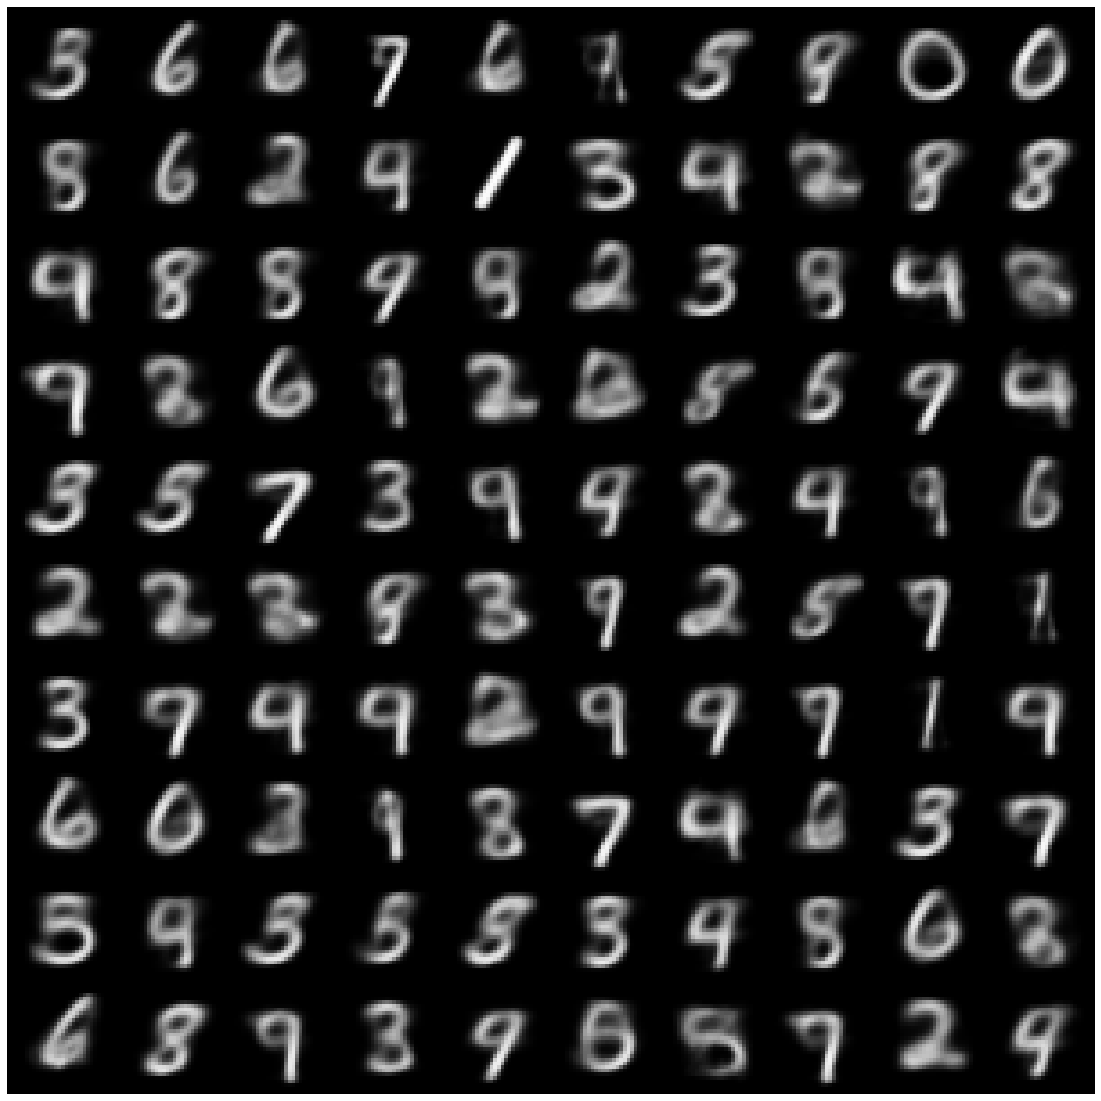

In [23]:
images = model.generate(100).to('cpu')

images = images.view(-1,1,28,28)

print('Batch shape: ', images.size())

plt.figure(figsize=(20,20))

show_batch(images,nrow=10)

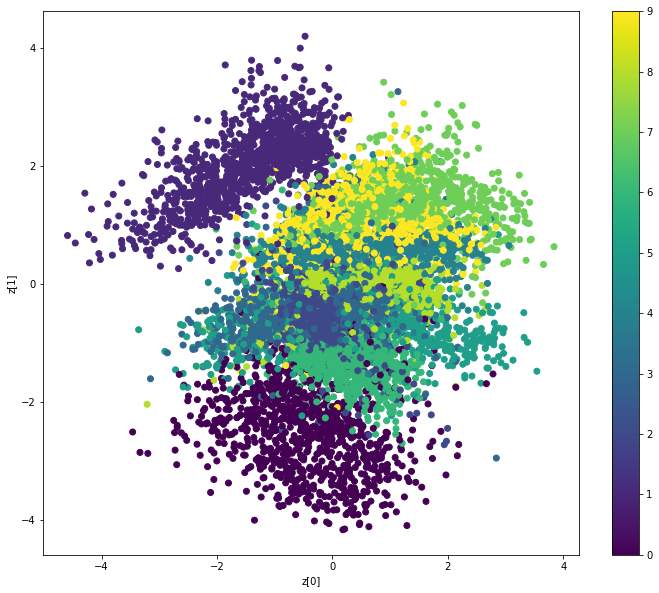

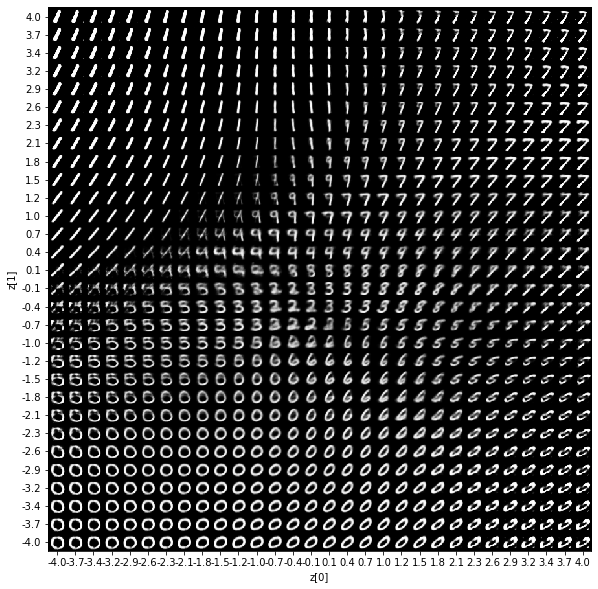

In [24]:
plot_results(model,test_loader,model_name='vae_mnist_{}'.format(epoch))